In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
"""Python code to classify X-ray sources by color.

Functionalities needed.

1. Line, step, scatter and histogram and kde plots
2. Plot net counts, bg/net and S/N ratio
3. Process detectors seperately and combine colors only optional
4. Cross-match 4XMM and CSC sources.
5. Compare with Haley et al. sources.
"""


import copy
import os
import glob2
import warnings
import xspec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter


# Plot functions
def set_plotparams(plottype):
    """Set plot parameters."""
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper1':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
    elif plottype == 'paper2':
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["axes.titlesize"] = 20
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'


def plotline_scatter(xdatas, ydatas, pl_types=None, axs=None, xlabel=None,
                     ylabel=None, pl_labels=None, styles=None, colors=None,
                     yscale='linear', title=None, ylim=None, figsize=None):
    """Plot line, step and scatter plots."""
    if pl_types is None:
        pl_types = ['line']*len(ydatas)
    if axs is None:
        fig, axs = plt.subplots(figsize=figsize)
    if pl_labels is None:
        pl_labels = [None]*len(ydatas)
    if styles is None:
        styles = ['-']*len(ydatas)
    if colors is None:
        if len(ydatas) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(ydatas) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(ydatas/9)+1)))

    axs.set_title(title)
    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(xlabel)
    axs.set_xscale('log')
    axs.set_yscale(yscale)
    axs.set_ylabel(ylabel)
    for i, pl_type in enumerate(pl_types):
        if pl_type == 'line':
            axs.plot(xdatas[i], ydatas[i], linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        elif pl_type == 'scatter':
            if styles[i] == '-':
                styles[i] = 'o'
            axs.scatter(xdatas[i], ydatas[i], marker=styles[i],
                        label=pl_labels[i], color=colors[i])
        elif pl_type == 'step':
            ydatas[i] = np.append(ydatas[i], ydatas[i].copy()[-1])
            axs.step(xdatas[i], ydatas[i], where='post', linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        else:
            raise ValueError("pl_type can only be 'line' or 'scatter'. Got " +
                             pl_type)
    axs.legend()
    return axs


def plothist(data_arr, data2=None, axs=None, bins=None, xlabel=None,
             ylabel=None, pl_labels=None, pl_type=None, cbar_label=None,
             colors=None):
    """Plot 1D and 2D histograms."""
    if axs is None:
        fig, axs = plt.subplots()
    if pl_type is None:
        pl_type = 'withoutkde'
    if pl_labels is None and isinstance(data_arr[0], (list, np.ndarray)):
        pl_labels = [None]*len(data_arr)
    if colors is None:
        if len(data_arr) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(data_arr) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(data_arr/9)+1)))
    if colors is None and data2 is not None:
        colors = 'plasma_r'
    axs.set_xlabel(xlabel)
    if data2 is None:
        if pl_type == 'withkde':
            if ylabel is None:
                ylabel = 'Density per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, density=True, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            if not isinstance(data_arr[0], (list, np.ndarray)):
                data_arr = [data_arr]
            for i, data in enumerate(data_arr):
                if pl_labels[i] is not None:
                    sns.kdeplot(x=data, label=pl_labels[i]+'_kde', ax=axs,
                                color=colors[i])
                else:
                    sns.kdeplot(x=data, ax=axs)
            axs.legend()
        else:
            if ylabel is None:
                ylabel = '# per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            axs.legend()
    else:
        # 2D hist
        axs.set_ylabel(ylabel)
        if bins is None:
            bins = 10
        if pl_type == 'withkde':
            histplot = axs.hist2d(data_arr, data2, bins=bins, density=True,
                                  cmap=colors)[-1]
            sns.kdeplot(x=data_arr, y=data2, ax=axs)
            cbar = plt.colorbar(mappable=histplot, ax=axs, color='k')
            if cbar_label is None:
                cbar_label = 'Density per bin'
            cbar.set_label(cbar_label)
        else:
            histplot = axs.hist2d(data_arr, data2)[-1]
            cbar = plt.colorbar(mappable=histplot, ax=axs)
            if cbar_label is None:
                cbar_label = '# per bin'
            cbar.set_label(cbar_label)
    return axs


def plot_subplots(numrows, numcols, xdatas_arr, ydatas_arr, title=None,
                  subp_types_arr=None, pl_types_arr=None, xlabel_arr=None,
                  ylabel_arr=None, pl_labels_arr=None, styles_arr=None,
                  bins_arr=None, cbar_labels=None, yscale_arr=None,
                  ylim_arr=None, colors_arr=None):
    """Plot subplots"""
    if subp_types_arr is None:
        subp_types_arr = [['linescatter']*numcols]*numrows
    if pl_types_arr is None:
        pl_types_arr = [[None]*numcols]*numrows
    if pl_labels_arr is None:
        pl_labels_arr = [[None]*numcols]*numrows
    if xlabel_arr is None:
        xlabel_arr = [[None]*numcols]*numrows
    if ylabel_arr is None:
        ylabel_arr = [[None]*numcols]*numrows
    if styles_arr is None:
        styles_arr = [[None]*numcols]*numrows
    if bins_arr is None:
        bins_arr = [[None]*numcols]*numrows
    if cbar_labels is None:
        cbar_labels = [[None]*numcols]*numrows
    if yscale_arr is None:
        yscale_arr = [['linear']*numcols]*numrows
    if ylim_arr is None:
        ylim_arr = [[None]*numcols]*numrows
    if colors_arr is None:
        colors_arr = [[None]*numcols]*numrows

    # Checking if all the arrays are 2D
    if not isinstance(subp_types_arr[0], list):
        subp_types_arr = list(map(list, zip(*[subp_types_arr])))
    if not isinstance(pl_labels_arr[0], list):
        pl_labels_arr = list(map(list, zip(*[pl_labels_arr])))
    if not isinstance(xlabel_arr[0], list):
        xlabel_arr = list(map(list, zip(*[xlabel_arr])))
    if not isinstance(ylabel_arr[0], list):
        ylabel_arr = list(map(list, zip(*[ylabel_arr])))

    # Calling the figure and axes
    fig, axes = plt.subplots(numrows, numcols)
    fig.suptitle(title)
    axes = axes.reshape(numrows, numcols)
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) - 4*(numcols-1))
    print(plt.rcParams["legend.fontsize"])
    if numrows == 1 and numcols == 1:
        initial_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (12, 9)

    for i in range(numrows):
        for j in range(numcols):
            if subp_types_arr[i][j] == 'linescatter':
                plotline_scatter(
                    xdatas_arr[i][j], ydatas_arr[i][j], pl_types_arr[i][j],
                    axs=axes[i][j], xlabel=xlabel_arr[i][j],
                    ylabel=ylabel_arr[i][j], pl_labels=pl_labels_arr[i][j],
                    styles=styles_arr[i][j], yscale=yscale_arr[i][j],
                    ylim=ylim_arr[i][j], colors=colors_arr[i][j])
            elif subp_types_arr[i][j] == 'hist':
                plothist(xdatas_arr[i][j], ydatas_arr[i][j], axs=axes[i][j],
                         bins=bins_arr[i][j], xlabel=xlabel_arr[i][j],
                         ylabel=ylabel_arr[i][j],
                         pl_labels=pl_labels_arr[i][j],
                         pl_type=pl_types_arr[i][j],
                         cbar_label=cbar_labels[i][j], colors=colors_arr[i][j])
            else:
                print('subplot type can be linescatter or hist')
    plt.tight_layout()
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) + 4*(numcols-1))
    if numrows == 1 and numcols == 1:
        plt.rcParams["figure.figsize"] = initial_figsize
    return fig, axes


def filter_specs(net_counts, bg_counts, min_netcounts=None, maxbg_ratio=None,
                 det_mask=None):
    """Filter specs."""
    bgratio = bg_counts/net_counts
    filter_mask = det_mask.copy()
    if det_mask is None:
        det_mask = np.ones(len(net_counts), dtype=bool)
    if min_netcounts is not None:
        filter_mask[net_counts < min_netcounts] = False
    if maxbg_ratio is not None:
        filter_mask[bgratio > maxbg_ratio] = False
    return filter_mask


def load_sim_xmmspec(folder, background=False, numsim=20000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])


def load_xmmspec_observed(folder, background=False):
    """Load Observed XMM spec."""
    pn_specfiles = glob2.glob(folder + '*PN_combined_src_grp.ds')
    mos_specfiles = glob2.glob(folder + '*MOS_combined_src_grp.ds')
    num_combined = len(glob2.glob(folder + '*PN_MOS_combined_src.png'))
    num_sources = len(pn_specfiles) + len(mos_specfiles) - num_combined
    pn_specs = np.zeros((num_sources, 4096), dtype=float)
    pn_mask = np.zeros(num_sources, dtype=bool)
    mos_specs = np.zeros((num_sources, 2400), dtype=float)
    mos_mask = np.zeros(num_sources, dtype=bool)
    pn_bgspecs = np.zeros((num_sources, 4096), dtype=float)
    mos_bgspecs = np.zeros((num_sources, 2400), dtype=float)
    source_nums = np.zeros(num_sources, dtype=object)
    for i in range(num_sources):
        if i < len(pn_specfiles):
            pn_mask[i] = True
            source_nums[i] = pn_specfiles[i].split('/')[-1].split('_')[0]
            spec_data = fits.open(pn_specfiles[i])
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pn_specfiles[i][:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                pn_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
            if os.path.isfile(folder + source_nums[i] +
                              '_MOS_combined_src_grp.ds'):
                mosfile = folder + source_nums[i] + '_MOS_combined_src_grp.ds'
                spec_data = fits.open(mosfile)
                mos_mask[i] = True
                mos_specfiles.remove(mosfile)
                mos_specs[i] = spec_data[1].data['counts']
                if background:
                    bgfile = mosfile[:-10] + 'bkg_grp.ds'
                    bg_data = fits.open(bgfile)
                    mos_bgspecs[i] = bg_data[1].data['counts']*(
                        spec_data[1].header['backscal'] /
                        bg_data[1].header['backscal'])
        else:
            mos_mask[i] = True
            source_nums[i] = (
                mos_specfiles[i-len(pn_bgspecs)].split('/')[-1].split('_')[0])
            spec_data = fits.open(mos_specfiles[i-len(pn_bgspecs)])
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                mos_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
    return (source_nums, [pn_mask, pn_specs, pn_bgspecs],
            [mos_mask, mos_specs, mos_bgspecs])


def load_chandraspec_sim(folder, background=False, num_sim=10000,
                         basename=None):
    """Load Chandra simulate spectra."""
    if basename is None:
        basename = ''
    specs = np.zeros((num_sim, 1024), dtype=float)
    bg_specs = np.zeros((num_sim, 1024), dtype=float)
    for i in range(num_sim):
        spec_file = folder + basename + str(i) + '.fak'
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bgspec_file = folder + basename + str(i) + '_bkg.fak'
            bg_data = fits.open(bgspec_file)
            bg_specs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return specs, bg_specs


def load_chandraspec_obs(folder, background=True):
    spec_files = glob2.glob(folder + '/*/*_combined_src.pi')
    spec_names = np.zeros(len(spec_files), dtype=object)
    specs = np.zeros((len(spec_files), 1024), dtype=float)
    bgspecs = np.zeros((len(spec_files), 1024), dtype=float)
    for i, spec_file in enumerate(spec_files):
        spec_file_base = os.path.basename(spec_file)
        spec_names[i] = spec_file_base.split('_')[0]
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bg_file = spec_file[:-6] + 'bkg.pi'
            bg_data = fits.open(bg_file)
            bgspecs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return spec_names, specs, bgspecs


def get_counts_enrange(spec, en_range, ebin_channels, floor_counts=None):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[elow_index:ehigh_index])
    else:
        counts_enrange = np.sum(spec[:, elow_index:ehigh_index], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                counts_enrange = floor_counts
        else:
            counts_enrange[counts_enrange < floor_counts] = floor_counts
    return counts_enrange, elow_index, ehigh_index


def get_counts_enrange2(spec, en_range, ebin_channels, floor_counts=None):
    """Another method to get counts"""
    en_mask = np.logical_and(ebin_channels >= en_range[0],
                             ebin_channels <= en_range[1])
    elow_index = np.where(en_mask)[0][0]
    ehigh_index = np.where(en_mask)[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[en_mask])
    else:
        counts_enrange = np.sum(spec[:, en_mask], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                floor_counts = 0
        else:
            counts_enrange[counts_enrange < floor_counts] = 0
    return counts_enrange, elow_index, ehigh_index


def get_summary_det(src_spec, bg_spec, ebins, en_range=None,
                    det_mask=None, src_sig=None):
    """Get summary of the spectra for given detector."""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    if det_mask is None:
        det_mask = np.ones(len(src_spec), dtype=bool)
    det_mask[net_counts < 1] = False
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    bg_counts[bg_counts/net_counts < 1.0E-6] = 1.0E-6
    if src_sig is not None:
        det_mask[net_counts < src_sig*bg_counts**0.5] = False
    return (norm_spec, net_counts, bg_counts, det_mask, en_lowindex,
            en_highindex)


def join_lists_3d(list1_2d, list2_2d, list3_2d=None):
    """Join 2 lists along another dimention."""
    joined_list = []
    for i, row in enumerate(list1_2d):
        if list3_2d is None:
            joined_list.append([row, list2_2d[i]])
        else:
            joined_list.append([row, list2_2d[i], list3_2d[i]])
    return joined_list


def join_string_lists(list1_1d, list2_1d):
    """Outer product like addition of 2 strings"""
    joined_list = []
    join_list_row = None
    for string2 in list2_1d:
        for string1 in list1_1d:
            if join_list_row is None:
                join_list_row = [string1 + ' [' + string2 + ']']
            else:
                join_list_row.append(string1 + ' [' + string2 + ']')
        joined_list.append(copy.copy(join_list_row))
        join_list_row = None
    return joined_list


def plot_spec_summary(sim_src_spec_arr, sim_bg_spec_arr, obs_src_spec_arr,
                      obs_bg_spec_arr, ebins_arr, det_names=None, e_range=None,
                      plot=True, det_mask_sim_arr=None, det_mask_obs_arr=None):
    """Plot spec summary.

    1. Mean normalized spectra (also add error fn.)
    2. Net count, Net count/Bg counts, signal-to-noise ratio plots for
       each det.
    """
    norm_specs = []
    netcounts = []
    bgcounts = []
    ebins_lowhigh_indices = []
    if plot:
        ebins_refined = []
        norm_specs_forplot = []
        netcounts_forplot = []
        bg_net_ratio_forplot = []
        s_to_n_ratio_forplot = []
    if det_mask_sim_arr is None:
        det_mask_sim_arr = [None]*len(sim_src_spec_arr)
    if det_mask_obs_arr is None:
        det_mask_obs_arr = [None]*len(obs_src_spec_arr)
    if det_names is None:
        det_names = ['']*len(sim_src_spec_arr)

    for i, sim_src_specs in enumerate(sim_src_spec_arr):
        (sim_norm_spec, sim_netcounts, sim_bgcounts, sim_detmask,
         en_lowindex, en_highindex) = get_summary_det(
            sim_src_specs, sim_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_sim_arr[i]), 3.0)
        (obs_norm_spec, obs_netcounts, obs_bgcounts,
         obs_detmask) = get_summary_det(
            obs_src_spec_arr[i], obs_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_obs_arr[i]))[:4]
        norm_specs.append([sim_norm_spec, obs_norm_spec])
        netcounts.append([sim_netcounts, obs_netcounts])
        bgcounts.append([sim_bgcounts, obs_bgcounts])
        ebins_lowhigh_indices.append([en_lowindex, en_highindex])
        det_mask_sim_arr[i] = sim_detmask
        det_mask_obs_arr[i] = obs_detmask
        if plot:
            ebins_refined.append(ebins_arr[i][en_lowindex:en_highindex])
            filter_size = int(0.2/(ebins_arr[i][en_lowindex+1] -
                                   ebins_arr[i][en_lowindex]))
            norm_specs_forplot.append([
                median_filter(np.mean(sim_norm_spec[sim_detmask], axis=0),
                              size=filter_size),
                median_filter(np.mean(obs_norm_spec[obs_detmask], axis=0),
                              size=filter_size)])
            netcounts_forplot.append([np.log10(sim_netcounts[sim_detmask]),
                                      np.log10(obs_netcounts[obs_detmask])])
            bg_net_ratio_forplot.append([
                np.log10((sim_bgcounts/sim_netcounts)[sim_detmask]),
                np.log10((obs_bgcounts/obs_netcounts)[obs_detmask])])
            s_to_n_ratio_forplot.append([
                np.log10((sim_netcounts /
                         (sim_netcounts+sim_bgcounts)**0.5)[sim_detmask]),
                np.log10((obs_netcounts /
                         (obs_netcounts+obs_bgcounts)**0.5)[obs_detmask])]
            )

    if plot is False:
        return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
                det_mask_sim_arr, det_mask_obs_arr)

    for i, norm_spec_sim_obs in enumerate(norm_specs_forplot):
        plotline_scatter([ebins_refined[i], ebins_refined[i]],
                         norm_spec_sim_obs, xlabel='Energy (keV)',
                         ylabel='Smoothed mean normalized spectra',
                         pl_labels=['Sim. ' + det_names[i] + ' spectra',
                                    'Obs. ' + det_names[i] + ' spectra'],
                         title=('Simulated and Observed ' + det_names[i] +
                                ' spectra'),
                         figsize=(12, 9))

    hist1D_joined_list = join_lists_3d(netcounts_forplot,
                                       bg_net_ratio_forplot,
                                       s_to_n_ratio_forplot)
    plot_subplots(
        len(norm_specs_forplot), 3, hist1D_joined_list,
        [[None]*3]*len(norm_specs_forplot),
        title='1D histograms of net and background counts',
        xlabel_arr=join_string_lists(
            ['log (Net counts)', 'log (Bg counts/Net counts)',
             'Signal-to-Noise Ratio'], det_names),
        ylabel_arr=[['# density per bin']*3]*len(norm_specs_forplot),
        subp_types_arr=[['hist']*3]*3,
        pl_types_arr=[['withkde']*3]*3,
        pl_labels_arr=[
            [['Simulated MSPs', 'Observed sources']]*3]*len(norm_specs_forplot)
    )

    return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
            det_mask_sim_arr, det_mask_obs_arr)


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return np.append(emin, emax[-1]), e_centres


def get_line_cont_counts(src_spec, bg_spec, ebins, net_spec=None,
                         range_fe=None, cont1_range=None, cont2_range=None):
    """Get line and continuum counts"""
    if net_spec is None:
        net_spec = src_spec - bg_spec
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if cont1_range is None:
        cont1_range = [5.8, 6.2]
    if cont2_range is None:
        cont2_range = [7.2, 7.6]
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins,
                                   floor_counts=0)[0]

    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins,
                                      floor_counts=0)[0]

    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins,
                                      floor_counts=0)[0]
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])


def get_colors_basic(counts_line_net, counts_cont1_net, counts_cont2_net,
                     mask=None):
    """Get colors."""
    if mask is None:
        mask = np.ones(len(counts_line_net), dtype=bool)
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    colors[~mask] = np.nan
    return colors


def get_colors_binned(colors, src_prop, srcprop_bins, mask=None):
    """Get expected color for given bins."""
    mean_colors = np.zeros(len(srcprop_bins)-1)
    median_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], median_colors[i], colors_std[i] = get_colors_perbin(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std, median_colors


def get_colors_perbin(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(np.logical_and(src_prop >= bin_edges[0],
                                                  src_prop < bin_edges[1]),
                                   np.isfinite(colors)))
    bin_colors = colors[mask]
    return np.mean(bin_colors), np.median(bin_colors), np.std(bin_colors)
    # return sigma_clipped_stats(bin_colors, sigma=5)


def bin_colors_withprop(colors, prop_list, prop_listnames, obs_colors,
                        obs_props, prop_binslist=None, plot=True, plot_det=''):
    """Bin colors with properties."""
    mean_colors_withprop = []
    median_colors_withprop = []
    std_colors_withprop = []
    if prop_binslist is None:
        prop_binslist = []
        no_given_bins = True
    else:
        no_given_bins = False
    for i in range(len(prop_list)):
        print('Calaculating mean and standard deviation in colors vs. ' +
              prop_listnames[i])
        if no_given_bins:
            prop_bins = 10**np.linspace(
                np.log10(max(0.00001, np.min(prop_list[i]))),
                np.log10(min(1.0E+5, np.max(prop_list[i]))), 21)
            prop_binslist.append(prop_bins)
        mean_colors, colors_std, median_colors = get_colors_binned(
            colors, prop_list[i], prop_binslist[i])
        mean_colors_withprop.append(mean_colors)
        std_colors_withprop.append(colors_std)
        median_colors_withprop.append(median_colors)
        if plot:
            plot_subplots(
                1, 2, [[[prop_list[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])],
                       [obs_props[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])]]],
                [[[colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std],
                 [obs_colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std]]],
                subp_types_arr=[['linescatter', 'linescatter']],
                pl_types_arr=[[['scatter', 'step', 'step'],
                              ['scatter', 'step', 'step']]],
                xlabel_arr=[[prop_listnames[i], prop_listnames[i]]],
                ylabel_arr=[['Simulated source colors',
                            'Observed source colors']],
                pl_labels_arr=[[['Colors', 'Mean + 2.0std', 'Mean - 2.0std'],
                                ['Colors', 'Mean + 2.0std', 'Mean - 2.0std']]],
                title='Color vs ' + prop_listnames[i] + ' for ' + plot_det,
                ylim_arr=[[(0, 5), (0, 5)], [(0, 5), (0, 5)]])
    return (prop_binslist, mean_colors_withprop, std_colors_withprop,
            median_colors_withprop)


def load_alldata(response_paths, sim_spec_paths, obs_spec_paths, range_fe=None,
                 range_cont1=None, range_cont2=None, en_range=None):
    """Main function to process the entire dataset."""
    det_enbins_arr = []
    det_ecenters_arr = []
    sim_srcspec_arr = []
    sim_bgspec_arr = []
    sim_mask_arr = []
    obs_srcspec_arr = []
    obs_bgspec_arr = []
    obs_mask_arr = []
    obs_src_nums = []
    det_names = ['PN', 'MOS', 'ACIS']
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if range_cont1 is None:
        range_fe = [5.8, 6.2]
    if range_cont2 is None:
        range_fe = [7.2, 7.6]
    if en_range is None:
        en_range = [2, 10]
    for i, response in enumerate(response_paths):
        # Load energy bins
        det_ebins, det_ecenters = get_enbins_centres(response)
        det_enbins_arr.append(det_ebins)
        det_ecenters_arr.append(det_ecenters)
        # Load spectra
        if i == 0:
            ([sim1_mask, sim2_mask], [sim1_specs, sim2_specs],
             [sim1_bgs, sim2_bgs]) = load_sim_xmmspec(
                sim_spec_paths[i], background=True, basename='msp_highNH_')
            (source_nums, [obs1_mask, obs1_specs, obs1_bgs],
             [obs2_mask, obs2_specs, obs2_bgs]) = load_xmmspec_observed(
                obs_spec_paths[i], background=True)
            sim_srcspec_arr.append(sim1_specs)
            sim_srcspec_arr.append(sim2_specs)
            sim_bgspec_arr.append(sim1_bgs)
            sim_bgspec_arr.append(sim2_bgs)
            sim_mask_arr.append(sim1_mask)
            sim_mask_arr.append(sim2_mask)
            obs_srcspec_arr.append(obs1_specs)
            obs_srcspec_arr.append(obs2_specs)
            obs_bgspec_arr.append(obs1_bgs)
            obs_bgspec_arr.append(obs2_bgs)
            obs_mask_arr.append(obs1_mask)
            obs_mask_arr.append(obs2_mask)
            obs_src_nums.append(source_nums)
        elif i == 2:
            sim_specs, sim_bgs = load_chandraspec_sim(
                sim_spec_paths[i], background=True, num_sim=10000,
                basename='msp_highNH_')
            src_names, obs_specs, obs_bgs = load_chandraspec_obs(
                obs_spec_paths[i])
            sim_mask = np.ones(len(sim_specs), dtype=bool)
            obs_mask = np.ones(len(obs_specs), dtype=bool)
            sim_srcspec_arr.append(sim_specs)
            sim_bgspec_arr.append(sim_bgs)
            sim_mask_arr.append(sim_mask)
            obs_srcspec_arr.append(obs_specs)
            obs_bgspec_arr.append(obs_bgs)
            obs_mask_arr.append(obs_mask)
            obs_src_nums.append(src_names)
        else:
            pass
    # Plot spec summary
    (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices, det_mask_sim,
     det_mask_obs) = plot_spec_summary(
        sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr, obs_bgspec_arr,
        det_enbins_arr, det_names, en_range, True, sim_mask_arr, obs_mask_arr)
    spec_summary = {'ebins': [det_enbins_arr, det_ecenters_arr],
                    'elowhigh': ebins_lowhigh_indices,
                    'specs': [sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr,
                              obs_bgspec_arr],
                    'spec_masks': [det_mask_sim, det_mask_obs],
                    'src_nums': obs_src_nums,
                    'norm_specs': norm_specs,
                    'counts': [netcounts, bgcounts]}
    return spec_summary


def getcolor_prop_singledet(det_ebins, det_srcspecs, det_bgspecs,
                            det_netcounts, det_bgcounts, det_obs_srcspecs,
                            det_obs_bgspecs, det_obsnetcounts, det_obsbgcounts,
                            range_fe=None, netcounts_lowhigh=None,
                            bgratio_lowhigh=None, snr_lowhigh=None,
                            det_name=None, plot=False):
    """Process single detector.

    Values may include nan. Will have to be masked later for plotting. Else
    submit already masked values
    """
    print(len(det_srcspecs), len(det_bgspecs), len(det_bgcounts), len(det_netcounts))
    print(len(det_obs_srcspecs), len(det_obs_bgspecs), len(det_obsbgcounts), len(det_obsnetcounts))
    bg_net_ratio = det_bgcounts/det_netcounts
    obs_bgnet_ratio = det_obsbgcounts/det_obsnetcounts
    sim_snr = det_netcounts/(det_netcounts + det_bgcounts)**0.5
    obs_snr = det_obsnetcounts/(det_obsnetcounts + det_obsbgcounts)**0.5
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    if netcounts_lowhigh is None:
        netcount_bins = 10**(np.linspace(1, 5, 21))
    else:
        netcount_bins = 10**(np.linspace(np.log10(netcounts_lowhigh[0]),
                                         np.log10(netcounts_lowhigh[1]), 21))
    if bgratio_lowhigh is None:
        bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    else:
        bg_net_ratio_bins = 10**(np.linspace(np.log10(bgratio_lowhigh[0]),
                                             np.log10(bgratio_lowhigh[1]), 21))
    if snr_lowhigh is None:
        snr_bins = 10**(np.linspace(0, 3, 21))
    else:
        snr_bins = 10**(np.linspace(np.log10(snr_lowhigh[0]),
                                    np.log10(snr_lowhigh[1]), 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [det_netcounts, bg_net_ratio, sim_snr],
        ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio'],
        obs_det_colors, [det_obsnetcounts, obs_bgnet_ratio, obs_snr],
        [netcount_bins, bg_net_ratio_bins, snr_bins], plot=plot,
        plot_det=det_name)[1:]
    sim_colors_dict = {'prop_list': [det_netcounts, bg_net_ratio, sim_snr],
                       'prop_bins': [netcount_bins, bg_net_ratio_bins,
                                     snr_bins],
                       'fe_cont_counts': [fe_net, cont1_net, cont2_net],
                       'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                       'colors': det_colors,
                       'color_stat': [mean_colors_withprop,
                                      median_colors_withprop,
                                      std_colors_withprop]}
    obs_colors_dict = {'prop_list': [det_obsnetcounts, obs_bgnet_ratio,
                                     obs_snr],
                       'fe_cont_counts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                       'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                            obs_cont2_bg],
                       'colors': obs_det_colors}
    return sim_colors_dict, obs_colors_dict


def get_bincenters(bins):
    """Get center of bins."""
    return bins


def getcolor_prop_alldet(spec_summary, compare_det=False):
    """Get colors in all detectors and plot relevant figure."""
    ebins_arr = spec_summary['ebins'][0]
    specs = spec_summary['specs']
    spec_masks = spec_summary['spec_masks']
    counts = spec_summary['counts']
    det_names = ['PN', 'MOS', 'ACIS']
    sim_colors_dict_arr = []
    obs_colors_dict_arr = []
    prop_names = ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio']
    plot_det = not compare_det
    for i, ebins in enumerate(ebins_arr):
        sim_colors_dict, obs_colors_dict = getcolor_prop_singledet(
            ebins, specs[0][i][spec_masks[0][i]],
            specs[1][i][spec_masks[0][i]], counts[0][i][0][spec_masks[0][i]],
            counts[1][i][0][spec_masks[0][i]], specs[2][i][spec_masks[1][i]],
            specs[3][i][spec_masks[1][i]], counts[0][i][1][spec_masks[1][i]],
            counts[1][i][1][spec_masks[1][i]], det_name=det_names[i],
            plot=plot_det)
        sim_colors_dict_arr.append(sim_colors_dict)
        obs_colors_dict_arr.append(obs_colors_dict)
    if compare_det:
        for i in range(3):
            plot_subplots(
                3, 2,
                [[[
                    sim_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])], [
                    obs_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])], [
                    obs_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])], [
                    obs_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])]]],
                [[[
                    sim_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])], [
                    obs_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])], [
                    obs_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])], [
                    obs_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])]]],
                subp_types_arr=[['linescatter']*2]*3,
                pl_types_arr=[[['scatter', 'step', 'step']]*2]*3,
                xlabel_arr=join_string_lists(
                    ['Simulated ' + prop_names[i],
                     'Observed ' + prop_names[i]], det_names),
                ylabel_arr=[['Simulated source colors',
                             'Observed source colors']]*3,
                pl_labels_arr=[[['Colors', r'Mean + 2.0$\sigma$',
                               r'Mean - 2.0$\sigma$']]*2]*3,
                ylim_arr=[[(0, 5)]*2]*3)
    return sim_colors_dict_arr, obs_colors_dict_arr


def process_singledet1(det_ebins, det_srcspecs, det_bgspecs, det_mask,
                       det_name, det_obs_ebins=None, det_obs_srcspecs=None,
                       det_obs_bgspecs=None, det_obsmask=None, range_fe=None):
    """Process single detector data."""
    ([netcounts, obs_netcounts],
     [bgcounts, obs_bgcounts], lowindex, highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[2.0, 10.0], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask)
    ([netcounts_aroundfe, obs_netcounts_aroundfe],
     [bgcounts_aroundfe, obs_bgcounts_aroundfe], aroundfe_lowindex,
     aroundfe_highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[5.8, 7.6], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask, det=det_name)
    bg_net_ratio = bgcounts/netcounts
    obs_bg_netratio = obs_bgcounts/obs_netcounts
    bg_net_ratio_aroundfe = bgcounts_aroundfe/netcounts_aroundfe
    obs_bg_netratio_aroundfe = obs_bgcounts_aroundfe/obs_netcounts_aroundfe
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_obs_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net, mask=det_mask)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    netcount_bins = 10**(np.linspace(1, 5, 21))
    netcount_aroundfe_bins = 10**(np.linspace(0, 4, 21))
    bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    bg_net_ratio_aroundfe_bins = 10**(np.linspace(-2, 1, 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [netcounts, netcounts_aroundfe, bg_net_ratio,
                     bg_net_ratio_aroundfe],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [obs_netcounts, obs_netcounts_aroundfe,
                         obs_bg_netratio, obs_bg_netratio_aroundfe],
        [netcount_bins, netcount_aroundfe_bins, bg_net_ratio_bins,
         bg_net_ratio_aroundfe_bins], plot=True, plot_det=det_name)[1:]
    sim_det_dict = {'counts_2_10': [netcounts, bgcounts],
                    'counts_aroundfe': [netcounts_aroundfe, bgcounts],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [fe_net, cont1_net, cont2_net],
                    'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                    'fe_cont_srccounts': [fe_src, cont1_src, cont2_src],
                    'prop_bins': [netcount_bins, netcount_aroundfe_bins,
                                  bg_net_ratio_bins,
                                  bg_net_ratio_aroundfe_bins],
                    'mean_std_colors_withprop': [
                        mean_colors_withprop, std_colors_withprop,
                        median_colors_withprop]}
    obs_det_dict = {'counts_2_10': [obs_netcounts, obs_bgcounts],
                    'counts_aroundfe': [obs_netcounts_aroundfe,
                                        obs_bgcounts_aroundfe],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                    'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                         obs_cont2_bg],
                    'fe_cont_srccounts': [obs_fe_src, obs_cont1_src,
                                          obs_cont2_src]}
    return sim_det_dict, obs_det_dict


def combine_pn_mos_prop(pn_prop, mos_prop, pn_mask, mos_mask):
    """Combine PN and MOS properties."""
    combined_prop = np.zeros_like(pn_prop)
    combined_prop[np.logical_and(
        pn_mask, ~mos_mask)] = pn_prop[np.logical_and(pn_mask, ~mos_mask)]
    combined_prop[np.logical_and(
        ~pn_mask, mos_mask)] = mos_prop[np.logical_and(~pn_mask, mos_mask)]
    combined_prop[np.logical_and(
        pn_mask, mos_mask)] = (pn_prop + mos_prop)[
            np.logical_and(pn_mask, mos_mask)]
    return combined_prop


def combine_wantedprops(pn_dict, mos_dict, pn_mask, mos_mask):
    """Combine the counts from PN and MOS detectors."""
    net_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][0], mos_dict['counts_2_10'][0], pn_mask,
        mos_mask)
    bg_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][1], mos_dict['counts_2_10'][1], pn_mask,
        mos_mask)
    net_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][0], mos_dict['counts_aroundfe'][0], pn_mask,
        mos_mask)
    bg_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][1], mos_dict['counts_aroundfe'][1], pn_mask,
        mos_mask)
    combined_fe_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][0], mos_dict['fe_cont_netcounts'][0],
        pn_mask, mos_mask)
    combined_cont1_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][1], mos_dict['fe_cont_netcounts'][1],
        pn_mask, mos_mask)
    combined_cont2_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][2], mos_dict['fe_cont_netcounts'][2],
        pn_mask, mos_mask)
    combined_colors = get_colors_basic(combined_fe_net, combined_cont1_net,
                                       combined_cont2_net)
    return (net_counts, bg_counts/net_counts, net_counts_aroundfe,
            bg_counts_aroundfe/net_counts_aroundfe, combined_colors)


833:80: E501 line too long (85 > 79 characters)
834:80: E501 line too long (99 > 79 characters)


In [4]:
chandra_response_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep_GB_sources/chandra_deep_combined_spec/2CXOJ174525.2-290632_combined_src.rmf'
pn_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/PN/epn_bu23_dY9.rmf.gz'
mos_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf'
chandra_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_msp_sim_highNH/'
xmm_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/sim_msps_highNH_PN_MOS/'
chandra_obs_path = '../data/chandra_obs/'
xmm_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/Galactic_highNH_combinedXMM/'

1:80: E501 line too long (170 > 79 characters)
2:80: E501 line too long (115 > 79 characters)
3:80: E501 line too long (120 > 79 characters)
4:80: E501 line too long (100 > 79 characters)
5:80: E501 line too long (96 > 79 characters)


In [9]:
set_plotparams('notebook')

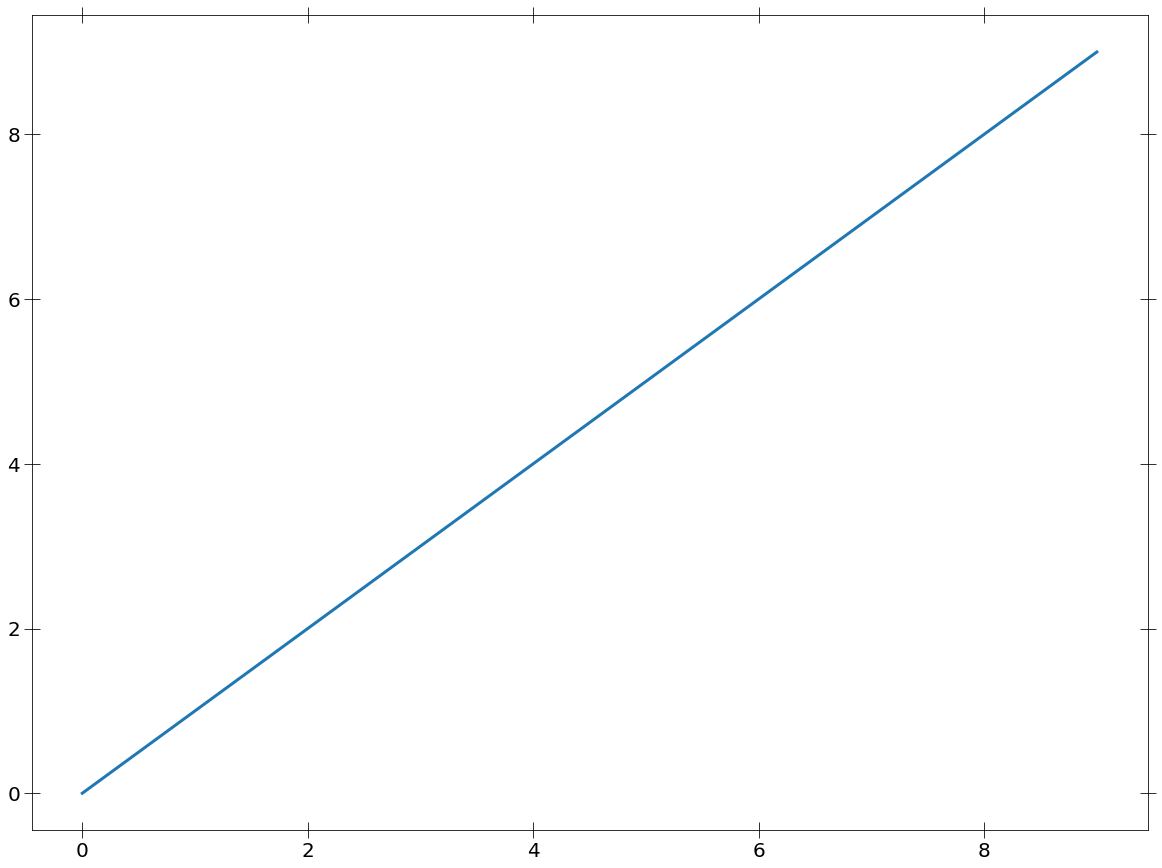

In [10]:
plt.plot(np.arange(10))

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:287: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


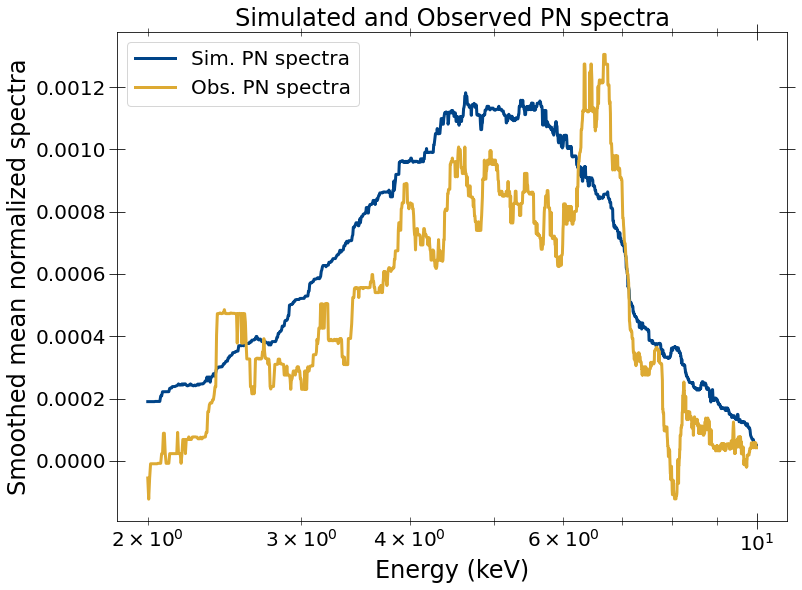

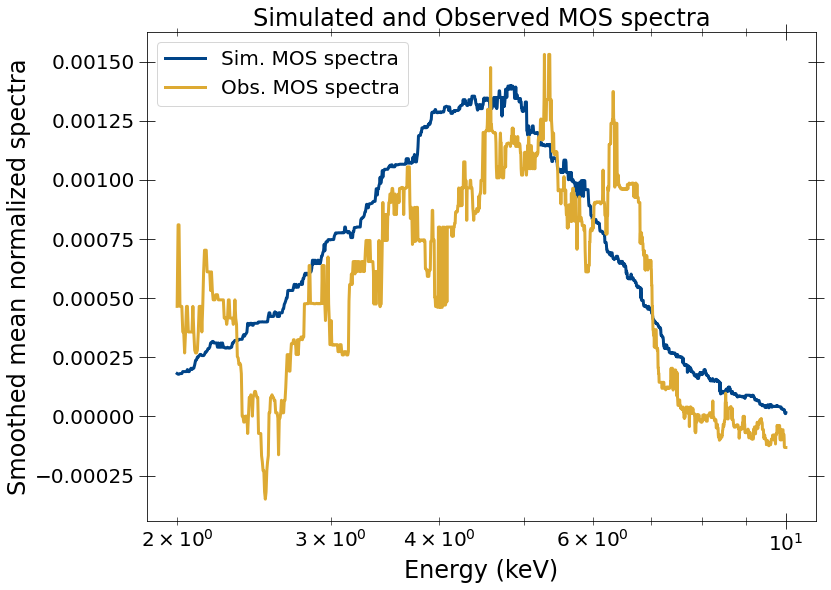

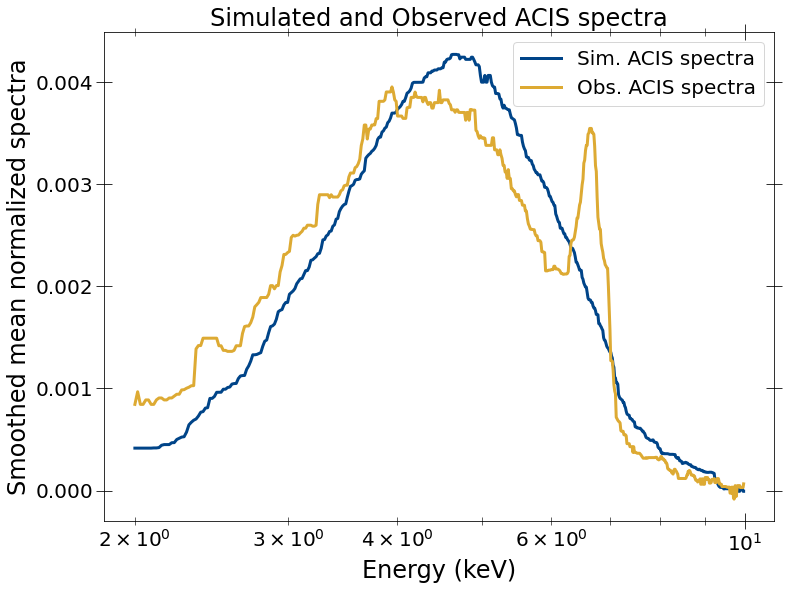

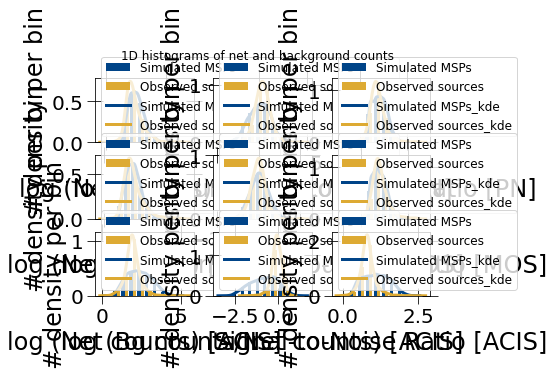

In [8]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


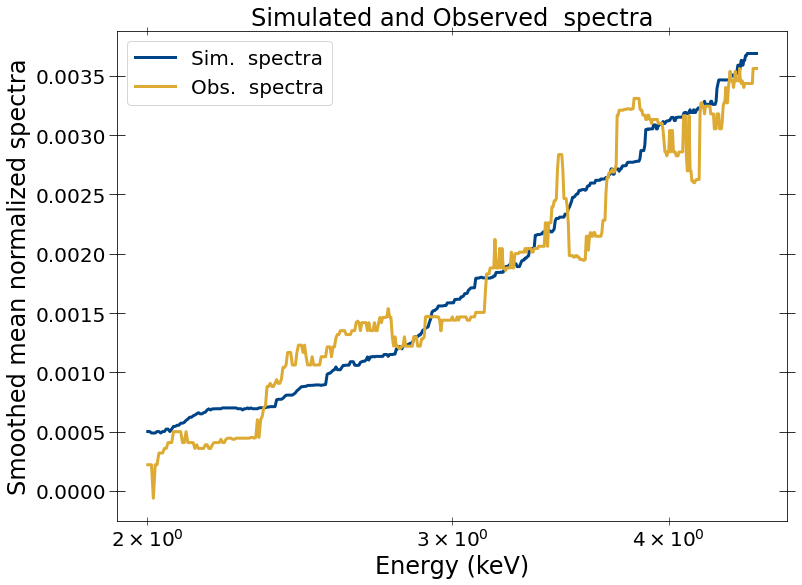

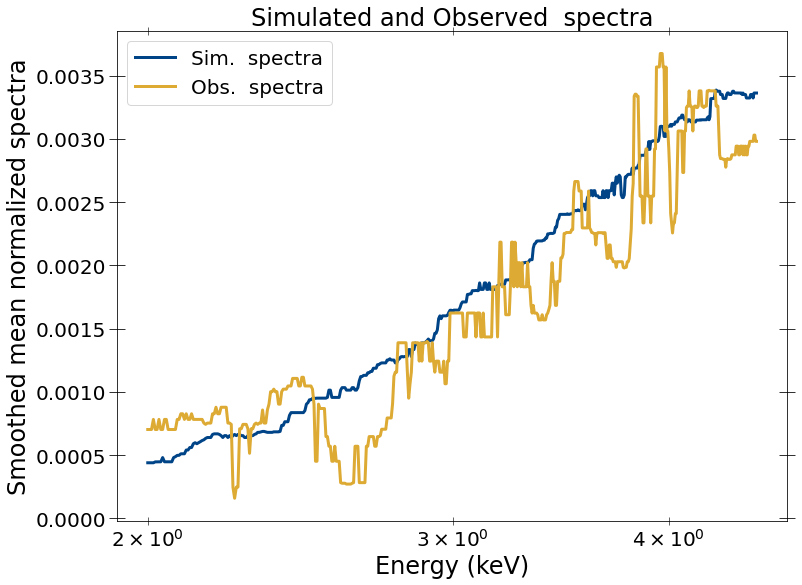

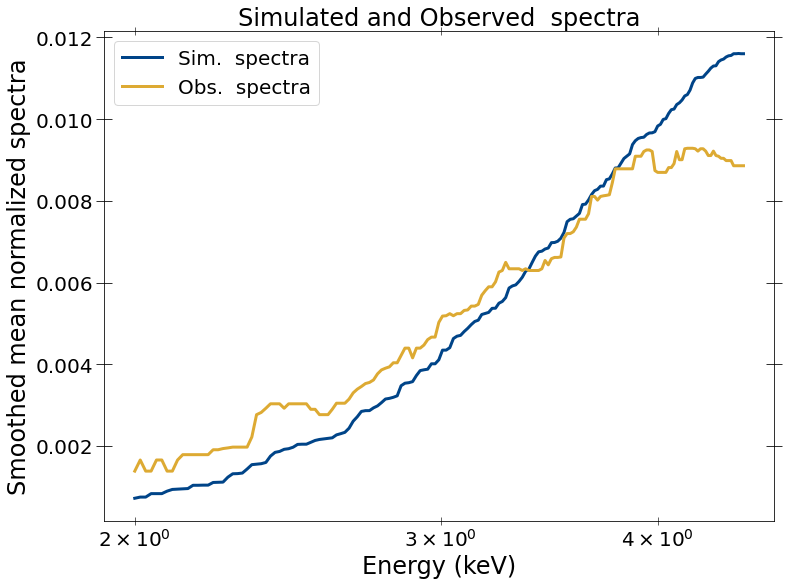

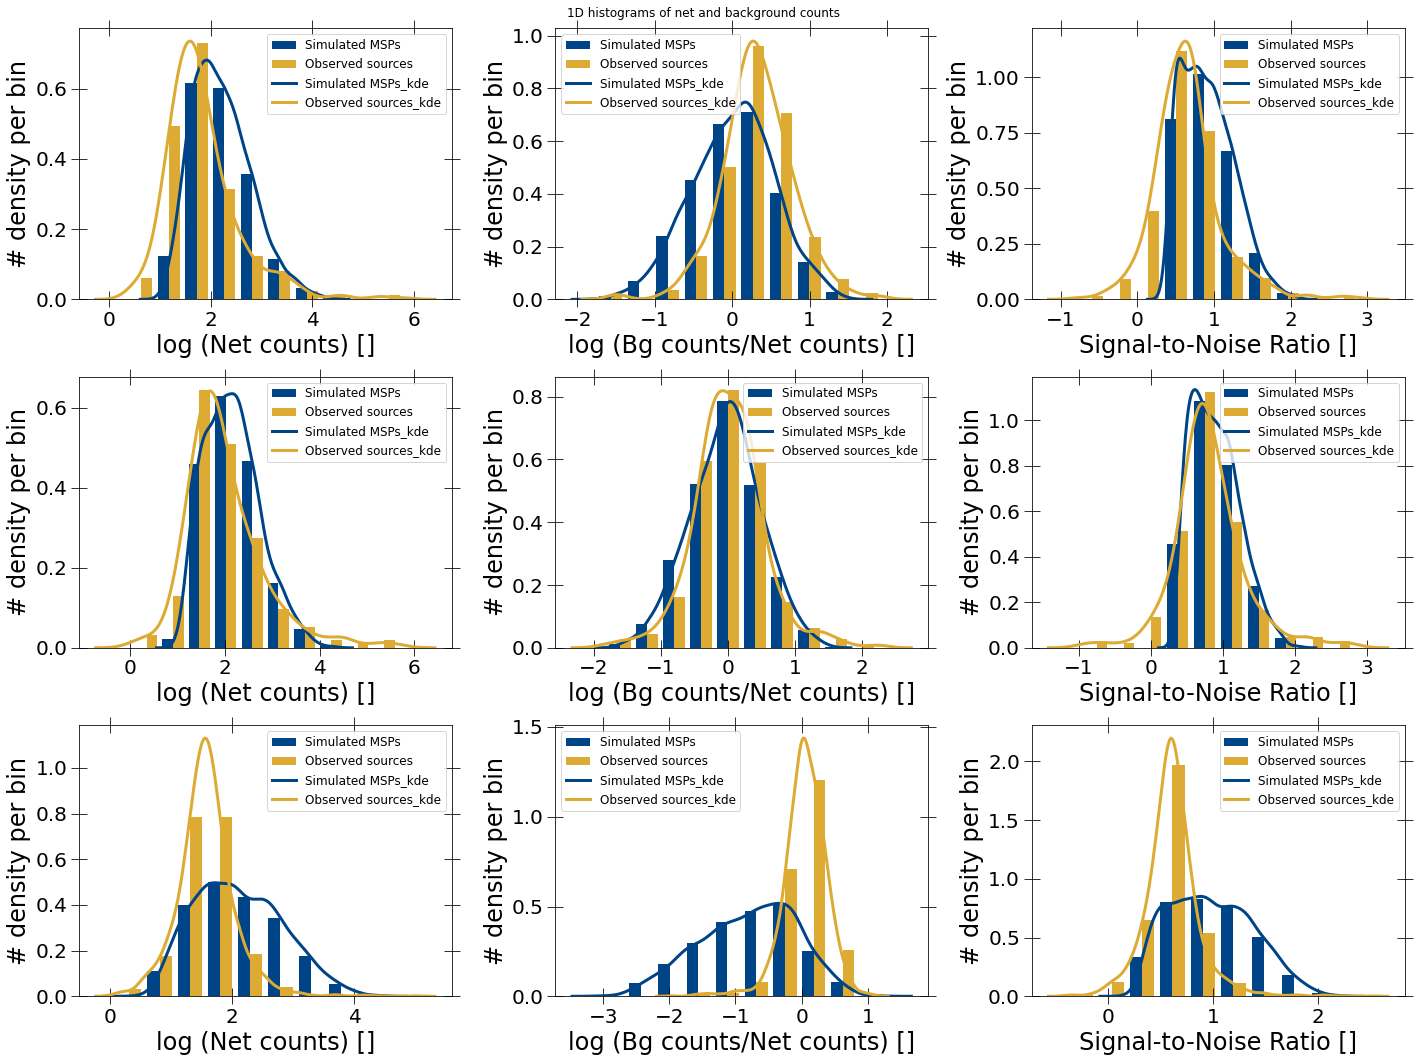

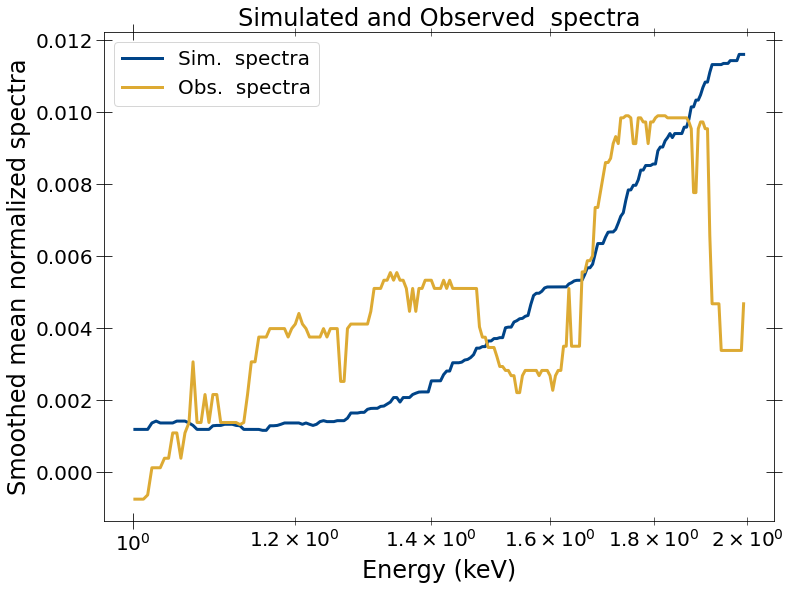

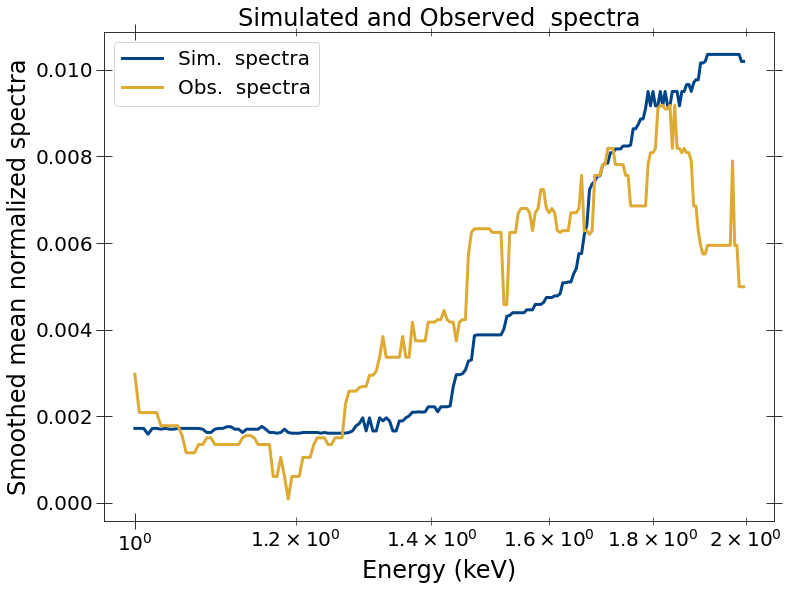

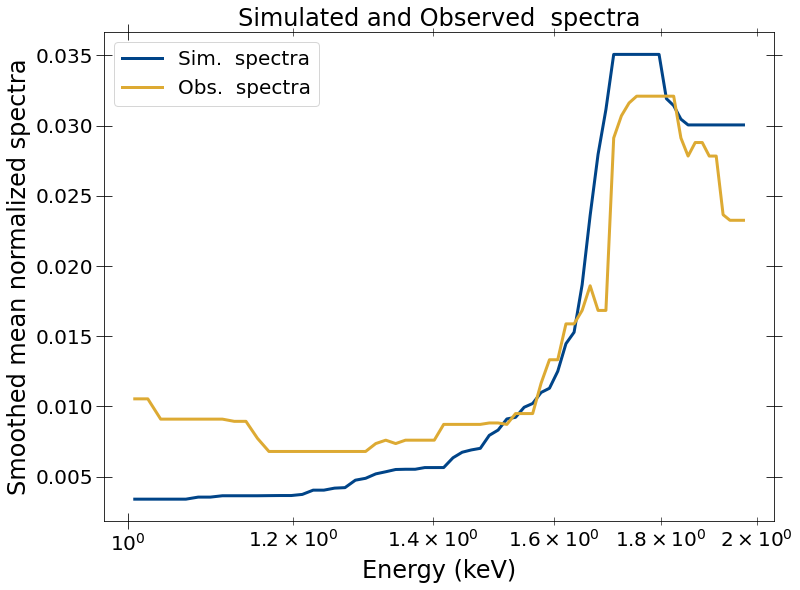

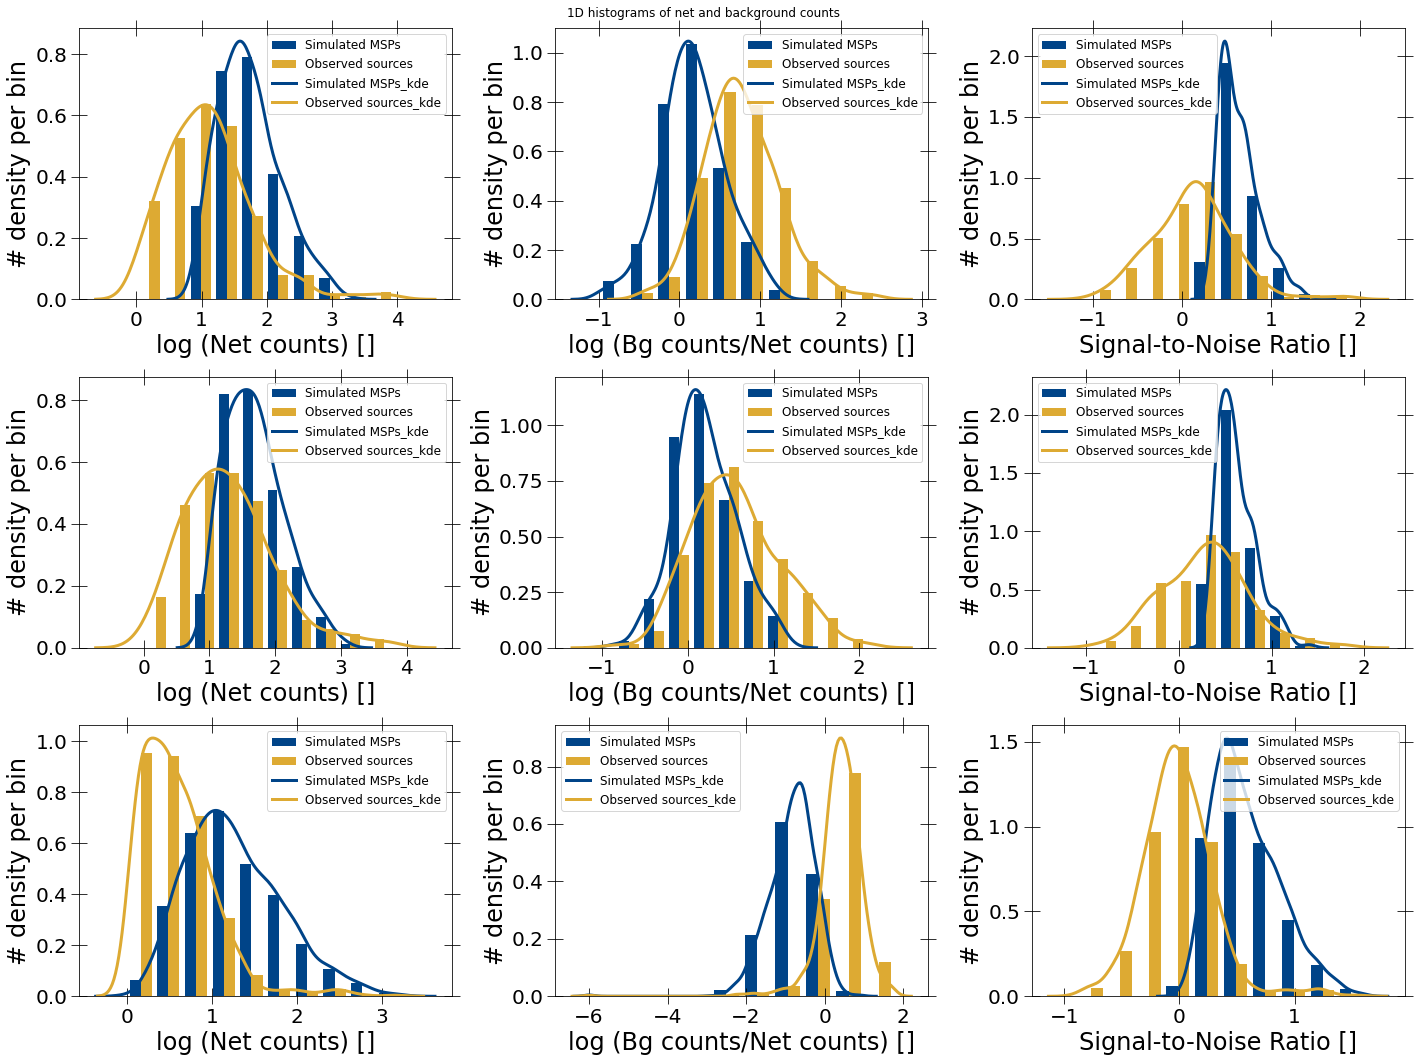

4:80: E501 line too long (95 > 79 characters)
9:80: E501 line too long (95 > 79 characters)


In [108]:
(norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
 det_mask_sim_arr, det_mask_obs_arr) = plot_spec_summary(
                  spec_summary['specs'][0], spec_summary['specs'][1],
                  spec_summary['specs'][2], spec_summary['specs'][3], spec_summary['ebins'][0],
                  e_range=[2.0, 4.5])
(norm_specs2, netcounts2, bgcounts2, ebins_lowhigh_indices2,
 det_mask_sim_arr2, det_mask_obs_arr2) = plot_spec_summary(
                  spec_summary['specs'][0], spec_summary['specs'][1],
                  spec_summary['specs'][2], spec_summary['specs'][3], spec_summary['ebins'][0],
                  e_range=[1.0, 2.0])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


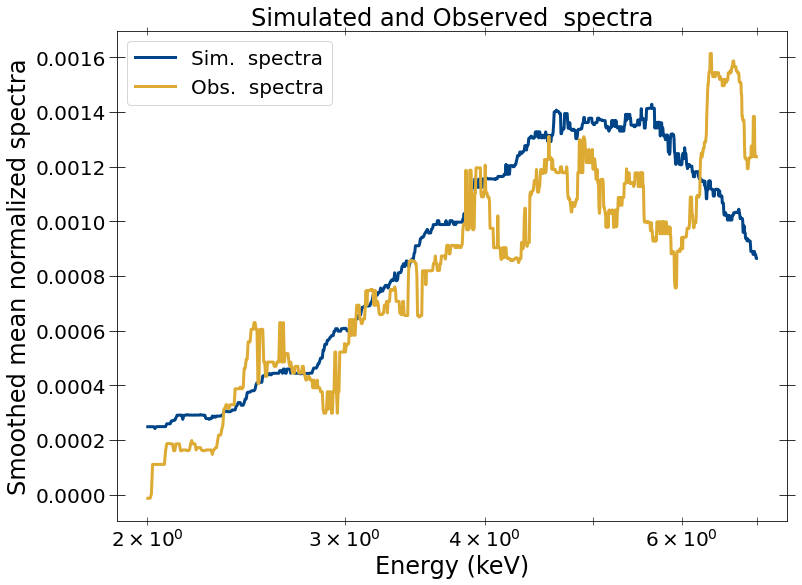

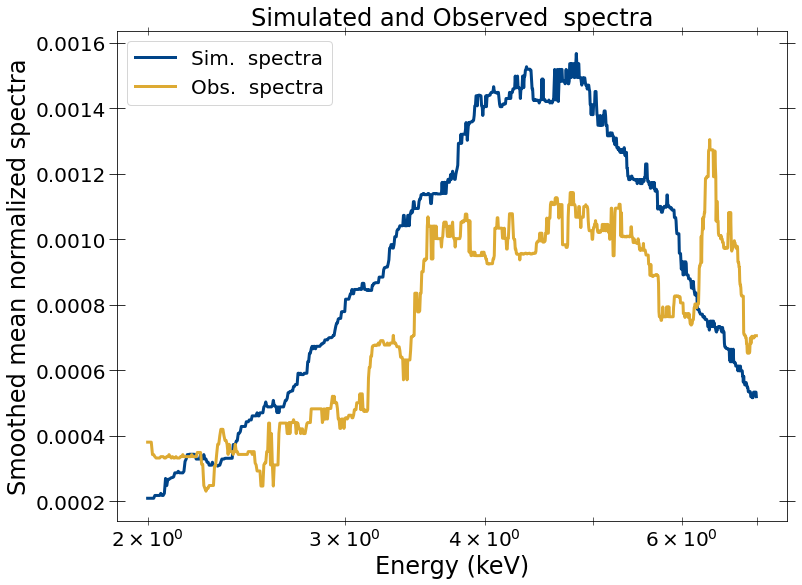

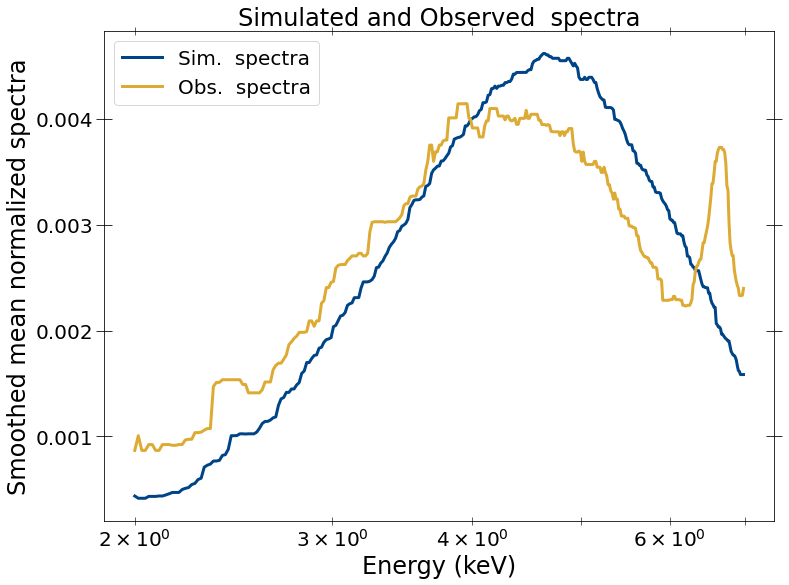

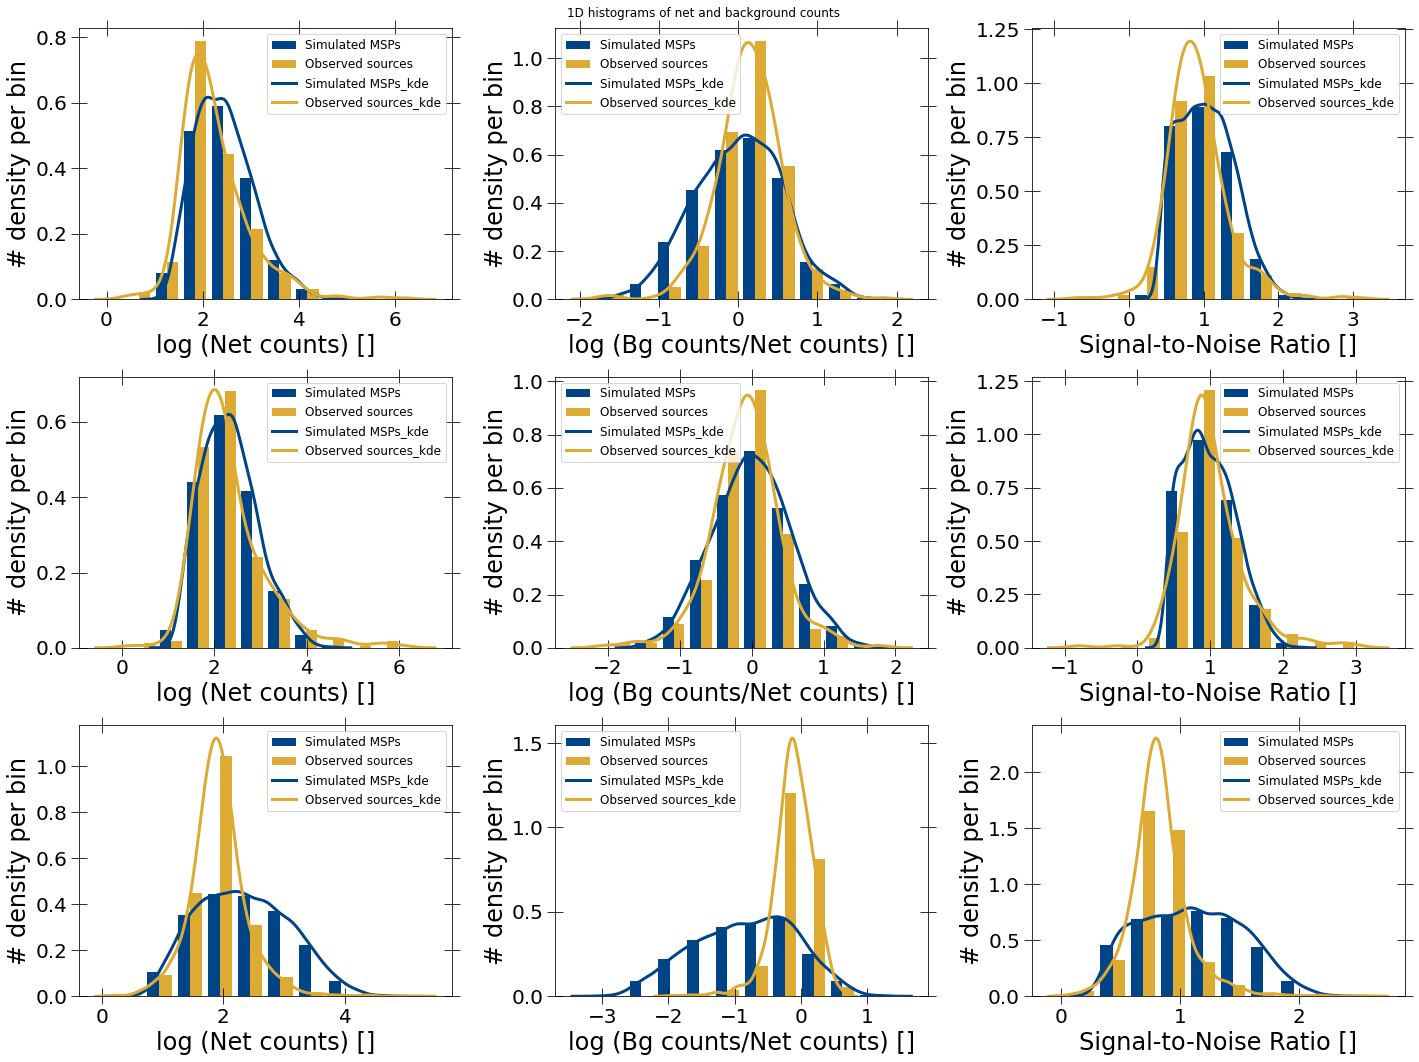

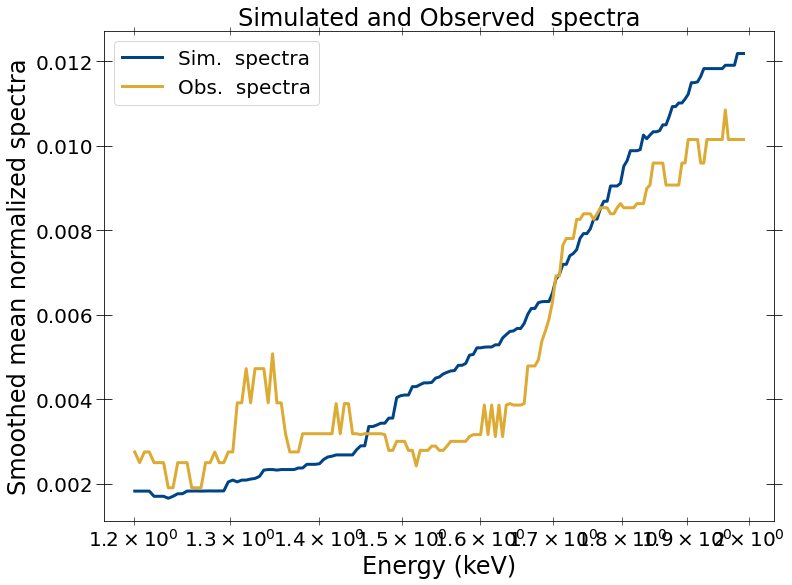

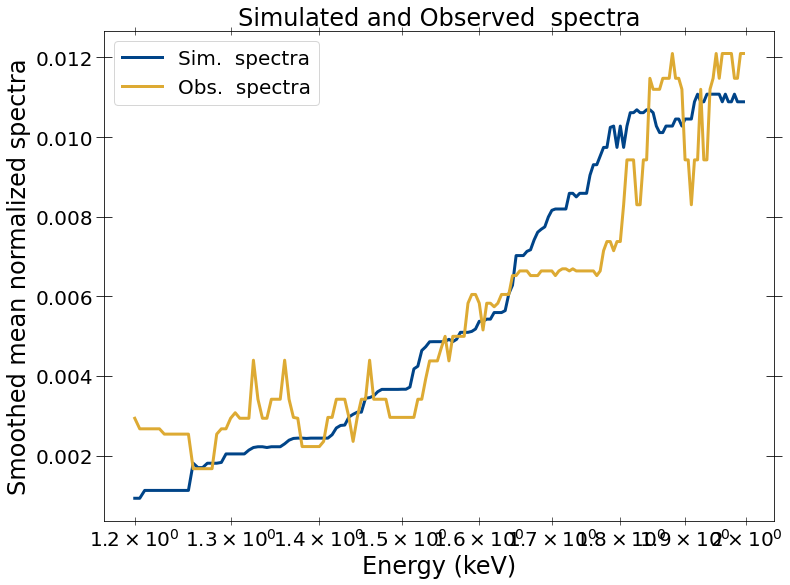

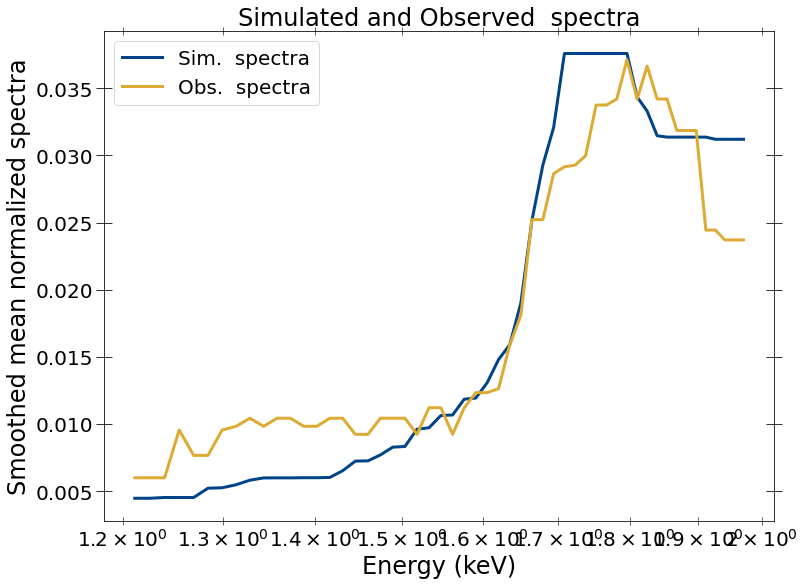

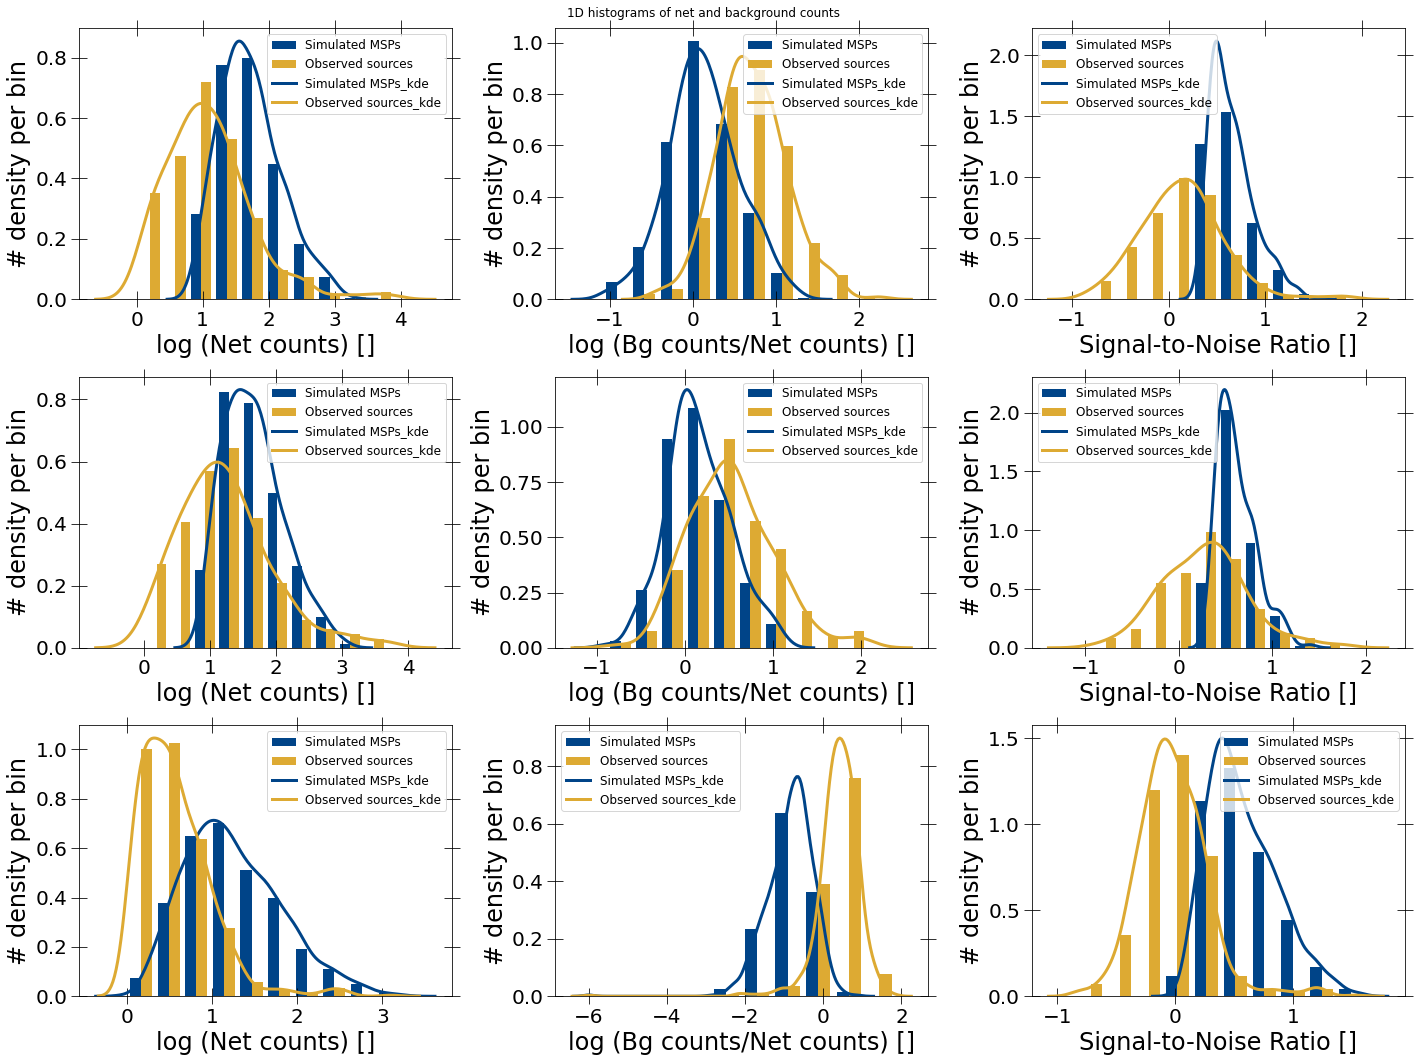

4:80: E501 line too long (95 > 79 characters)
9:80: E501 line too long (95 > 79 characters)


In [110]:
(norm_specs3, netcounts3, bgcounts3, ebins_lowhigh_indices3,
 det_mask_sim_arr3, det_mask_obs_arr3) = plot_spec_summary(
                  spec_summary['specs'][0], spec_summary['specs'][1],
                  spec_summary['specs'][2], spec_summary['specs'][3], spec_summary['ebins'][0],
                  e_range=[2.0, 7.0])
(norm_specs4, netcounts4, bgcounts4, ebins_lowhigh_indices4,
 det_mask_sim_arr4, det_mask_obs_arr4) = plot_spec_summary(
                  spec_summary['specs'][0], spec_summary['specs'][1],
                  spec_summary['specs'][2], spec_summary['specs'][3], spec_summary['ebins'][0],
                  e_range=[1.2, 2.0])

In [24]:
netcounts[0]

[array([ 18.75375852,  63.83679778, 905.76882317, ...,   0.        ,
          0.        ,   0.        ]),
 array([ 1.79548781e+02,  7.20001481e+01,  6.89052256e+01,  1.59377751e+02,
         5.36739664e+01,  2.39812117e+02,  1.17872583e+03,  6.17912168e+05,
         4.19176327e+02,  1.32236566e+03,  4.84825256e+02,  3.30606998e+03,
         3.69335269e+02,  1.03831655e+02,  4.14303766e+01,  1.82876989e+03,
         1.73124543e+02,  1.83940877e+02,  1.18419304e+03,  1.61365603e+02,
         2.93766870e+02,  5.01781466e+01, -1.82859844e+01, -1.46800166e+01,
         2.58292319e+02,  3.13507587e+02,  1.34522696e+01,  6.15890294e+01,
         1.98799487e+02,  1.57989627e+02,  5.46398290e+02,  3.16018366e+01,
         1.15809925e+02,  5.55770499e+02,  1.58508921e+02,  3.66921187e+02,
         3.74367798e+05,  5.59814674e+04,  4.11773718e+03,  6.71207834e+02,
         1.02616626e+02,  3.84197501e+02,  9.01321768e+02,  1.37475712e+03,
         6.93394564e+02,  1.97539551e+02,  3.42652189e+02

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


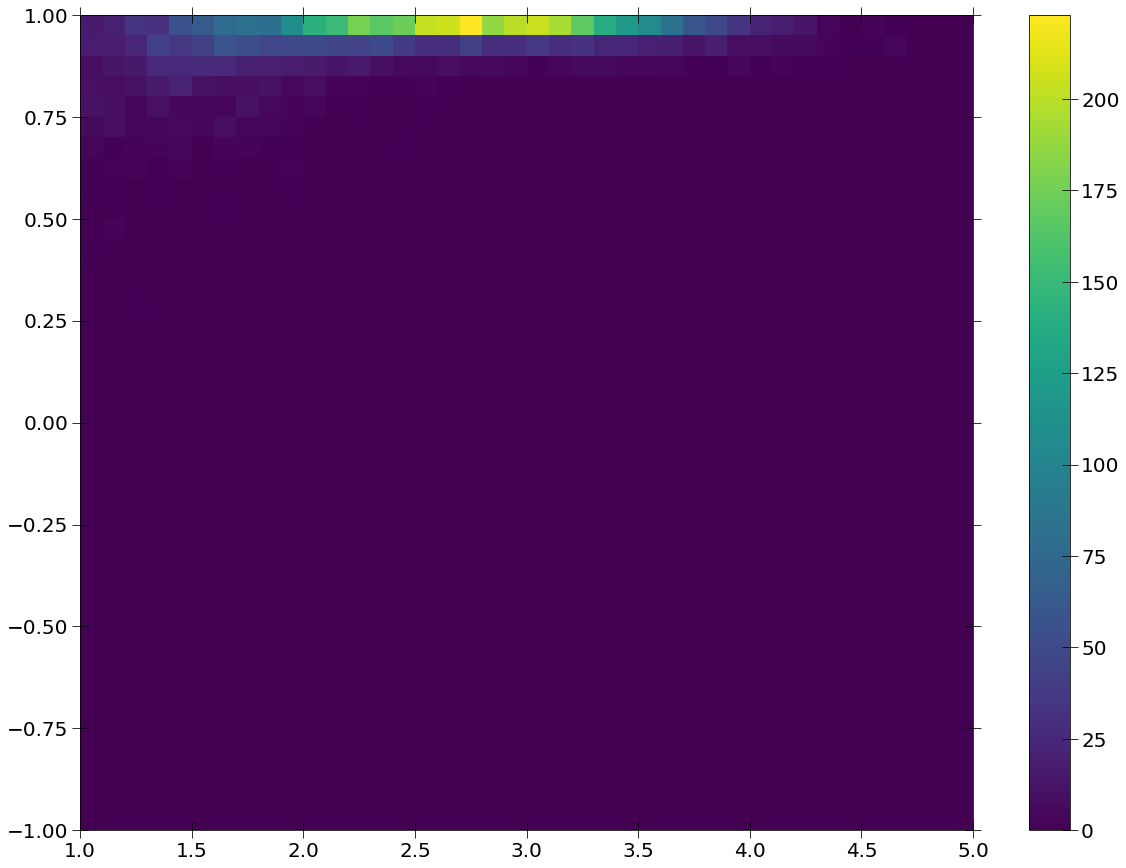

2:48: E225 missing whitespace around operator
3:80: E501 line too long (83 > 79 characters)


In [113]:
plt.hist2d(np.log10(netcounts3[2][0])[spec_summary['spec_masks'][0][2]],
           ((netcounts3[2][0]-netcounts4[2][0])/
            (netcounts3[2][0]+netcounts4[2][0]))[spec_summary['spec_masks'][0][2]],
           range=[[1, 5], [-1, 1]], bins=40)
plt.colorbar()

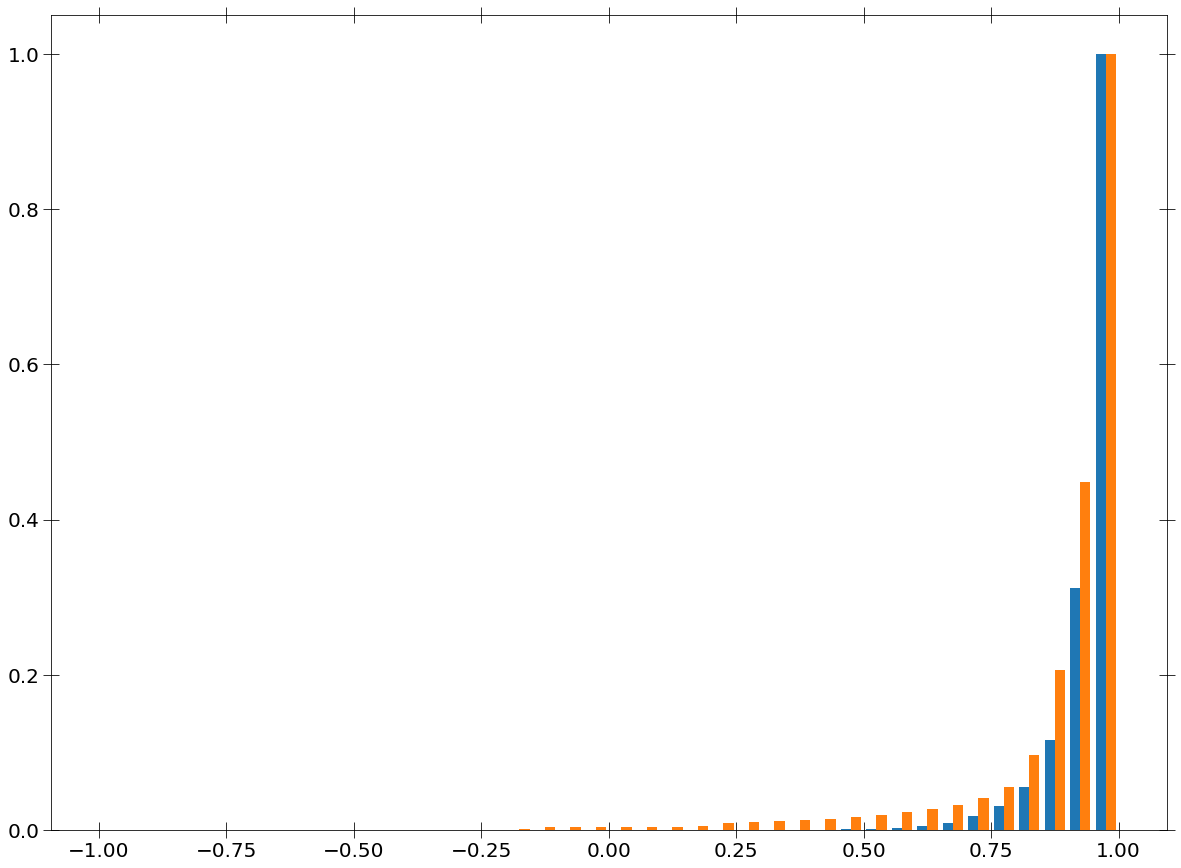

1:59: E225 missing whitespace around operator
2:80: E501 line too long (93 > 79 characters)
3:59: E225 missing whitespace around operator
4:80: E501 line too long (94 > 79 characters)


In [118]:
cdf, bins = plt.hist([((netcounts3[2][0]-netcounts4[2][0])/
                      (netcounts3[2][0]+netcounts4[2][0]))[spec_summary['spec_masks'][0][2]],
                      ((netcounts3[2][1]-netcounts4[2][1])/
                      (netcounts3[2][1]+netcounts4[2][1]))[spec_summary['spec_masks'][1][2]]],
                     range=(-1, 1), bins=40, cumulative=True, density=True)[:-1]

In [122]:
cdf

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.90077932e-04, 3.80155864e-04, 3.80155864e-04, 5.70233796e-04,
        7.60311728e-04, 1.52062346e-03, 1.90077932e-03, 2.85116898e-03,
        5.13210416e-03, 9.88405246e-03, 1.84375594e-02, 3.17430146e-02,
        5.60729899e-02, 1.16707850e-01, 3.12298042e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.27643785e-04, 9.27643785e-04,
        9.27643785e-04, 9.27643785e-04, 9.27643785e-04, 9.27643785e-04,
        9.27643785e-04, 9.27643785e-04, 9.27643785e-04, 9.27643

In [121]:
bins[1:][np.where(cdf[1] >= 0.1)]

array([0.9 , 0.95, 1.  ])

In [101]:
len(spec_summary['spec_masks'][0][0])

20000

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


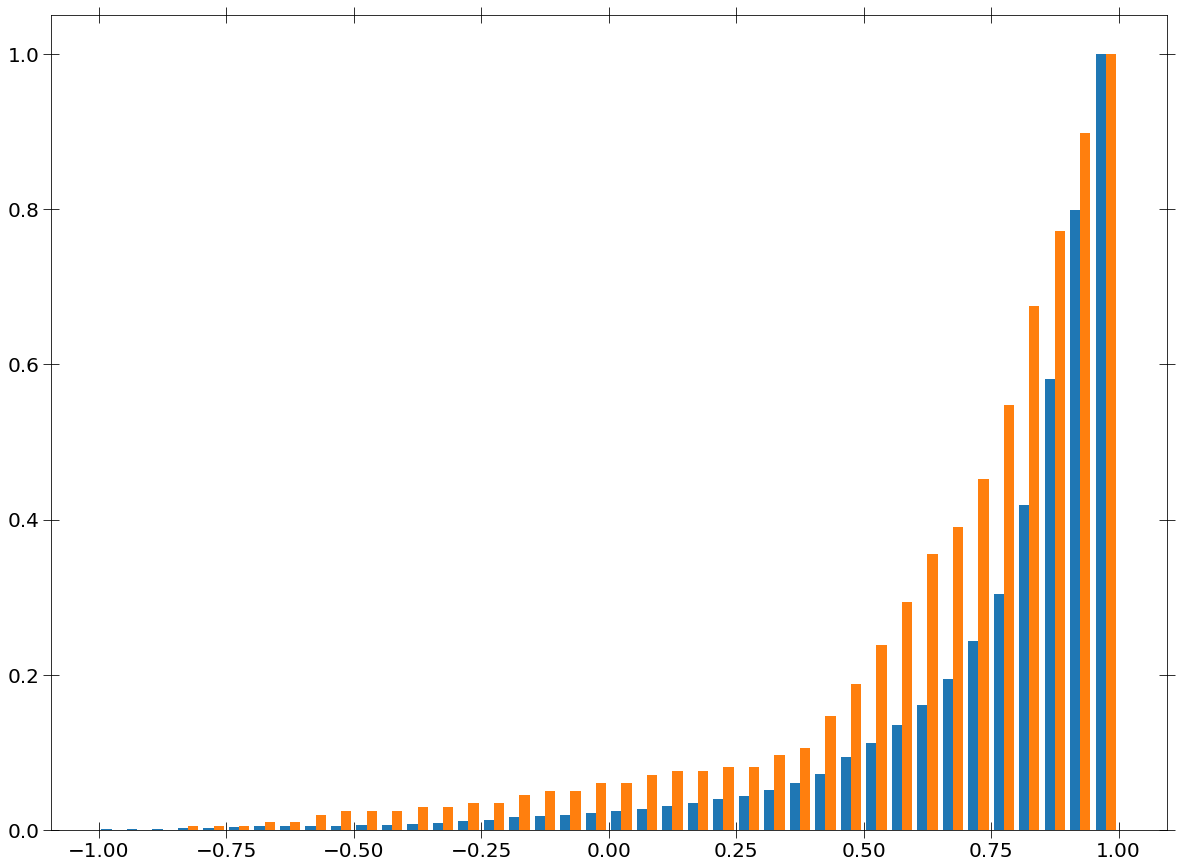

1:66: E225 missing whitespace around operator
2:80: E501 line too long (101 > 79 characters)
3:66: E225 missing whitespace around operator
4:80: E501 line too long (102 > 79 characters)
5:28: E128 continuation line under-indented for visual indent


In [128]:
cdf_mos, bins_mos = plt.hist([((netcounts[1][0]-netcounts2[1][0])/
                               (netcounts[1][0]+netcounts2[1][0]))[spec_summary['spec_masks'][0][1]],
                              ((netcounts[1][1]-netcounts2[1][1])/
                               (netcounts[1][1]+netcounts2[1][1]))[spec_summary['spec_masks'][1][1]]],
                           range=(-1, 1), bins=40, cumulative=True, density=True)[:-1]

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


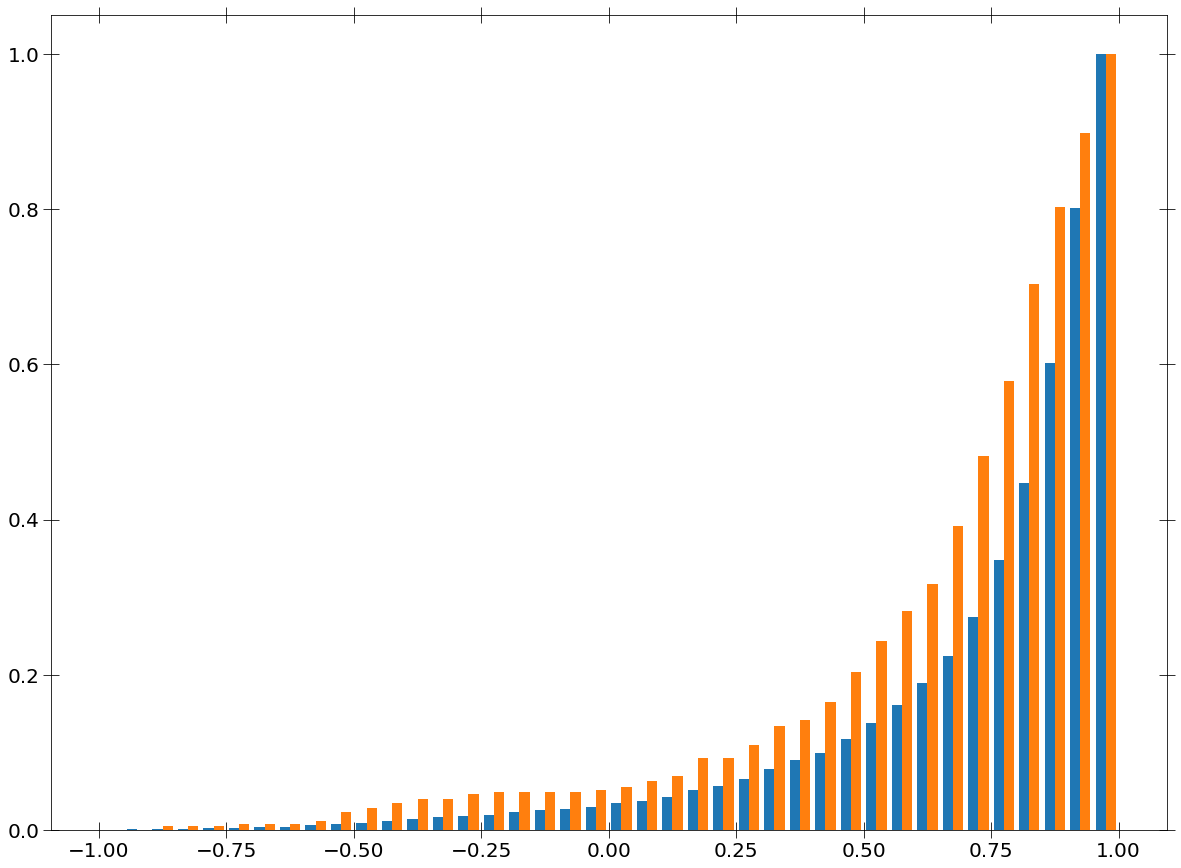

1:64: E225 missing whitespace around operator
2:80: E501 line too long (98 > 79 characters)
3:64: E225 missing whitespace around operator
4:80: E501 line too long (99 > 79 characters)


In [129]:
cdf_pn, bins_pn = plt.hist([((netcounts[0][0]-netcounts2[0][0])/
                            (netcounts[0][0]+netcounts2[0][0]))[spec_summary['spec_masks'][0][0]],
                            ((netcounts[0][1]-netcounts2[0][1])/
                            (netcounts[0][1]+netcounts2[0][1]))[spec_summary['spec_masks'][1][0]]],
                           range=(-1, 1), bins=40, cumulative=True, density=True)[:-1]

In [130]:
bins_pn

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  0.95,  1.  ])

In [131]:
cdf_pn

array([[7.00770848e-04, 1.05115627e-03, 1.05115627e-03, 1.75192712e-03,
        3.15346882e-03, 3.50385424e-03, 3.85423966e-03, 3.85423966e-03,
        6.30693763e-03, 7.70847933e-03, 9.81079187e-03, 1.22634898e-02,
        1.43658024e-02, 1.68185004e-02, 1.85704275e-02, 2.03223546e-02,
        2.41765943e-02, 2.62789068e-02, 2.73300631e-02, 2.97827610e-02,
        3.57393132e-02, 3.81920112e-02, 4.34477926e-02, 5.15066573e-02,
        5.71128241e-02, 6.65732306e-02, 7.95374912e-02, 9.00490540e-02,
        9.95094604e-02, 1.17729502e-01, 1.38402242e-01, 1.61527680e-01,
        1.89558514e-01, 2.24947442e-01, 2.75052558e-01, 3.48633497e-01,
        4.47442186e-01, 6.01261388e-01, 8.01331465e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.81395349e-03, 5.81395349e-03,
        5.81395349e-03, 8.72093023e-03, 8.72093023e-03, 8.72093023e-03,
        1.16279070e-02, 2.32558140e-02, 2.90697674e-02, 3.48837209e-02,
        4.06976744e-02, 4.06976744e-02, 4.65116279e-02, 4.94186

In [135]:
bins_pn[1:][np.where(cdf_mos[0] >= 0.1)]

array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

4488 4488 4488 4488
504 504 504 504
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: Runti

2358 2358 2358 2358
292 292 292 292
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7337 7337 7337 7337
2064 2064 2064 2064
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


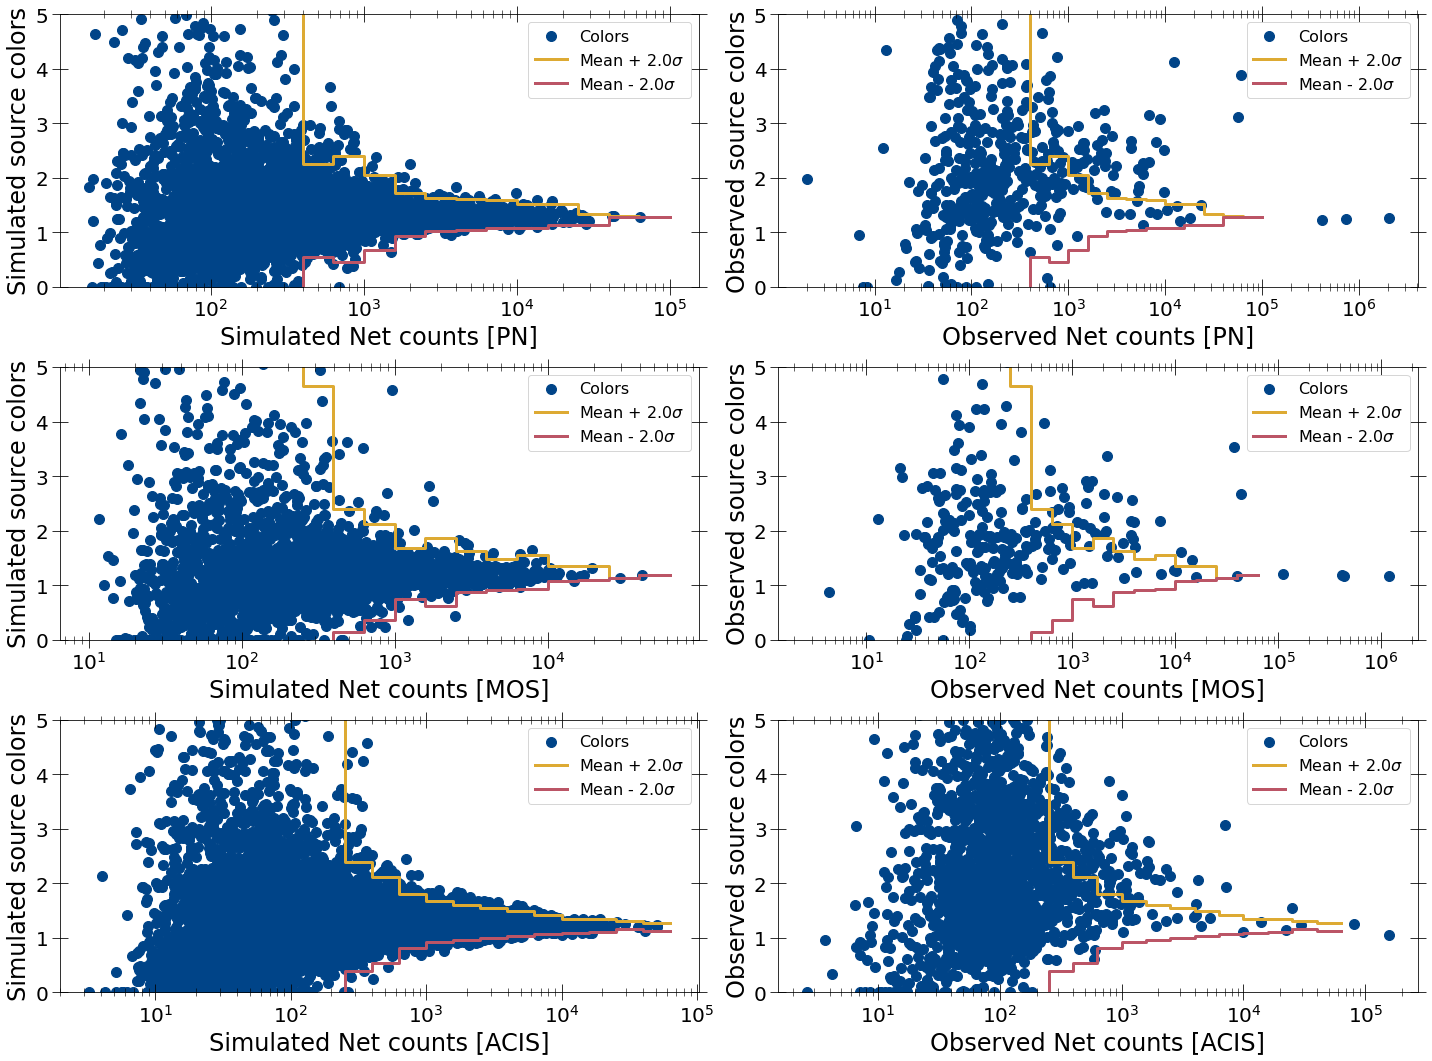

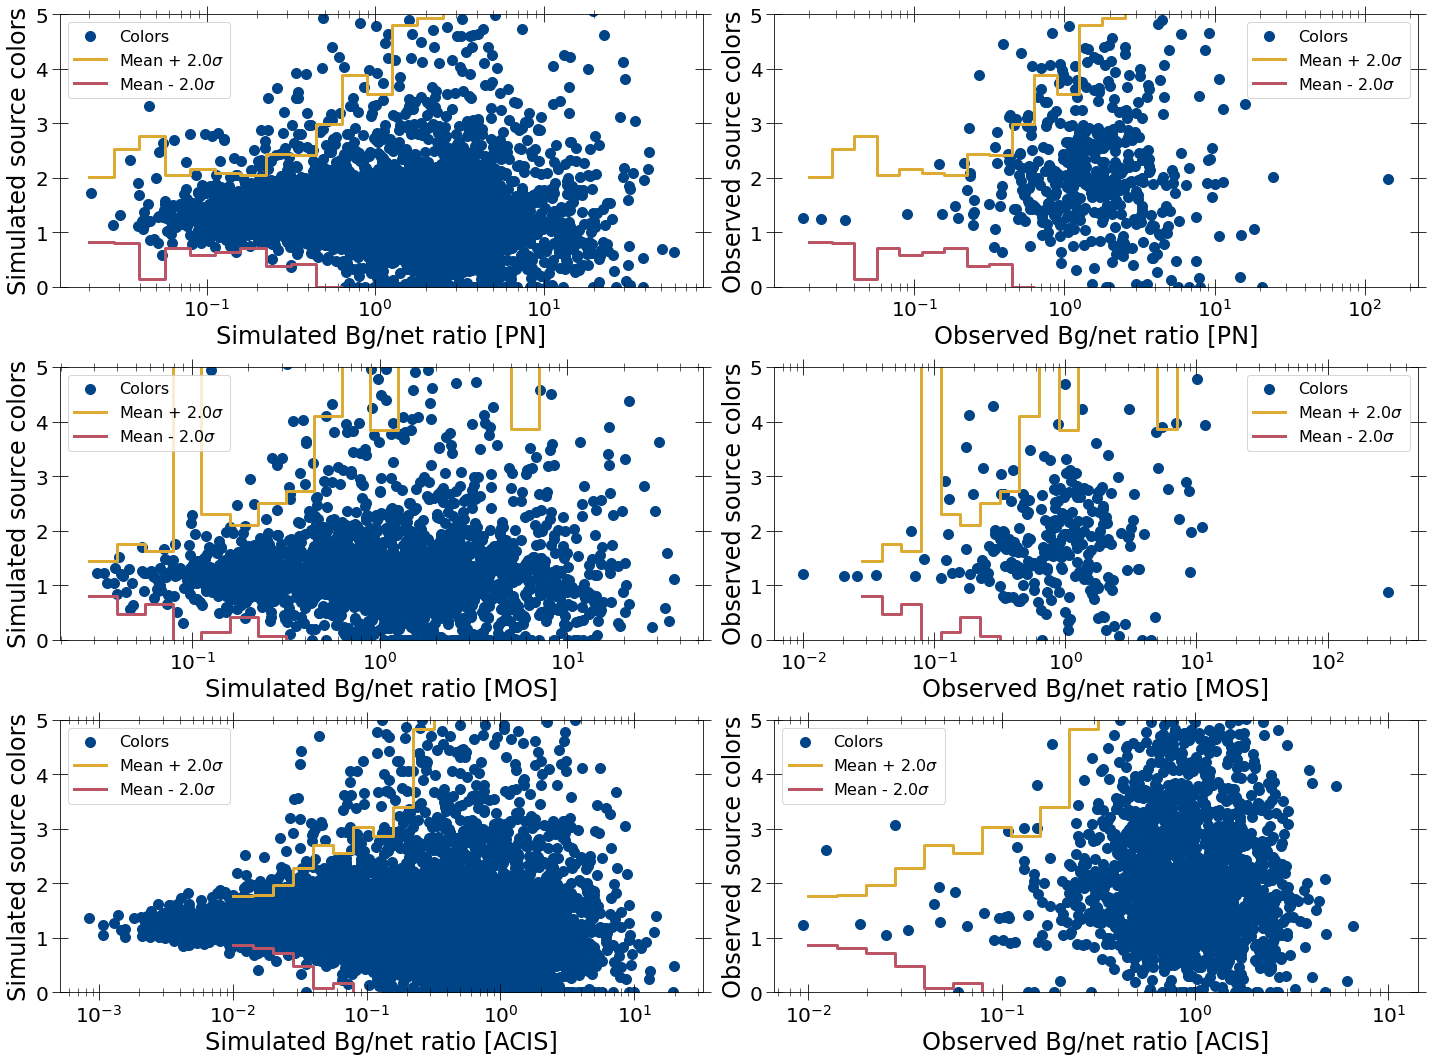

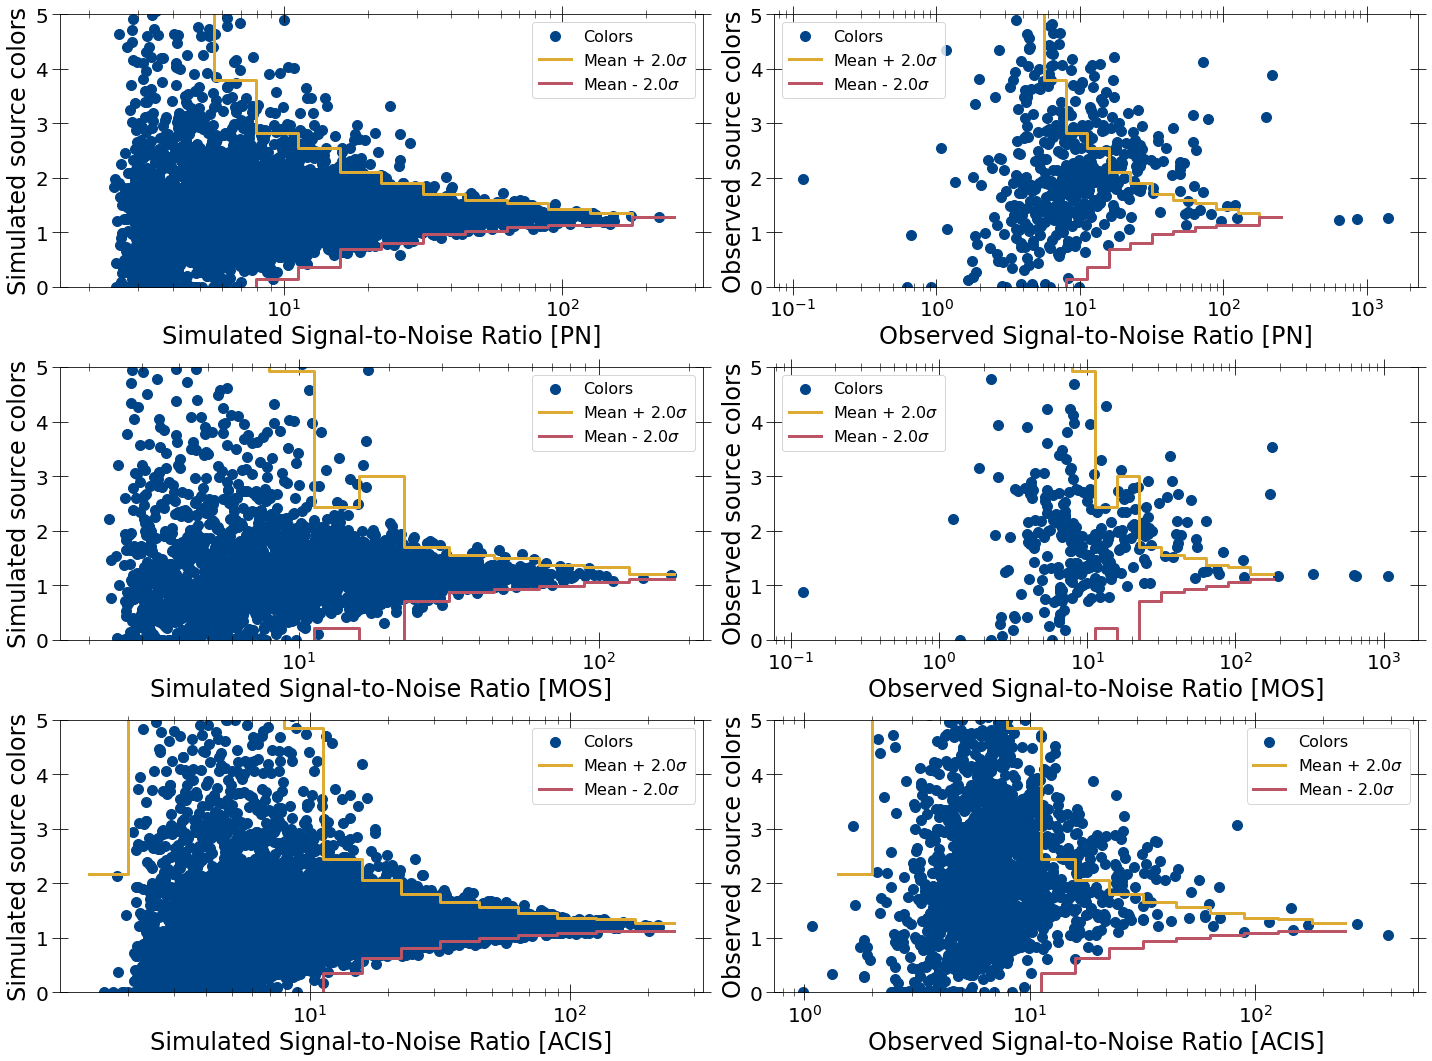

In [51]:
sim_color_dict_arr_clipped, obs_color_dict_arr_clipped = getcolor_prop_alldet(spec_summary, compare_det=True)

4488 4488 4488 4488
504 504 504 504
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


2358 2358 2358 2358
292 292 292 292
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7337 7337 7337 7337
2064 2064 2064 2064
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


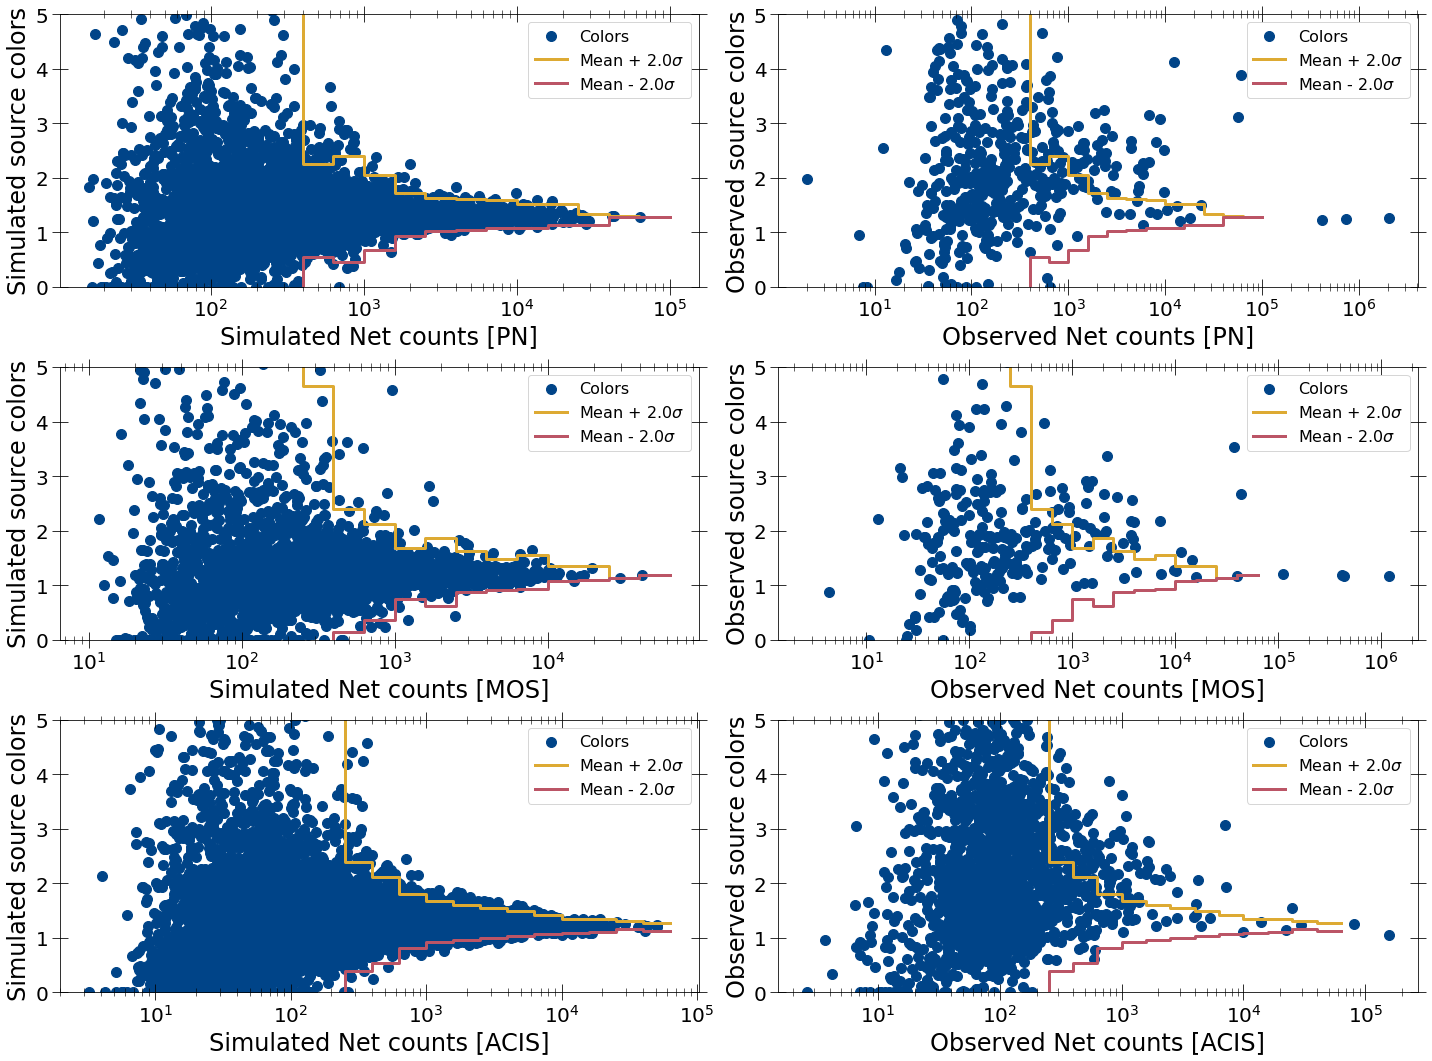

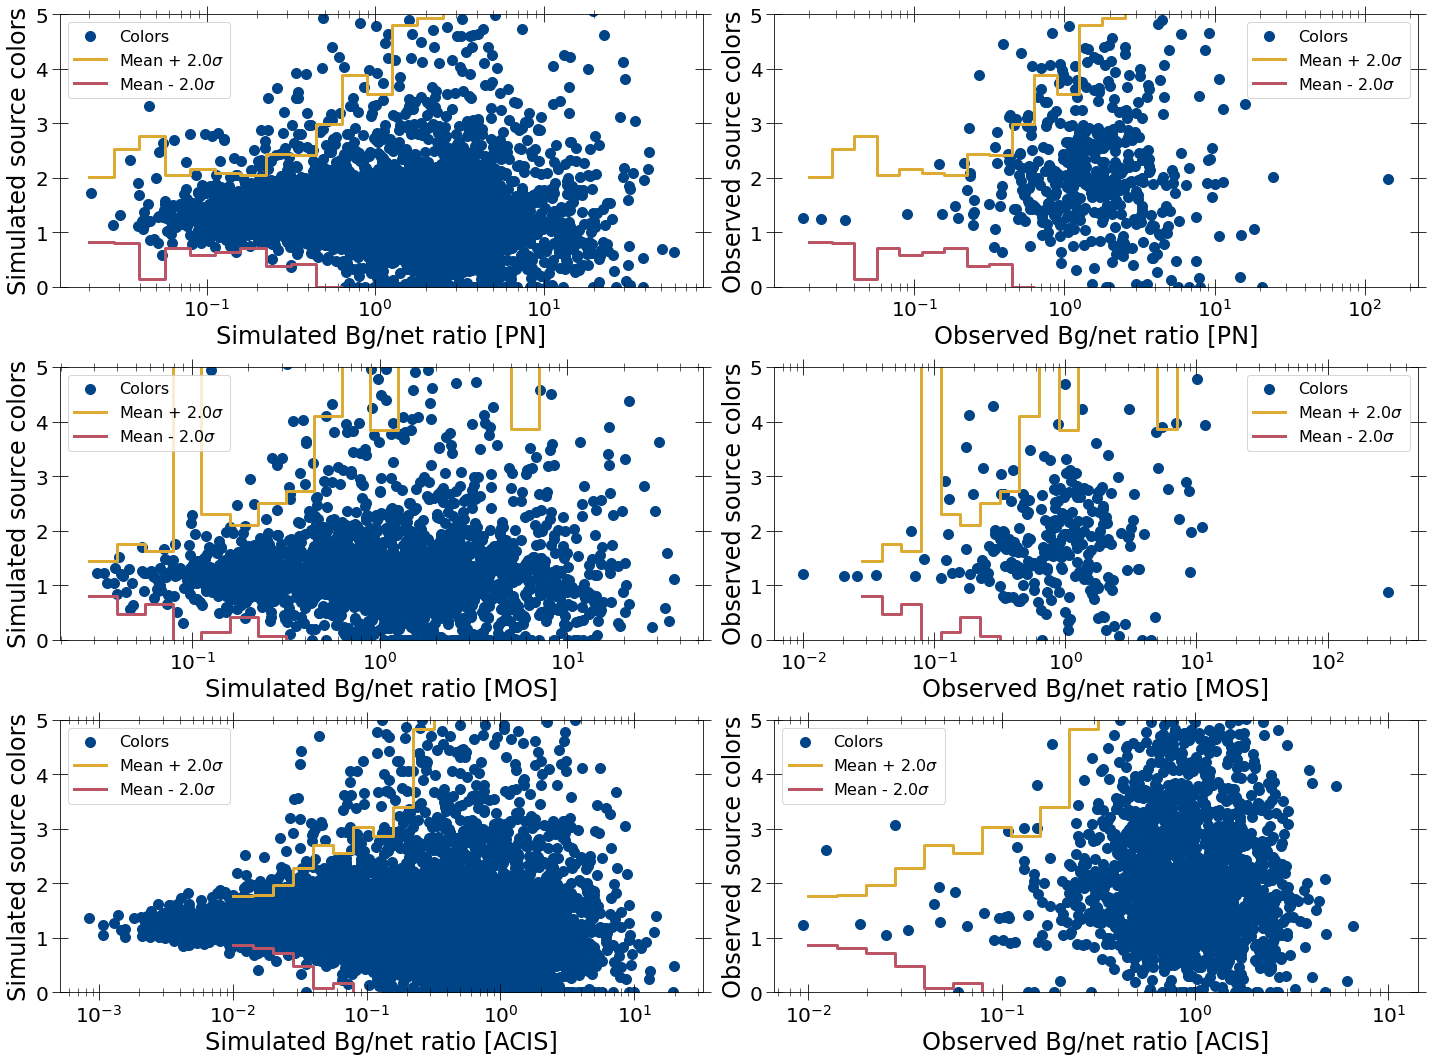

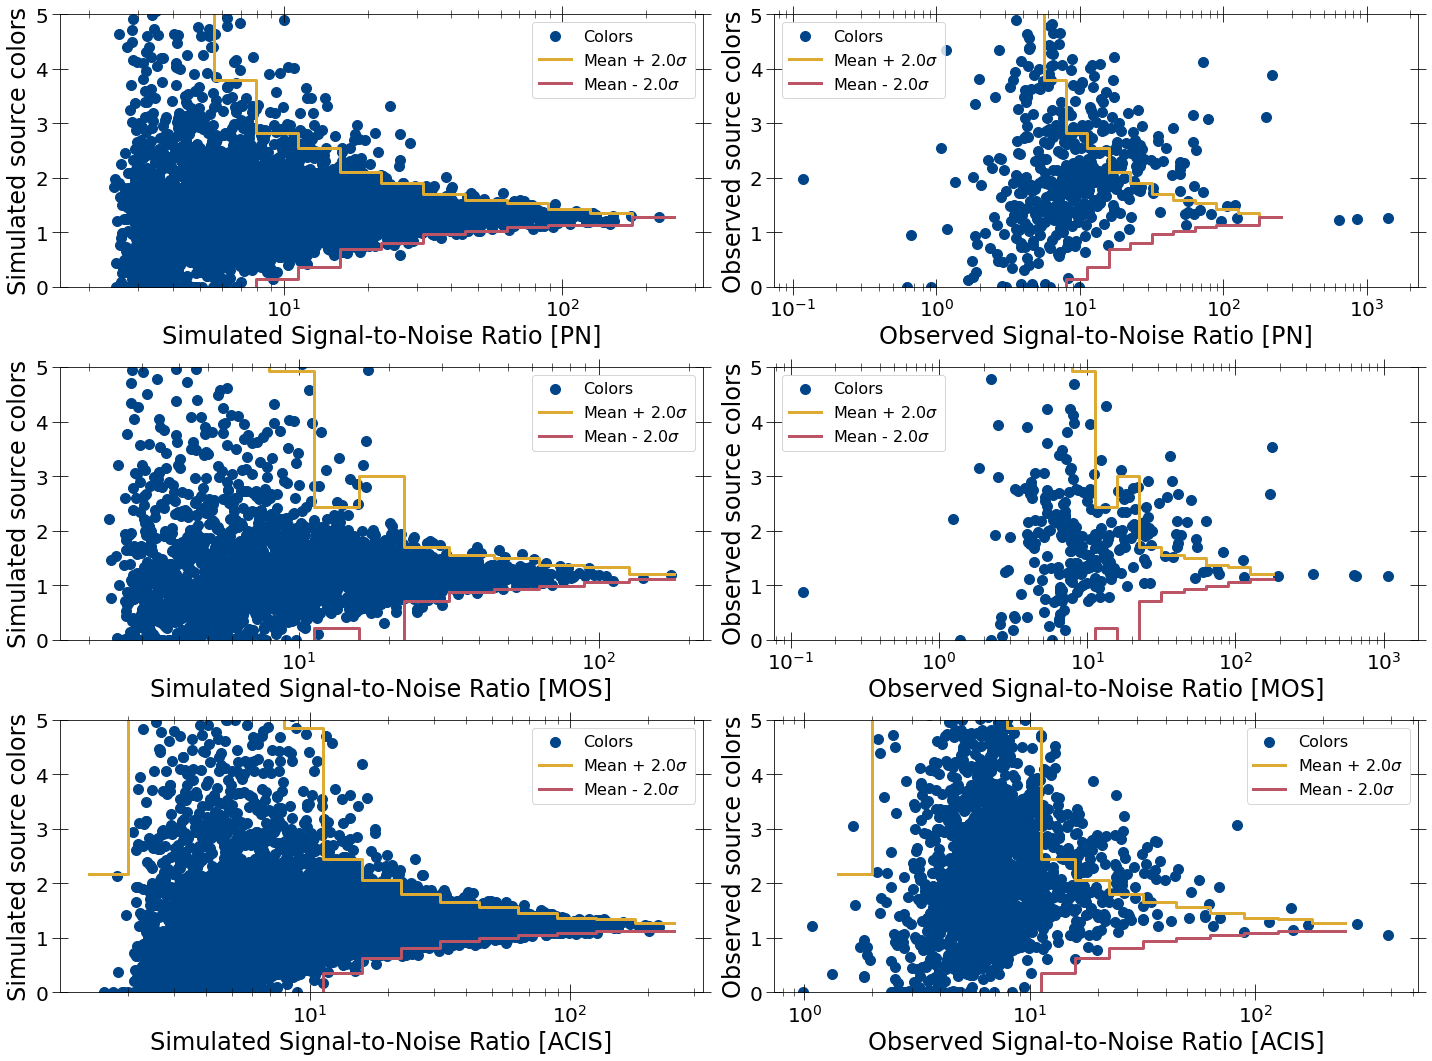

In [52]:
sim_color_dict_arr, obs_color_dict_arr = getcolor_prop_alldet(spec_summary, compare_det=True)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


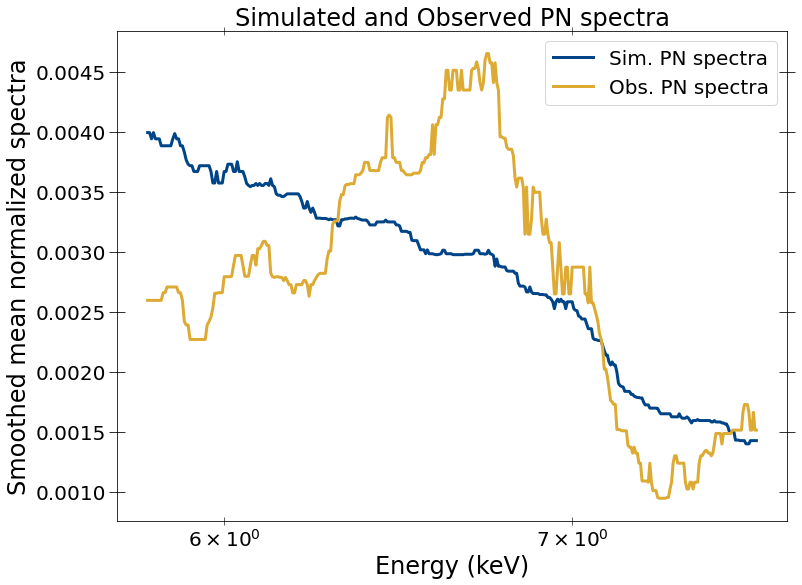

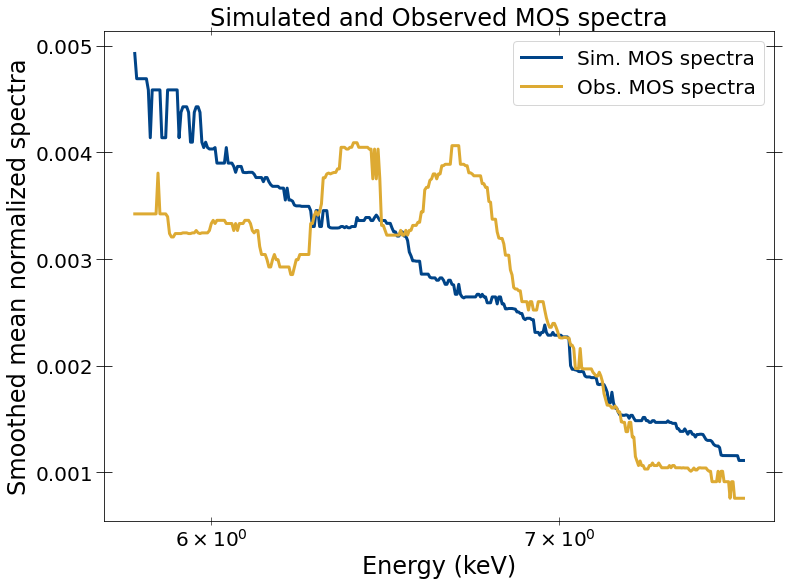

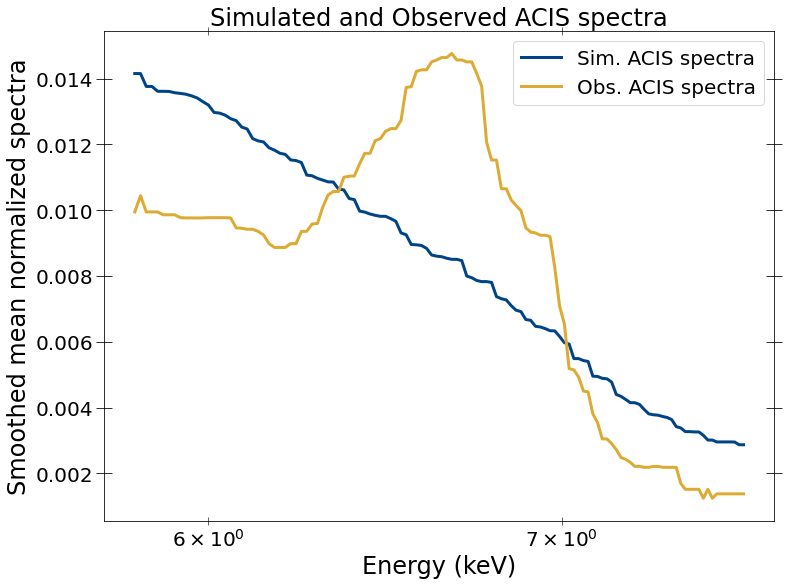

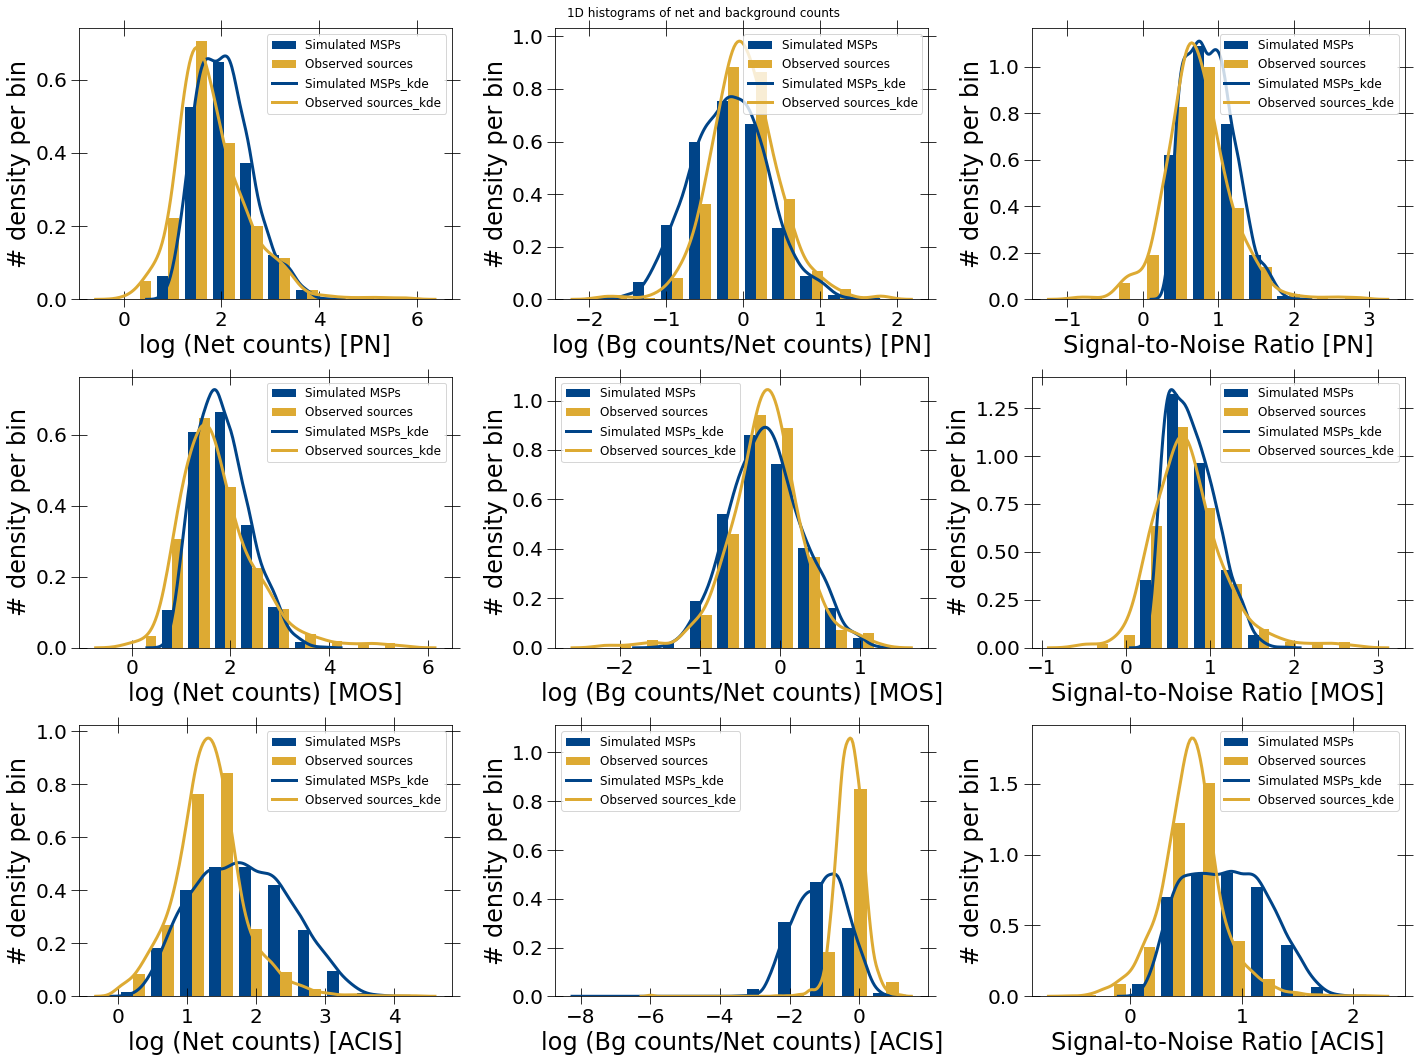

In [53]:
spec_summary2 = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[5.8, 7.6])

3870 3870 3870 3870
503 503 503 503
Calaculating mean and standard deviation in colors vs. Net counts


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
1825 1825 1825 1825
290 290 290 290
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
6563 6563 6563 6563
2009 2009 2009 2009
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


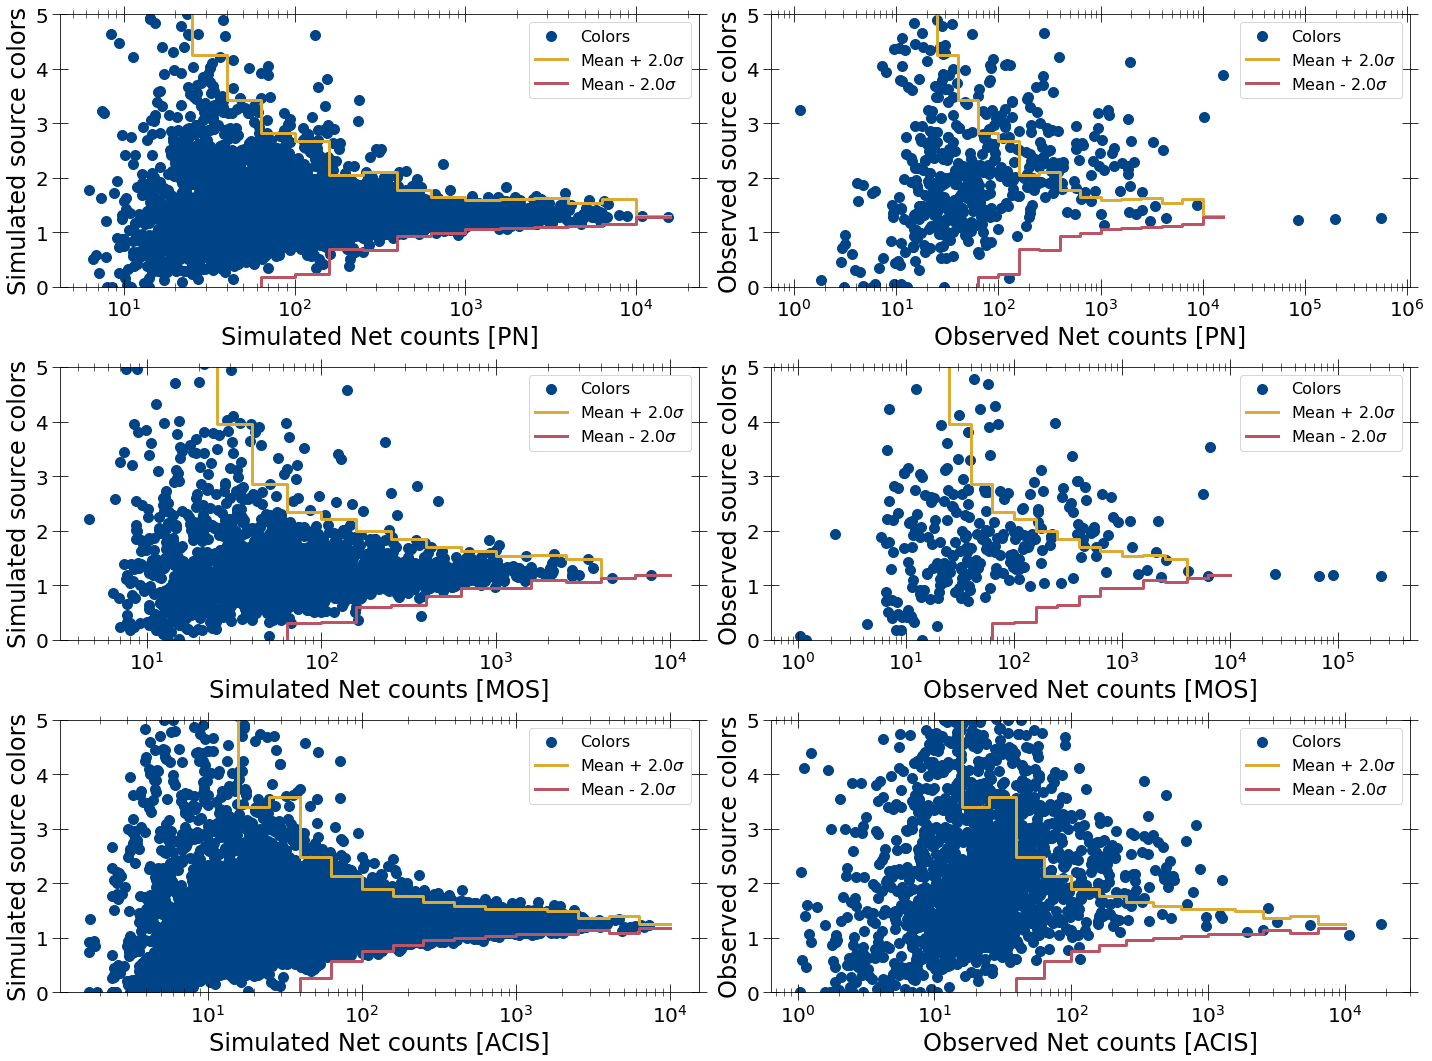

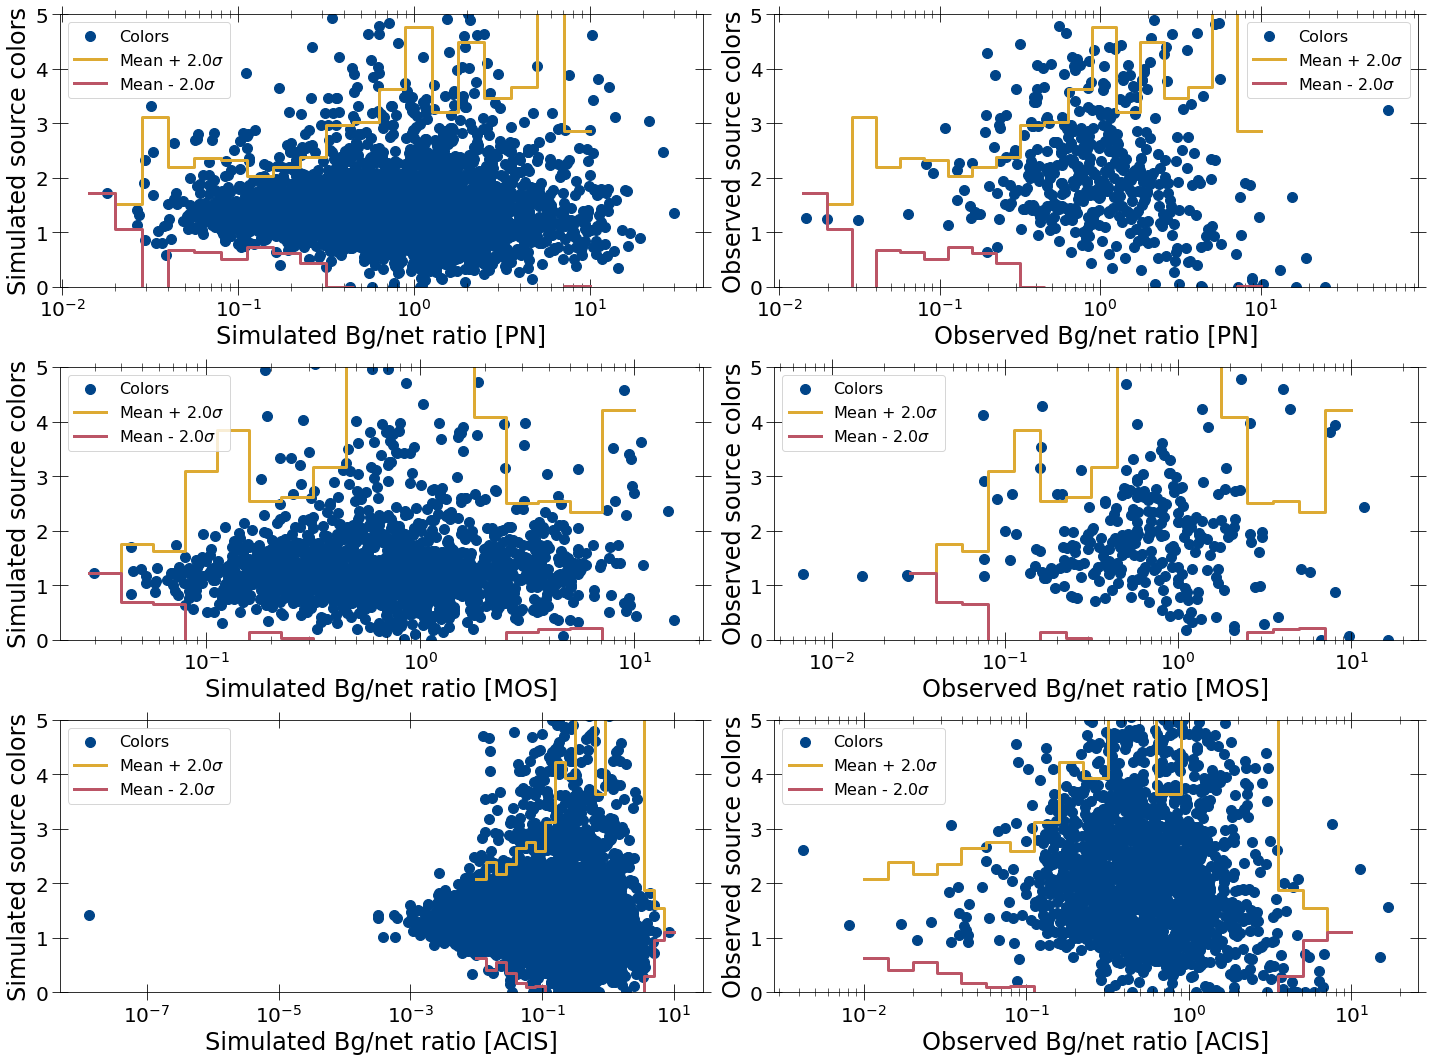

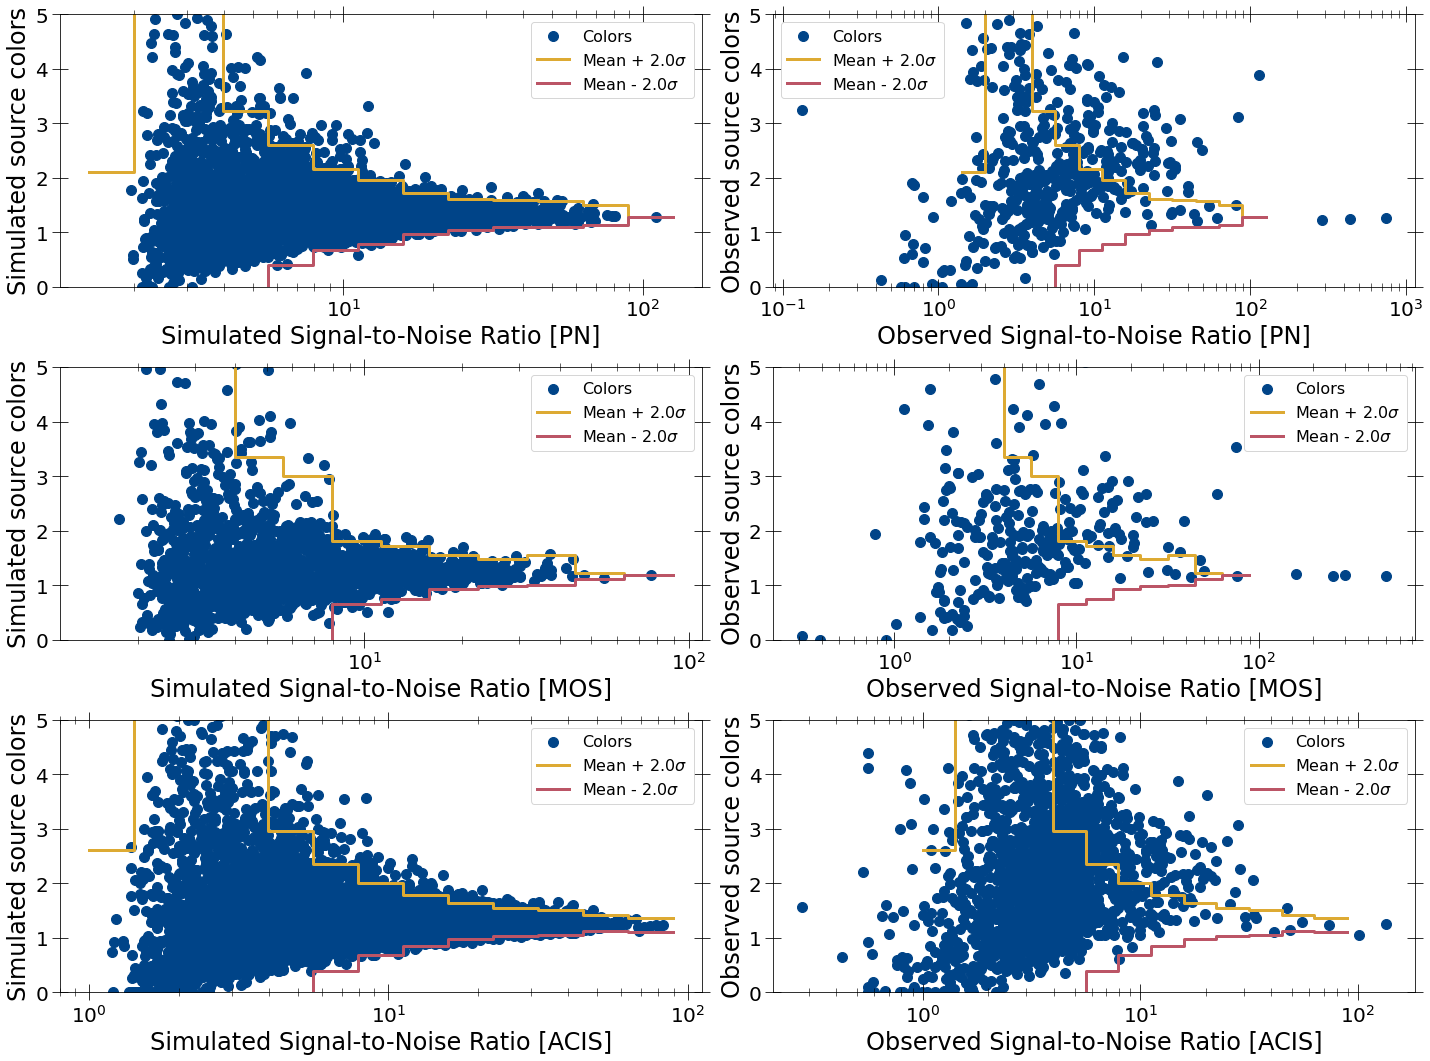

In [56]:
sim_color_dict_arr2, obs_color_dict_arr2 = getcolor_prop_alldet(spec_summary2, compare_det=True)

In [57]:
def get_candidate_src_nums_det(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    print(netcount_bins)
    print(color_median)
    print(color_std)
    interested_args = None
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        print(lower_bin, median_color + 2*std_color)
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(len(int_args))
        if interested_args is None:
            interested_args = int_args.copy()
        else:
            interested_args = np.append(interested_args.copy(), int_args)
    return interested_args, obs_src_nums[obs_det_mask][interested_args]


def get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


26:21: E117 over-indented
30:1: W293 blank line contains whitespace
59:80: E501 line too long (80 > 79 characters)
63:13: E122 continuation line missing indentation or outdented
64:13: E122 continuation line missing indentation or outdented


In [58]:
interested_args_alldet2, interested_srcs_alldet2 = get_candidate_src_nums_alldet(spec_summary2, sim_color_dict_arr2,
                              obs_color_dict_arr2, min_count_arr=[100, 100, 60])

[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[2.00871979 1.92206191 1.65202105 1.55084711 1.49920838 1.45287774
 1.37842076 1.39013041 1.3549527  1.32053597 1.3277049  1.34477512
 1.36440991 1.32344936 1.38813392 1.29134765        nan        nan
        nan        nan]
[2.15764413 2.21794632 1.29539604 0.93399586 0.66160574 0.6122573
 0.33875086 0.35861227 0.20954657 0.1665736  0.13145494 0.13485116
 0.13204202 0.10544924 0.1155218  0.00488405        nan        nan
        nan        nan]
100.0 2.6773923460617164
20
158.48931924611142 2.055922483418187
14
251.18864315095823 2.1073549523080675
8
398.1071705534973 1.7740458432939565
2
630.957344480193 1.6536831641645064
2
1000.0 1.5906147820026582
2
1584.89319246111

1:80: E501 line too long (116 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


In [59]:
interested_args_alldet, interested_srcs_alldet = get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                              obs_color_dict_arr, min_count_arr=[380, 380, 220])

1:80: E501 line too long (112 > 79 characters)


[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[       nan 1.8438323  4.28587101 2.57293297 2.62079335 1.72971698
 1.60431219 1.74073868 1.39936836 1.42139415 1.35769686 1.31995169
 1.32216643 1.32350378 1.33359872 1.30127259 1.3196426  1.23300753
 1.2935751  1.2864636 ]
[           nan 3.81120767e+00 2.34138054e+01 6.14832412e+00
 9.81027935e+00 2.12106946e+00 2.31766286e+00 5.83359815e+00
 4.24177855e-01 4.84833254e-01 3.45072200e-01 1.97362975e-01
 1.50927320e-01 1.39241279e-01 1.30237171e-01 1.07906152e-01
 9.74004321e-02 4.97312722e-02 2.65660043e-03 0.00000000e+00]
398.1071705534973 2.2477240730404895
18
630.957344480193 2.3910606623717743
18
1000.0 2.0478412596523614
6
1584.893192461114 1.7146776386488467
2
2

2:31: E128 continuation line under-indented for visual indent


In [60]:
np.sort(interested_srcs_alldet[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010154', '201113501010169', '201113503010004',
       '201129701010011', '201129701010015', '201129701010027',
       '201129701010041', '201129702010002', '201129704010011',
       '201129704010019', '201129704010027', '201129704010048',
       '201129705010011', '201129705010015', '201129705010038',
       '201129705010067', '201129705010076', '201129705010079',
       '201129705015062', '201129706010014', '201129707010012',
       '201129707010063', '201129707010079', '201129709010024',
       '201129715010041', '201129719010010', '201129721010003',
       '201129721010009', '201129721010014', '201129721010022',
       '201129721010034', '201129721010035', '201129721010044',
       '201129721010057', '201129721010060', '201129721010063',
       '201129721010070', '201129721010078', '201129721010126',
       '201129721010133', '201129721015131', '202026705010034',
       '202026705010109', '2020267080100

In [61]:
np.sort(interested_srcs_alldet2[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010122', '201113501010148', '201113501010154',
       '201113501010169', '201113501015161', '201113503010004',
       '201129701010011', '201129701010027', '201129702010002',
       '201129702010029', '201129702010049', '201129704010019',
       '201129704010027', '201129705010011', '201129705010015',
       '201129705010038', '201129705010067', '201129705010076',
       '201129705010079', '201129705015062', '201129706010014',
       '201129707010002', '201129707010012', '201129707010033',
       '201129707010048', '201129707010063', '201129715010041',
       '201129715010042', '201129715010047', '201129719010010',
       '201129721010003', '201129721010005', '201129721010009',
       '201129721010014', '201129721010034', '201129721010044',
       '201129721010060', '201129721010063', '201129721010070',
       '201129721010078', '201129721010090', '201129721010126',
       '201129721010133', '2020267050100

In [62]:
def mark_interested_srcs(sim_color_dict, obs_color_dict, src_nums, obs_mask,
                         interested_srcs, prop_num=0):
    props = obs_color_dict['prop_list'][prop_num]
    colors = obs_color_dict['colors']
    interested_args = np.where(np.isin(src_nums[obs_mask], interested_srcs))
    print(interested_args)
    prop_bins = sim_color_dict['prop_bins'][prop_num]
    mean_color = sim_color_dict['color_stat'][0][prop_num]
    std_color = sim_color_dict['color_stat'][2][prop_num]
    plotline_scatter([props, props[interested_args], prop_bins, prop_bins],
                     [colors, colors[interested_args], mean_color + 2*std_color,
                      mean_color - 2*std_color],
                     pl_types=['scatter', 'scatter', 'step', 'step'],
                     xlabel='Net counts', ylabel='Colors',
                     pl_labels=['Colors', 'Colors (candidates)',
                                r'Mean + 2$\sigma$', r'Mean + 2$\sigma$'],
                     ylim=(0, 5))

11:80: E501 line too long (80 > 79 characters)


In [23]:
np.where(spec_summary['src_nums'][0] == )

SyntaxError: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)

1:40: E202 whitespace before ')'
41: E999 SyntaxError: invalid syntax


Error before execution: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)


(array([  7,   9,  10,  20,  22,  24,  29,  34,  35,  38,  43,  50,  57,
        60,  67,  71,  91,  93,  98, 108, 110, 111, 117, 121, 122, 127,
       140, 148, 152, 186, 187, 188, 192, 195, 196, 197, 198, 203, 206,
       213, 214, 218, 221, 223, 229, 231, 240, 266, 273, 275, 304, 335,
       339, 342, 354, 414, 451, 464, 481]),)


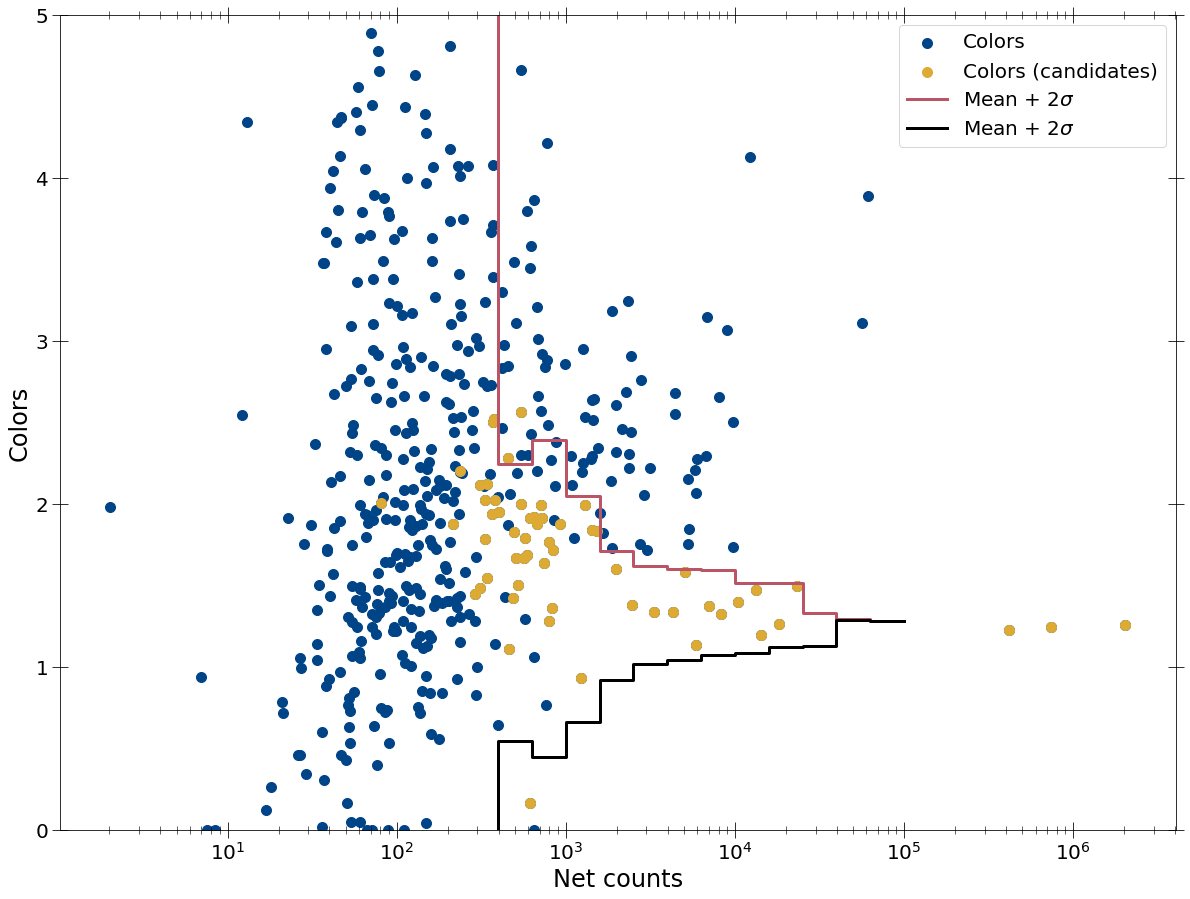

2:80: E501 line too long (83 > 79 characters)


In [63]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     interested_srcs_alldet2[0], 0)

(array([  2,   3,  21,  31,  33,  45,  59,  66,  67,  71,  72,  81,  84,
        86,  89,  93,  98, 101, 103, 123, 125, 126, 129, 130, 133, 136,
       137, 139, 144, 146, 149, 152, 196, 198, 223, 229, 246, 254, 280]),)


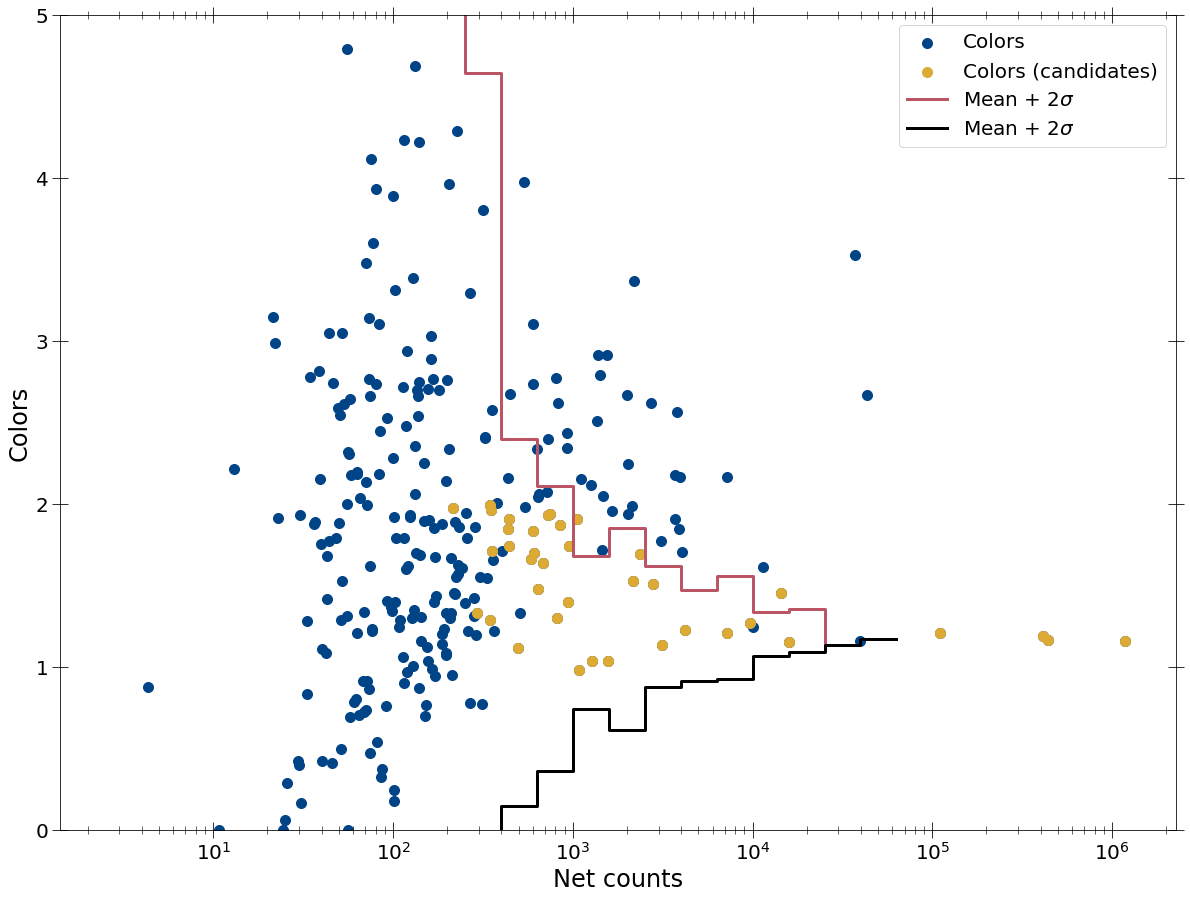

2:80: E501 line too long (83 > 79 characters)


In [64]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     interested_srcs_alldet2[1], 0)

In [26]:
len(interested_srcs_alldet[0])

58

(array([   1,    2,   63,   74,   82,  102,  133,  137,  156,  157,  162,
        234,  242,  249,  278,  282,  321,  345,  358,  376,  396,  401,
        416,  420,  453,  483,  500,  572,  622,  666,  674,  679,  685,
        709,  731,  733,  764,  780,  788,  797,  831,  840,  842,  849,
        883,  900,  910,  936,  945,  949,  951,  957,  961,  977,  990,
       1006, 1012, 1028, 1037, 1105, 1146, 1254, 1263, 1278, 1295, 1325,
       1388, 1394, 1408, 1422, 1424, 1429, 1507, 1522, 1527, 1562, 1571,
       1575, 1590, 1633, 1638, 1640, 1647, 1650, 1656, 1659, 1673, 1678,
       1741, 1756, 1767, 1793, 1827, 1863, 1885, 1901, 1934, 1944, 1956,
       1980, 2041]),)


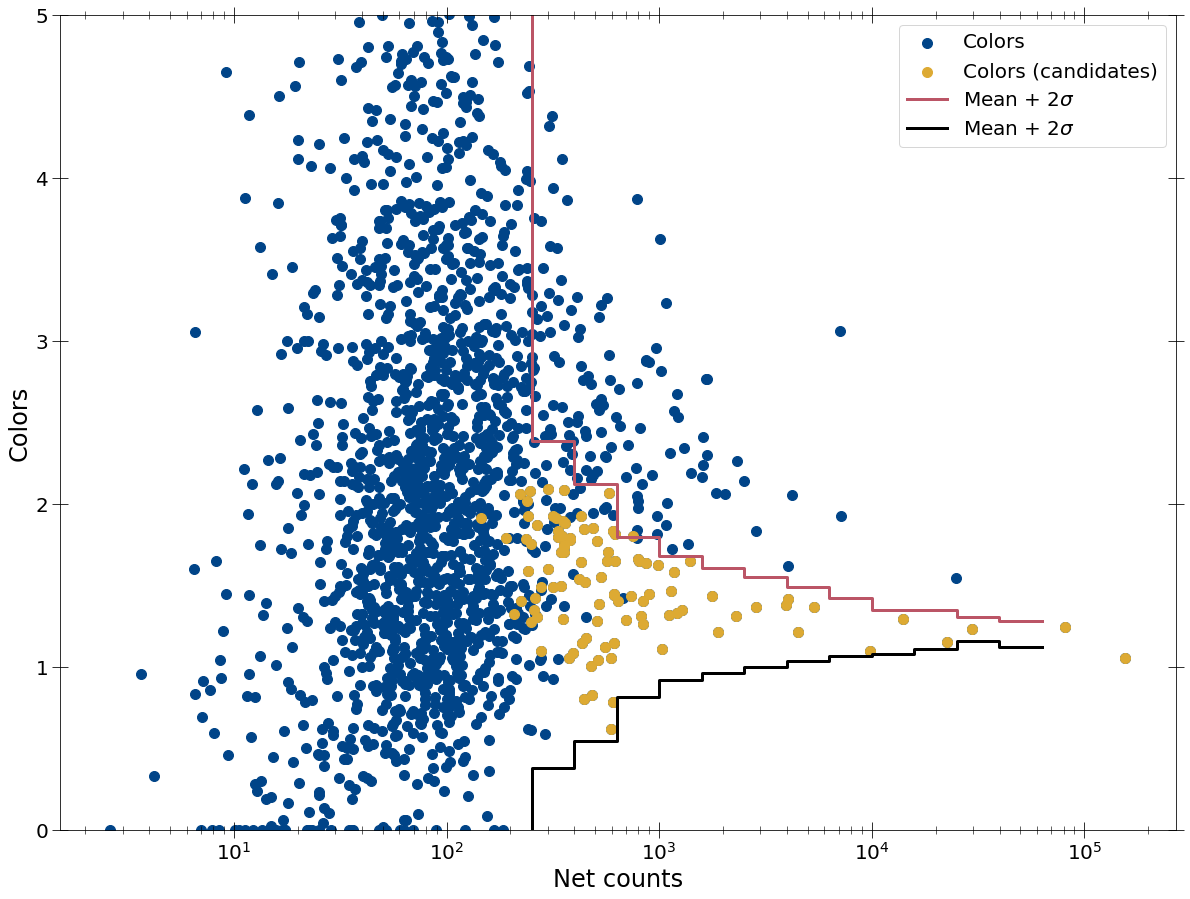

2:80: E501 line too long (83 > 79 characters)


In [65]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     interested_srcs_alldet2[2], 0)

In [28]:
source_nums = np.loadtxt('Interested_sources.txt', dtype='object')

(array([ 24,  38,  43,  50,  75,  91,  98, 111, 121, 127, 140, 152, 187,
       191, 192, 195, 206, 211, 213, 223, 229, 240, 273, 308, 309, 311,
       441, 464, 465, 467, 481, 483]),)


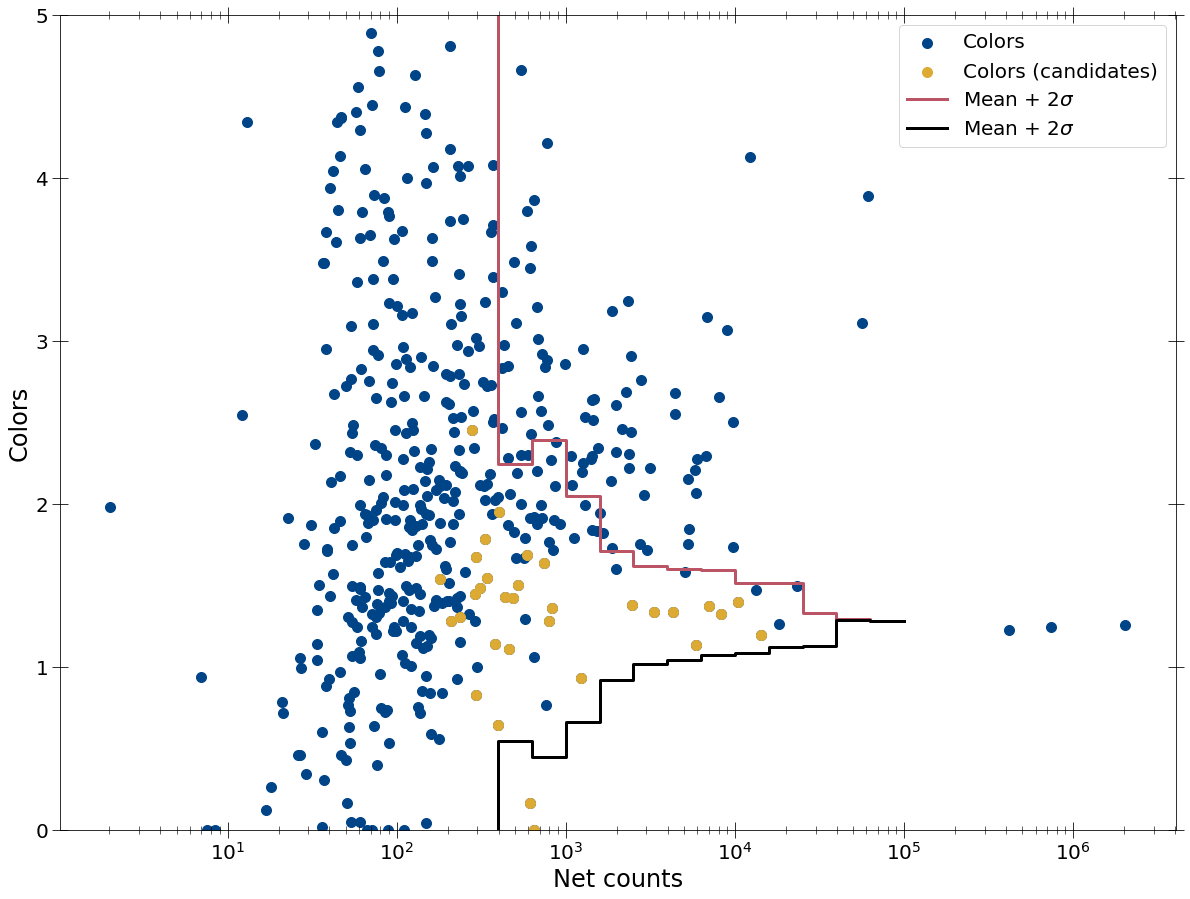

2:80: E501 line too long (83 > 79 characters)


In [29]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     source_nums, 0)

(array([ 16,  24,  29,  33,  55,  66,  72,  84,  93,  97, 103, 119, 122,
       123, 125, 134, 137, 139, 157, 171, 183, 184, 185, 220, 224, 225,
       226, 229, 231]),)


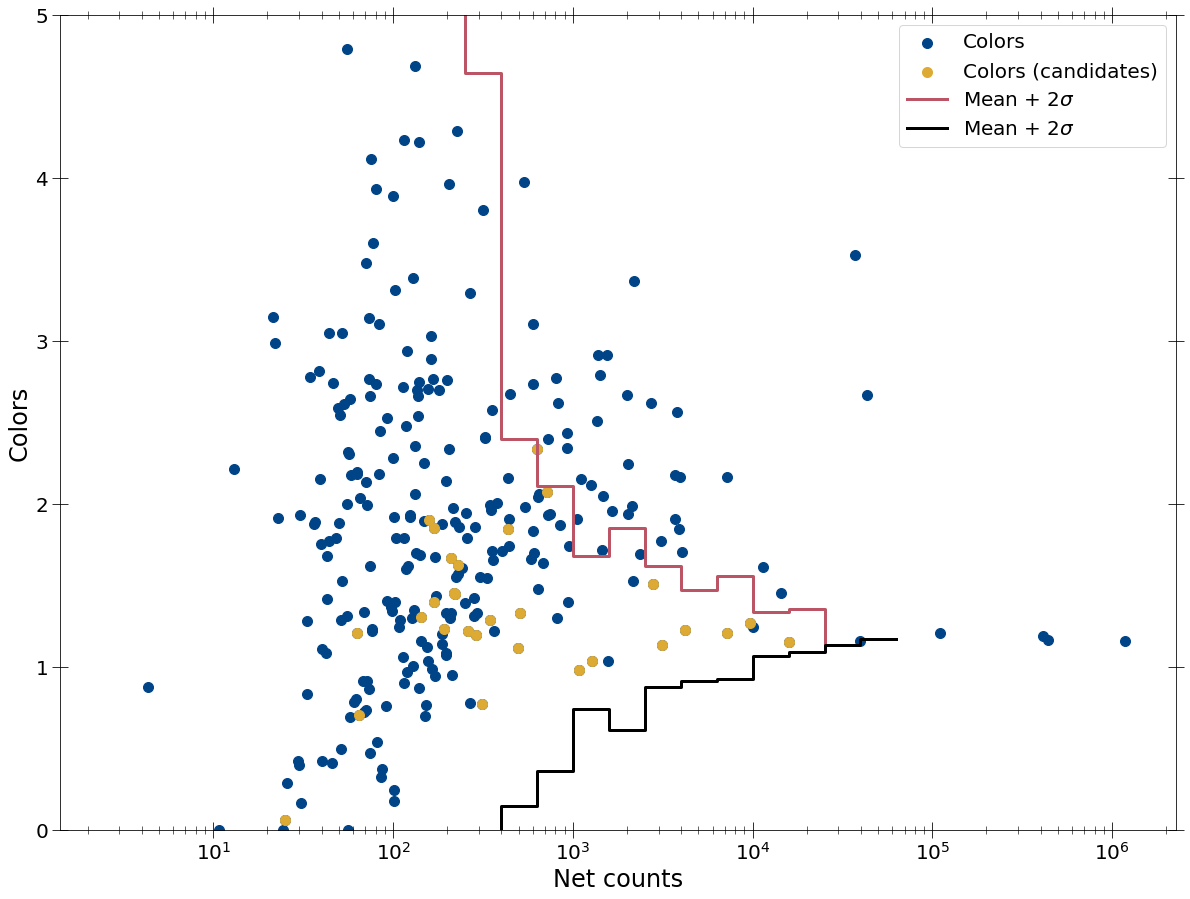

2:80: E501 line too long (83 > 79 characters)


In [30]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     source_nums, 0)

## def unmask_arr(masked_values, mask, filler=-100.0):
    unmasked_arr = np.ones(len(mask), dtype=float)*filler
    unmasked_arr[mask] = masked_values
    return unmasked_arr

In [23]:
print('MOS sources not detected in PN')
mos_not_pn = []
for src in interested_srcs_alldet[1]:
    if src not in interested_srcs_alldet[0]:
        mos_not_pn.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

MOS sources not detected in PN
Source:  201129705010014
Net counts (PN):  [1984.88629568]
Net counts (MOS):  [608.05064636]
Bg counts (PN):  [2078.11370432]
Bg counts (MOS):  [524.94935364]


IndexError: list index out of range

14:80: E501 line too long (113 > 79 characters)


In [395]:
print('PN sources not detected in MOS')
pn_not_mos = []
for src in interested_srcs_alldet[0]:
    if src not in interested_srcs_alldet[1]:
        pn_not_mos.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

PN sources not detected in MOS
Source:  201113501010066
Net counts (PN):  [569.59489915]
Net counts (MOS):  [77.06422098]
Bg counts (PN):  [1054.40510085]
Bg counts (MOS):  [132.93577902]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.67109356]
Color (MOS):  [3.60388168]
Source:  201113501010154
Net counts (PN):  [404.91355624]
Net counts (MOS):  [169.29402981]
Bg counts (PN):  [769.08644376]
Bg counts (MOS):  [251.70597019]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.95526699]
Color (MOS):  [1.4032798]
Source:  201129701010015
Net counts (PN):  [452.26180445]
Net counts (MOS):  [80.75597502]
Bg counts (PN):  [476.73819555]
Bg counts (MOS):  [149.24402498]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.87554681]
Color (MOS):  [2.73833179]
Source:  201129704010011
Net counts (PN):  [465.79990524]
Net counts (MOS):  [287.22584027]
Bg counts (PN):  [836.20009476]
Bg counts (MOS):  [147.77415973]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [2.0655

14:80: E501 line too long (113 > 79 characters)


In [396]:
len(mos_not_pn)

18

In [397]:
len(pn_not_mos)

37

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

8.0


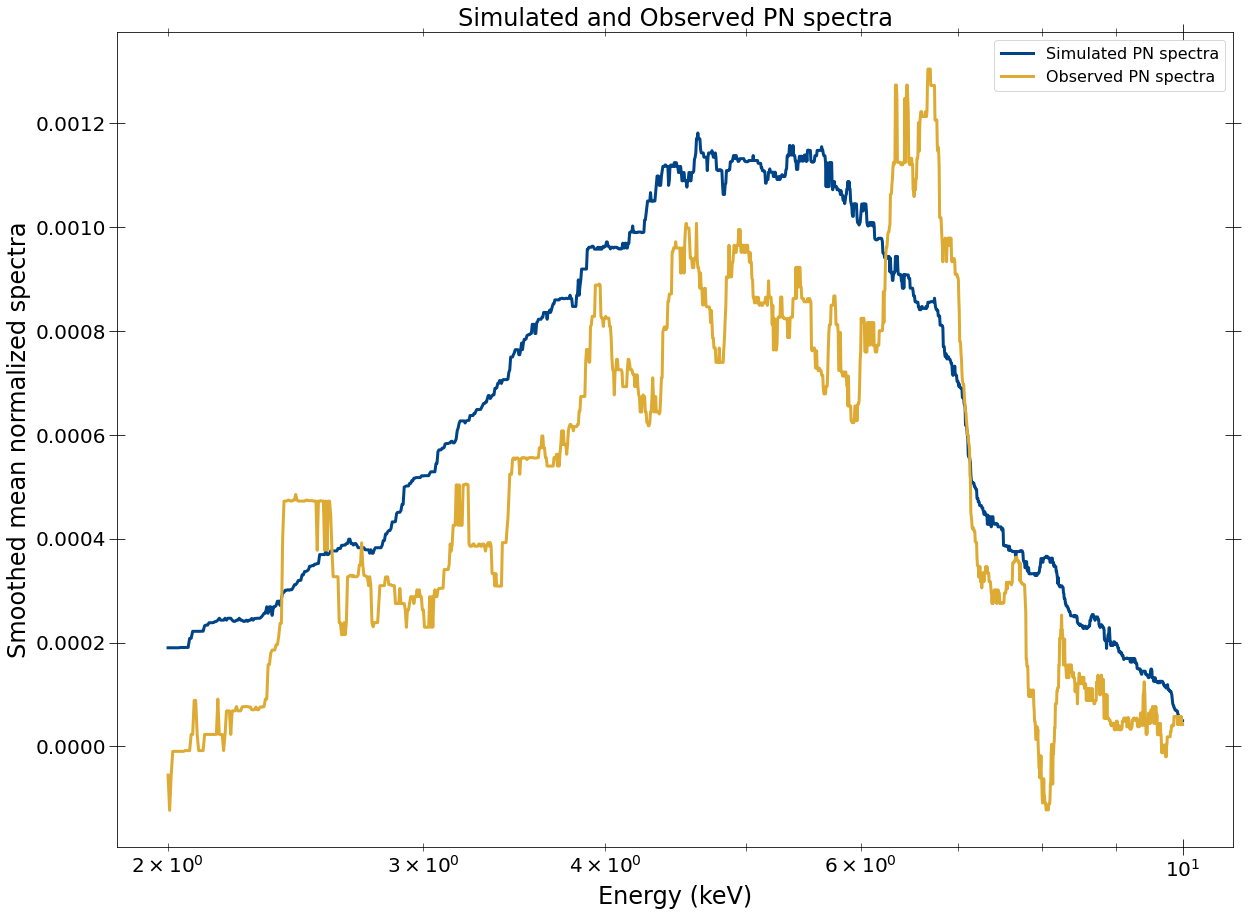

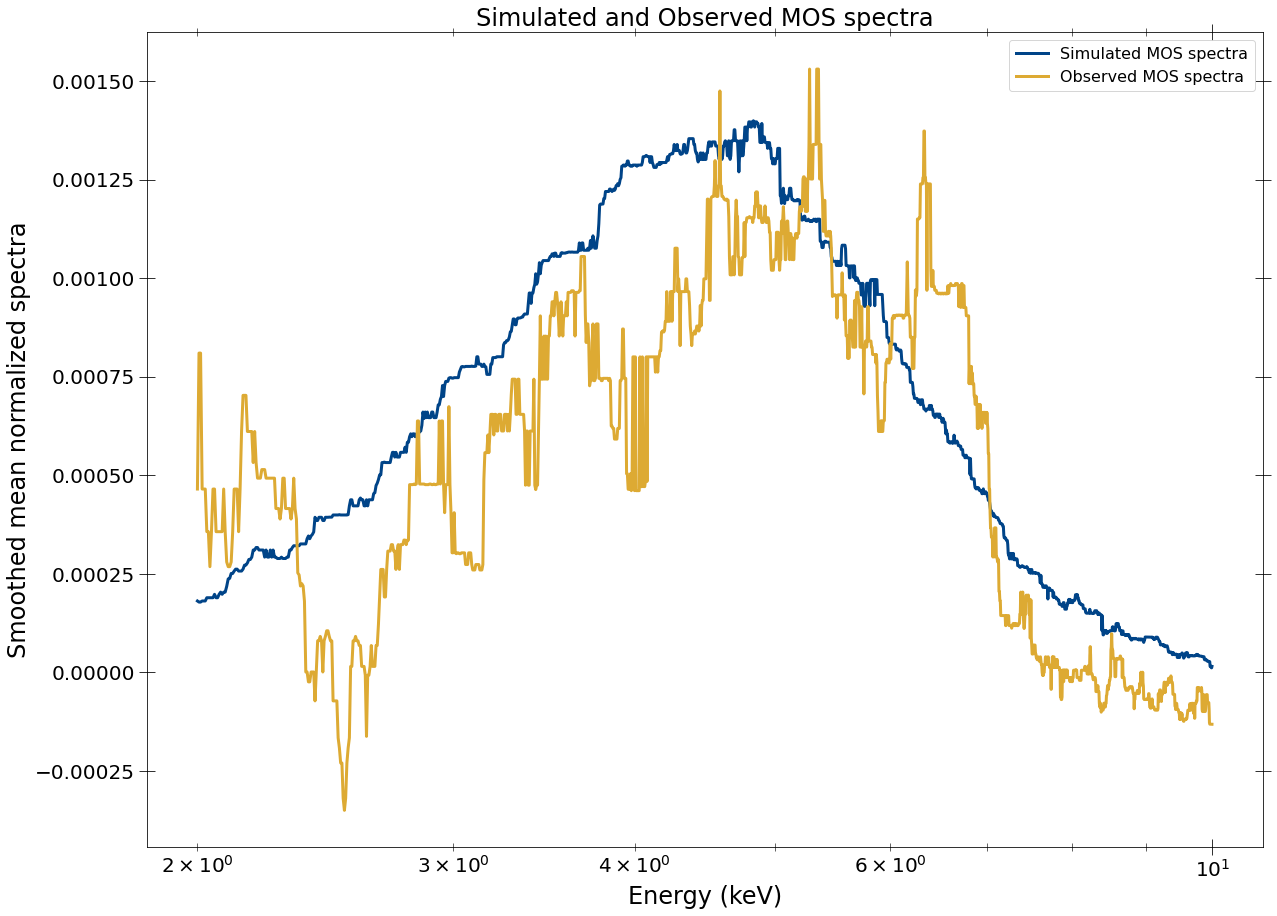

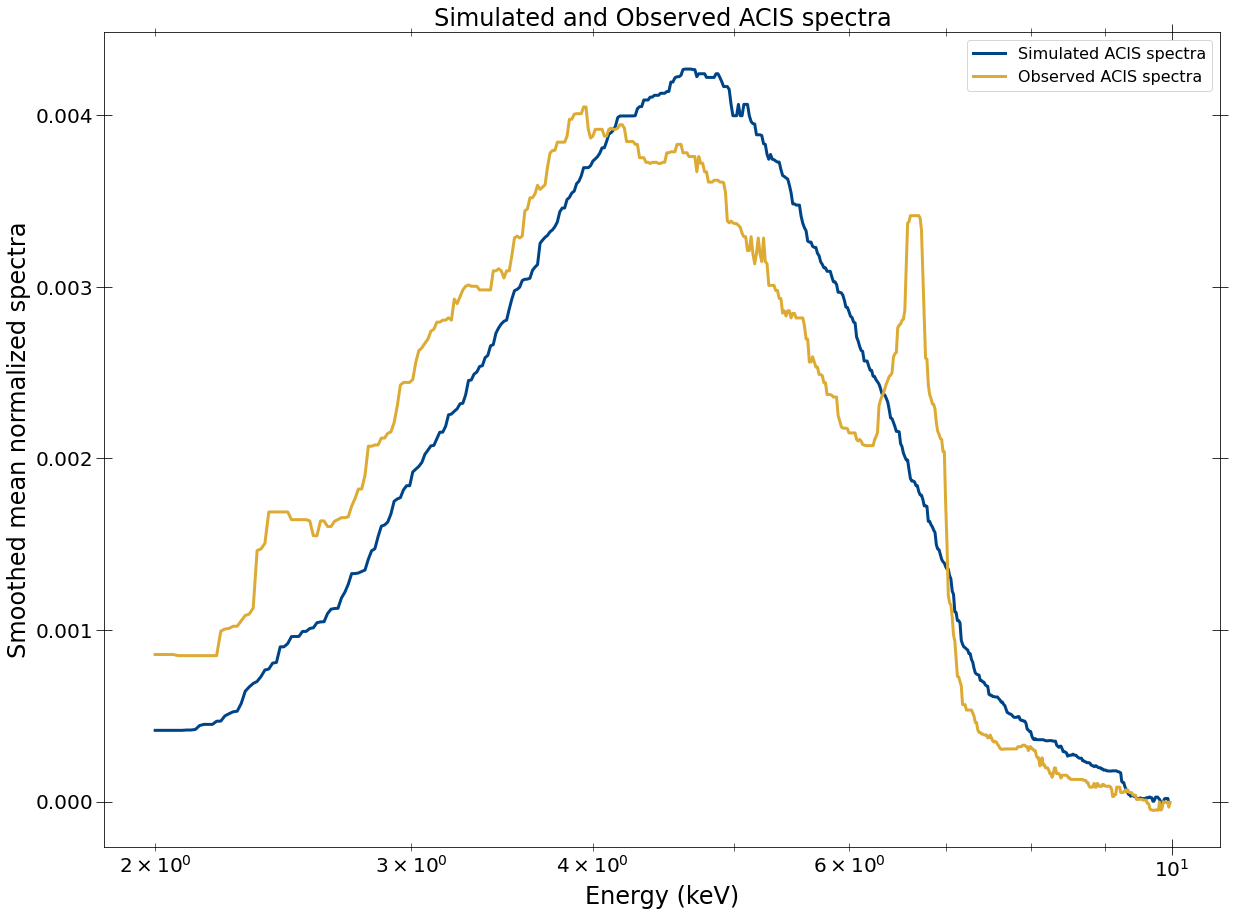

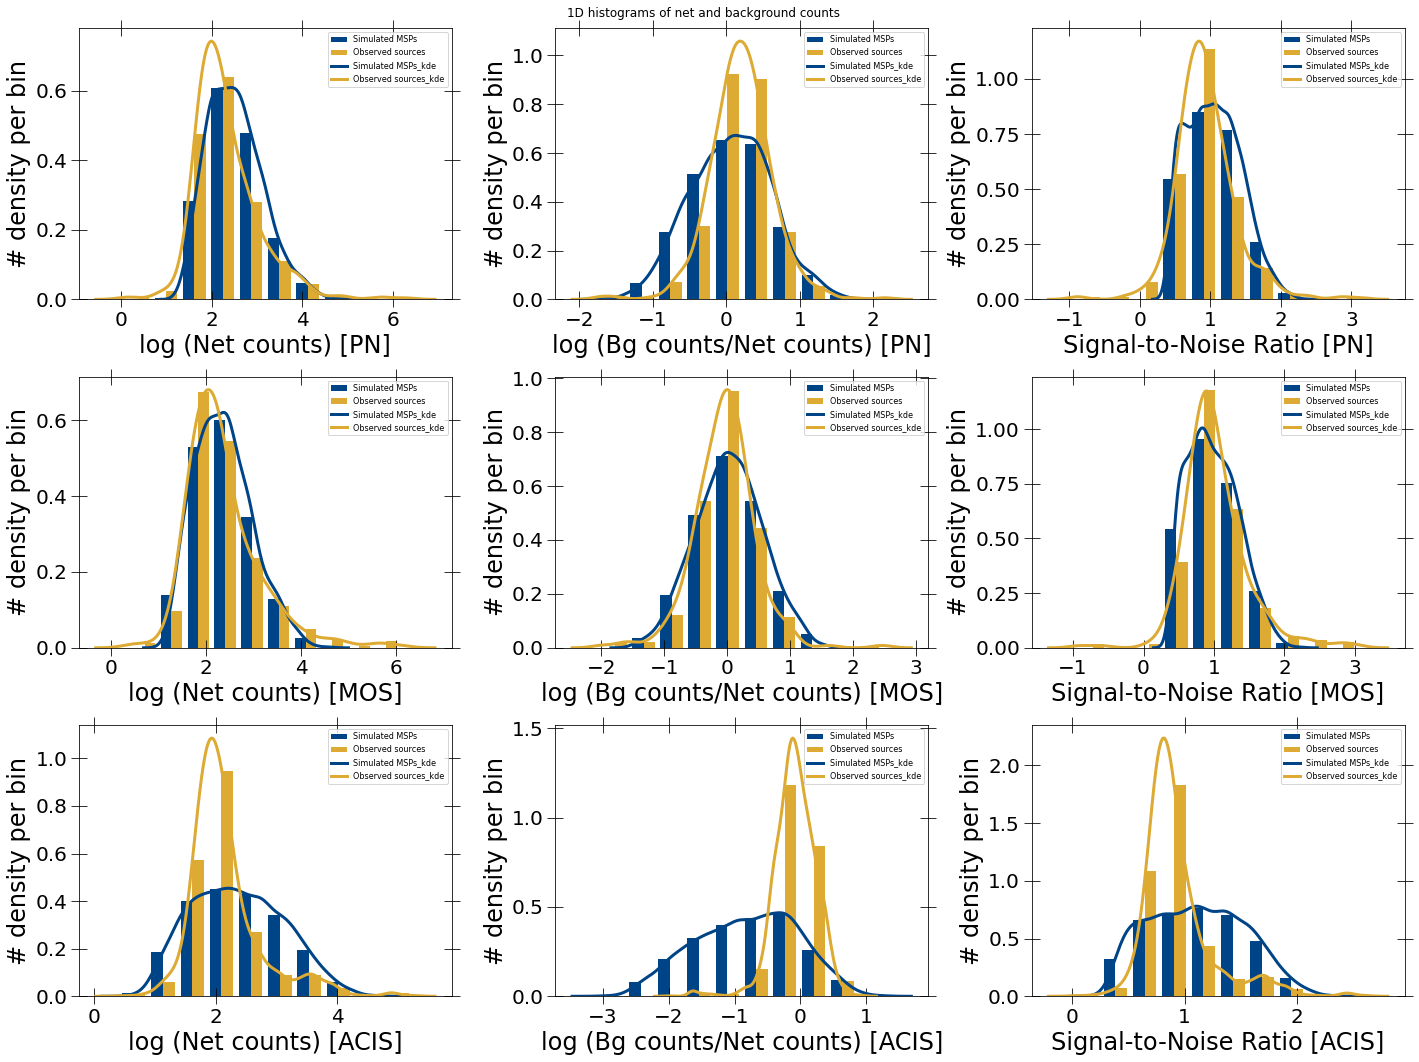

In [340]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

In [71]:
def fit_src_pl_gauss(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.7, 0.0001, 6.1, 6.1, 7.3, 7.3'
    model.gaussian.Sigma.values = '0.1 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('1.0 6')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 8')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 6')
    xspec.Fit.error('1.0 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_pos_low = xspec.AllModels(1).gaussian.LineE.error[0]
    line_pos_high = xspec.AllModels(1).gaussian.LineE.error[1]
    line_norm_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm_high = xspec.AllModels(1).gaussian.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_pos:', xspec.AllModels(1).gaussian.LineE.values[0],
          line_pos_low, line_pos_high,
          ' Fe_norm:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm_low, line_norm_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.LineE.values[0], line_pos_low,
             line_pos_high,
             xspec.AllModels(1).gaussian.norm.values[0], line_norm_low,
             line_norm_high])


25:1: W293 blank line contains whitespace
34:1: W293 blank line contains whitespace
46:5: E265 block comment should start with '# '
64:80: E501 line too long (80 > 79 characters)


In [72]:
def fit_src_pl(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')

    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('1.0 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

35:5: E265 block comment should start with '# '
46:80: E501 line too long (80 > 79 characters)


In [76]:
fit_src_pl_gauss(interested_srcs_alldet[0][11])

Model params for 201129721010126: NH =  46.32831692673019  Gamma:  3.3203021251916023  norm:  0.11458255612264667  Fe_pos: 6.100000000039239 0.0 6.116539145162362  Fe_norm: 1.9827337971923438e-07 9.138755803050159e-08 3.6943709088718473e-07
Fit stats for 201129721010126:  2053.200585681294 -1.9718852483209661 50.0 2248




(['201129721010126', 2053.200585681294, -1.9718852483209661, 50.0, 2248],
 ['201129721010126',
  46.32831692673019,
  3.3203021251916023,
  0.11458255612264667,
  6.100000000039239,
  0.0,
  6.116539145162362,
  1.9827337971923438e-07,
  9.138755803050159e-08,
  3.6943709088718473e-07])

In [75]:
xspec.AllData.clear()
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data')

In [28]:
import xspec

In [77]:
pn_fit_stats_table_pl_g = []
pn_model_params_table_pl_g = []
pn_fit_stats_table_pl_g2 = []
pn_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table_pl_g.append(fit_stats)
    pn_model_params_table_pl_g.append(model_params)
    pn_fit_stats_table_pl_g2.append(fit_stats2)
    pn_model_params_table_pl_g2.append(model_params2)

201113501010066
Model params for 201113501010066: NH =  6.633906669111145  Gamma:  0.6500577460086933  norm:  0.12293357371851216  Fe_pos: 6.495842098254313 6.430395144850943 6.56307092068538  Fe_norm: 5.728099295853509e-07 3.4088308610940647e-07 8.216385720992783e-07
Fit stats for 201113501010066:  881.7070650294453 -8.300414705681586 50.0 1098


Model params for 201113501010066: NH =  6.687325344603863  Gamma:  0.682641185060987  norm:  0.12146610063346863  Fe_norms: 4.2627767940000345e-07 2.327570979353494e-07 6.328888542302593e-07 2.083560418338526e-07 4.198738605582348e-08 3.8966244606634845e-07 6.815835371458432e-08 0.0 2.468781235049556e-07
Fit stats for 201113501010066:  881.5610538995453 -8.2764923068657 50.0 1097


201113501010154
Model params for 201113501010154: NH =  13.647200513231622  Gamma:  3.088517178714544e-07  norm:  0.12298142138175654  Fe_pos: 6.416690600469637 6.353370857719687 6.4807229539026725  Fe_norm: 3.657184129034429e-07 1.8776208582999335e-07 5.5284486637

Model params for 201129721010126: NH =  47.1402296633144  Gamma:  3.0253920176284628  norm:  0.11252196378397063  Fe_norms: 3.0810649264869234e-15 0.0 1.2301696535679368e-08 2.3233570916178308e-08 0.0 1.2635426827211867e-07 8.498332567319275e-17 0.0 5.724424524509343e-08
Fit stats for 201129721010126:  2056.0679247573034 -1.9235495488462924 50.0 2247


204003401010007
Model params for 204003401010007: NH =  5.70878484136381  Gamma:  0.8942089377486862  norm:  0.09635804465848645  Fe_pos: 7.299999998226762 0.0 0.0  Fe_norm: 7.519391980881133e-08 0.0 2.83393773985439e-07
Fit stats for 204003401010007:  1141.5054008909347 -8.16300439507749 50.0 1385


Model params for 204003401010007: NH =  5.371255528463312  Gamma:  0.8146915517373484  norm:  0.09728527259996675  Fe_norms: 1.1350835426517976e-16 0.0 2.360890289968735e-08 3.032312391483764e-15 0.0 8.947919659280347e-08 2.1746981624581612e-17 0.0 1.2130510273869197e-07
Fit stats for 204003401010007:  1141.66684870895 -8.15286588567674 50.0

Model params for 201129705010015: NH =  9.811437559403423  Gamma:  0.8390385874241209  norm:  0.16711844364486983  Fe_pos: 6.477159921737292 6.431101568254457 6.524469241027914  Fe_norm: 1.4138354062645079e-06 1.049632041010416e-06 1.8012969160419057e-06
Fit stats for 201129705010015:  1325.5604161170281 -5.426296913160746 50.0 1605


Model params for 201129705010015: NH =  10.056605982177222  Gamma:  0.8876535561779505  norm:  0.166896826860336  Fe_norms: 9.251042649033169e-07 6.327959650292237e-07 1.2363184625457725e-06 4.6596548924957e-07 2.1092775640382006e-07 7.398657516663245e-07 1.308784278980812e-07 0.0 3.885740822579609e-07
Fit stats for 201129705010015:  1328.757423257622 -5.434125135023264 50.0 1604


201129705010038
Model params for 201129705010038: NH =  57.47974774894054  Gamma:  2.3457401084252334  norm:  0.7141999644479755  Fe_pos: 6.834091060606804 6.749661521607915 6.92012991210562  Fe_norm: 1.151499605546152e-06 6.736827302645454e-07 1.66720632170694e-06
Fit stats fo

Model params for 206946402010009: NH =  7.234397289165287  Gamma:  1.498473351420082  norm:  1.5641387456851947  Fe_norms: 8.517850562125085e-07 0.0 2.3656716864411314e-06 9.88044347326886e-07 0.0 2.743769206085398e-06 3.212713588789392e-07 0.0 1.988994558959061e-06
Fit stats for 206946402010009:  529.7208662476553 -8.093808513756386 50.0 578


207641904010001
Model params for 207641904010001: NH =  9.540034746817156  Gamma:  0.3044938259502609  norm:  1.0346869353004073  Fe_pos: 6.557142711404645 6.507969270240269 6.606787784906025  Fe_norm: 3.4679609785895817e-06 2.541797241361845e-06 4.455327367495274e-06
Fit stats for 207641904010001:  987.5318187837731 -8.93913378721954 50.0 1185


Model params for 207641904010001: NH =  9.555786669810217  Gamma:  0.31503120106094235  norm:  1.029531643611788  Fe_norms: 1.7305506919035889e-06 1.0953779364917195e-06 2.42077500150679e-06 2.070962988162509e-06 1.364952224679965e-06 2.837814637460047e-06 4.9087626094556904e-11 0.0 6.5193763059063e-07


Model params for 201129705010079: NH =  13.583270817557871  Gamma:  1.2552021052583269  norm:  13.1164242824439  Fe_pos: 6.560845590322372 6.469958878750878 6.656925984604004  Fe_norm: 4.777320563650454e-06 1.2149112234788736e-06 8.4472859803076e-06
Fit stats for 201129705010079:  2496.5567168632097 -6.995988915321978 50.0 2597


Model params for 201129705010079: NH =  13.571328887124075  Gamma:  1.2458712805195562  norm:  13.155573839653092  Fe_norms: 1.7775784503880453e-07 0.0 2.914236620183517e-06 4.0187228040699684e-07 0.0 3.2292783632415206e-06 1.348787255557718e-06 0.0 4.267719191319245e-06
Fit stats for 201129705010079:  2498.1274246122503 -6.996475276187615 50.0 2596


201129721010009
Model params for 201129721010009: NH =  14.218905489766716  Gamma:  3.2095845939048098  norm:  0.8474768806537026  Fe_pos: 6.670378011904984 6.645956499033448 6.694487671780801  Fe_norm: 1.439604913493608e-06 1.2193308944268046e-06 1.6650911425708015e-06
Fit stats for 201129721010009:  2643.135451

In [78]:
pn_fit_stats_table_pl = []
pn_model_params_table_pl = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table_pl.append(fit_stats)
    pn_model_params_table_pl.append(model_params)

201113501010066
Model params for 201113501010066: NH =  6.600309051155915  Gamma:  0.5419554654703477  norm:  0.13031892881904109
Fit stats for 201113501010066:  888.3133866673959 -8.204968056946765 50.0 1100


201113501010154
Model params for 201113501010154: NH =  15.993393673135401  Gamma:  5.873779352462729e-05  norm:  0.1360911048936591
Fit stats for 201113501010154:  903.3608054015875 -7.9889327474572935 50.0 1152


201129701010015
Model params for 201129701010015: NH =  2.322688322978612  Gamma:  0.5134151707341227  norm:  0.07566995402251102
Fit stats for 201129701010015:  729.9447013450703 -6.853237332107479 50.0 883


201129704010011
Model params for 201129704010011: NH =  18.944222343092704  Gamma:  0.35800782497273076  norm:  0.2947256379239262
Fit stats for 201129704010011:  1012.6079029890961 -4.516491937423837 50.0 1197


201129704010019
Model params for 201129704010019: NH =  25.34978048600425  Gamma:  0.5509459217154151  norm:  0.21314837180949056
Fit stats for 2011297

Model params for 201129721010078: NH =  10.294203027411813  Gamma:  2.263436523254982e-06  norm:  0.23717112471598042
Fit stats for 201129721010078:  2105.0224517260776 -5.651669587324743 50.0 2343


201129721015131
Model params for 201129721015131: NH =  22.07330868125427  Gamma:  0.3460457773770542  norm:  0.16071112091433257
Fit stats for 201129721015131:  1675.660078536815 -8.298919819566468 50.0 1837


202026705010034
Model params for 202026705010034: NH =  10.84720294279398  Gamma:  2.5300022669119144  norm:  0.09159546702744008
Fit stats for 202026705010034:  1255.1707429685675 -8.674073362472361 50.0 1404


201129705010076
Model params for 201129705010076: NH =  4.3855493945769695  Gamma:  0.1410898378911268  norm:  0.1581046088539537
Fit stats for 201129705010076:  3283.387295191245 -3.946382139455563 50.0 2813


201129721010060
Model params for 201129721010060: NH =  13.921363916869863  Gamma:  1.529411532297306  norm:  0.16074637013282506
Fit stats for 201129721010060:  2254

In [40]:
test

SyntaxError: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)

6: E999 SyntaxError: unexpected character after line continuation character


Error before execution: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)


In [79]:
mos_fit_stats_table_pl = []
mos_model_params_table_pl = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table_pl.append(fit_stats)
    mos_model_params_table_pl.append(model_params)

201129705010014
Model params for 201129705010014: NH =  5.584993694401494  Gamma:  0.17866456445596005  norm:  0.3195350386161304
Fit stats for 201129705010014:  1838.6315286875965 -8.242586123281855 50.0 2043


201129705010095
Model params for 201129705010095: NH =  16.17548024513693  Gamma:  0.45086831302989494  norm:  0.1282611608480652
Fit stats for 201129705010095:  2161.409346521828 -8.301528319760006 50.0 2430


201129707010063
Model params for 201129707010063: NH =  39.546320825282926  Gamma:  1.8118136579422774  norm:  0.45568380335765596
Fit stats for 201129707010063:  1603.580620175288 -5.885724150152902 50.0 2032


201129708010036
Model params for 201129708010036: NH =  6.151608317691017  Gamma:  0.30693623773237555  norm:  0.24694175668163787
Fit stats for 201129708010036:  982.8410525828286 -6.9863348051444945 50.0 1183


201129721010053
Model params for 201129721010053: NH =  29.485069423119047  Gamma:  0.9089245888756968  norm:  0.1743538585512489
Fit stats for 20112972

In [80]:
mos_fit_stats_table_pl_g = []
mos_model_params_table_pl_g = []
mos_fit_stats_table_pl_g2 = []
mos_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table_pl_g.append(fit_stats)
    mos_model_params_table_pl_g.append(model_params)
    mos_fit_stats_table_pl_g2.append(fit_stats2)
    mos_model_params_table_pl_g2.append(model_params2)

201129705010014
Model params for 201129705010014: NH =  5.584867538948037  Gamma:  0.33901830088161816  norm:  0.2887246201575776  Fe_pos: 6.443433709918858 6.416663385065597 6.463900379977172  Fe_norm: 1.8653456251970518e-06 1.6011189537484208e-06 2.132961978499824e-06
Fit stats for 201129705010014:  1774.9228261043154 -9.056778692917732 50.0 2041


Model params for 201129705010014: NH =  6.147921286466337  Gamma:  0.5009379162003667  norm:  0.2767978355405917  Fe_norms: 1.4926535889387695e-06 1.2801409339946642e-06 1.7138509883499748e-06 7.013786643906237e-07 5.09903461939364e-07 9.023101317111965e-07 6.519865854906684e-07 4.576646927612647e-07 8.571065324911019e-07
Fit stats for 201129705010014:  1752.5457208546204 -9.139094365338062 50.0 2040


201129705010095
Model params for 201129705010095: NH =  15.007449798477664  Gamma:  0.49650517664830546  norm:  0.11919755743591572  Fe_pos: 6.6643334855424365 6.611230786579107 6.715074589326695  Fe_norm: 3.6578716324248264e-07 2.7100145772

Model params for 200305402010002: NH =  6.281424861993203  Gamma:  0.4089322520888237  norm:  1.0765355433266477  Fe_norms: 3.4092141402673888e-06 2.7131981323434423e-06 4.146402834002477e-06 2.981460610590346e-06 2.2667656446188443e-06 3.742453687471205e-06 2.8553059779608085e-06 2.1081755768332262e-06 3.655620526774703e-06
Fit stats for 200305402010002:  1304.827283228435 -9.391357208953371 50.0 1560


201113501010069
Model params for 201113501010069: NH =  57.870052062965925  Gamma:  0.8289934693979649  norm:  0.2853798522863949  Fe_pos: 6.756400693547396 6.724218628708995 6.787208131439399  Fe_norm: 1.4598721995145823e-06 1.311430173015449e-06 1.6180381698548526e-06
Fit stats for 201113501010069:  3240.1070648437853 -4.7052704081605246 50.0 3080


Model params for 201113501010069: NH =  40.96167367974675  Gamma:  0.4540189962412879  norm:  0.19459414463288488  Fe_norms: 4.259255460590691e-07 3.4011887720026284e-07 5.144814806607074e-07 9.364997538689036e-07 8.358037656360166e-07 1.

Model params for 201129721010060: NH =  14.061337376513071  Gamma:  1.555722504107865  norm:  0.1610539458586839  Fe_pos: 7.029642162185092 6.407305240253272 0.0  Fe_norm: 4.22000520954905e-08 0.0 1.3512904855881377e-07
Fit stats for 201129721010060:  2253.948511843536 -9.028356083265157 50.0 2437


Model params for 201129721010060: NH =  14.045747394762735  Gamma:  1.552750236412086  norm:  0.16103311450212174  Fe_norms: 2.0354144465934056e-15 0.0 2.061922961565254e-08 1.2340912792778225e-14 0.0 5.0711273191519934e-08 5.241756381005687e-08 0.0 1.2345667886233842e-07
Fit stats for 201129721010060:  2253.5971870878084 -9.023067498679849 50.0 2436


201129721010138
Model params for 201129721010138: NH =  5.760964822034272  Gamma:  0.7433311037125745  norm:  0.1522681975032172  Fe_pos: 6.789233333740378 6.6602722875013045 6.884686299235189  Fe_norm: 2.556536584251969e-07 1.427240452374019e-07 3.7146388667569314e-07
Fit stats for 201129721010138:  2768.0795835620875 -6.587413293318059 50.0

Model params for 201113501010010: NH =  30.9492246994759  Gamma:  2.3913159022656867  norm:  67.35764075934345  Fe_pos: 6.100000000000067 0.0 6.106672465115789  Fe_norm: 1.351513471095358e-05 1.2582748683858825e-05 1.4451443541135533e-05
Fit stats for 201113501010010:  31350.31575904898 -6.362232228996134 50.0 3193


Model params for 201113501010010: NH =  31.056844647061038  Gamma:  2.395442834474534  norm:  67.79746049560106  Fe_norms: 6.298851423868799e-06 5.568904602349944e-06 7.032726290492135e-06 2.2470499601460943e-21 0.5 0.0 8.582564229020048e-21 0.5 0.0
Fit stats for 201113501010010:  31460.665366819067 -6.362079287442947 50.0 3192


201113503010004
Model params for 201113503010004: NH =  17.496371845714343  Gamma:  1.953514716803611  norm:  90.81938208373408  Fe_pos: 6.602180569098474 6.513292260315008 6.696706781657533  Fe_norm: 4.930279027234024e-06 2.866925294657683e-06 7.004329628524803e-06
Fit stats for 201113503010004:  12523.297331595944 -7.054528515597089 50.0 3193




In [81]:
os.chdir('/Users/pavanrh/Documents/UofA_projects/GalacticBulge/data/')
os.getcwd()

'/Users/pavanrh/Documents/UofA_projects/GalacticBulge/data'

In [82]:
acis_fit_stats_table_pl = []
acis_model_params_table_pl = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table_pl.append(fit_stats)
    acis_model_params_table_pl.append(model_params)

2CXOJ174512.3-285901
Model params for 2CXOJ174512.3-285901: NH =  3.135402783290531  Gamma:  4.409029718684398e-05  norm:  0.017508409991665582
Fit stats for 2CXOJ174512.3-285901:  342.0650959363846 -8.333915821486354 50.0 364


2CXOJ174536.8-290042
Model params for 2CXOJ174536.8-290042: NH =  40.763835911139395  Gamma:  2.88975545383495  norm:  0.06864367323274793
Fit stats for 2CXOJ174536.8-290042:  282.02525609425885 -6.48825342388365 50.0 303


2CXOJ174536.0-290434
Model params for 2CXOJ174536.0-290434: NH =  21.83598017567852  Gamma:  0.12058949882134419  norm:  0.02543128257940855
Fit stats for 2CXOJ174536.0-290434:  237.80801276692947 -7.400333217150397 50.0 267


2CXOJ174546.6-290328
Model params for 2CXOJ174546.6-290328: NH =  23.660860291613744  Gamma:  0.609481941264933  norm:  0.02687185079043891
Fit stats for 2CXOJ174546.6-290328:  285.892666432963 -7.218351524268843 50.0 299


2CXOJ174551.5-285651
Model params for 2CXOJ174551.5-285651: NH =  58.56761501483879  Gamma:  2.3

Model params for 2CXOJ174539.5-290039: NH =  4.163353156616041  Gamma:  0.9908712876717432  norm:  0.010511074568406347
Fit stats for 2CXOJ174539.5-290039:  299.86302464279566 -7.954989607380457 50.0 331


2CXOJ174547.8-290145
Model params for 2CXOJ174547.8-290145: NH =  6.573117042482085  Gamma:  4.955683890024273e-05  norm:  0.014718660899680141
Fit stats for 2CXOJ174547.8-290145:  182.54311309713478 -7.864059647578533 50.0 261


2CXOJ174543.2-290146
Model params for 2CXOJ174543.2-290146: NH =  19.23831031411862  Gamma:  0.20763576486051621  norm:  0.025604444551450316
Fit stats for 2CXOJ174543.2-290146:  187.4250140897907 -8.807035972290313 50.0 287


2CXOJ174513.0-290229
Model params for 2CXOJ174513.0-290229: NH =  51.22498201634591  Gamma:  0.8913578671919993  norm:  0.07493366597524916
Fit stats for 2CXOJ174513.0-290229:  258.5067930967507 -7.176326566960982 50.0 335


2CXOJ174553.9-290347
Model params for 2CXOJ174553.9-290347: NH =  12.445146764738515  Gamma:  1.3517841401140651

Model params for 2CXOJ174512.9-285844: NH =  26.24998392898  Gamma:  0.16976734599797882  norm:  0.10640279167062736
Fit stats for 2CXOJ174512.9-285844:  343.7100629367509 -7.706720980234093 50.0 358


2CXOJ174542.3-285506
Model params for 2CXOJ174542.3-285506: NH =  23.894051491906314  Gamma:  2.3748448655210486  norm:  0.04415994998670384
Fit stats for 2CXOJ174542.3-285506:  351.48973866984886 -8.421808479942749 50.0 396


2CXOJ174539.0-290126
Model params for 2CXOJ174539.0-290126: NH =  36.81503079489665  Gamma:  1.2882398098598133  norm:  0.036771505683497706
Fit stats for 2CXOJ174539.0-290126:  299.5065626837523 -8.197286345070268 50.0 338


2CXOJ174530.0-285943
Model params for 2CXOJ174530.0-285943: NH =  29.976508507836396  Gamma:  2.6040114054819856  norm:  0.07082703981229425
Fit stats for 2CXOJ174530.0-285943:  249.05469758280503 -8.619022163296624 50.0 321


2CXOJ174537.8-285908
Model params for 2CXOJ174537.8-285908: NH =  9.93850425468395  Gamma:  0.5218986901862256  norm: 

Model params for 2CXOJ174548.1-285347: NH =  21.32008841161296  Gamma:  0.9147382815295835  norm:  0.08381005110808207
Fit stats for 2CXOJ174548.1-285347:  386.02728662138543 -10.02555313863046 50.0 459


2CXOJ174546.2-285906
Model params for 2CXOJ174546.2-285906: NH =  8.26799464596074  Gamma:  0.3213773838824851  norm:  0.06303806377924152
Fit stats for 2CXOJ174546.2-285906:  446.6013915208528 -9.063694438375123 50.0 407


2CXOJ174555.5-285633
Model params for 2CXOJ174555.5-285633: NH =  13.994566242915655  Gamma:  1.4295738807104614  norm:  0.05036598858311891
Fit stats for 2CXOJ174555.5-285633:  383.2779020363886 -9.559030031267028 50.0 424


2CXOJ174544.4-285935
Model params for 2CXOJ174544.4-285935: NH =  19.181858457170392  Gamma:  2.0309084080554  norm:  0.10226748884493411
Fit stats for 2CXOJ174544.4-285935:  373.4941449892398 -9.557291730152834 50.0 384


2CXOJ174540.1-290055
Model params for 2CXOJ174540.1-290055: NH =  27.248835863618748  Gamma:  2.431135305942967  norm:  0.

6:80: E501 line too long (101 > 79 characters)


Model params for 2CXOJ174540.1-290029: NH =  25.3516333214437  Gamma:  4.174771890198073  norm:  10.323669094082566
Fit stats for 2CXOJ174540.1-290029:  3166.4841363819296 -10.354160549761449 50.0 546




In [83]:
acis_fit_stats_table_pl_g = []
acis_model_params_table_pl_g = []
acis_fit_stats_table_pl_g2 = []
acis_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='./chandra_obs', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table_pl_g.append(fit_stats)
    acis_model_params_table_pl_g.append(model_params)
    acis_fit_stats_table_pl_g2.append(fit_stats2)
    acis_model_params_table_pl_g2.append(model_params2)

2CXOJ174512.3-285901
Model params for 2CXOJ174512.3-285901: NH =  2.4547438844134724  Gamma:  0.04819270111627824  norm:  0.015683245267835474  Fe_pos: 6.241893948842428 6.120790386736218 6.353991087532205  Fe_norm: 7.959609673095217e-08 3.511584647558018e-08 1.3233565345136516e-07
Fit stats for 2CXOJ174512.3-285901:  338.58204468449543 -8.457439165888406 50.0 362


Model params for 2CXOJ174512.3-285901: NH =  2.7312118293357988  Gamma:  9.491361624616095e-07  norm:  0.01672755208866433  Fe_norms: 4.494518454331409e-08 2.7634318164169262e-09 9.097969227320774e-08 0.0 0.0 5.0815207064140444e-08 7.35152691460811e-24 0.5 0.0
Fit stats for 2CXOJ174512.3-285901:  340.91985733511376 -8.544935043053078 50.0 361


2CXOJ174536.8-290042
Model params for 2CXOJ174536.8-290042: NH =  49.21313369493321  Gamma:  4.190189562471659  norm:  0.13552743062973457  Fe_pos: 6.574618849066291 6.5066541771378645 6.6450120273860485  Fe_norm: 3.0098265203407584e-07 1.8251347395470847e-07 4.4613360080489896e-07
F

Model params for 2CXOJ174538.3-290136: NH =  25.635548937500808  Gamma:  2.33754898373344  norm:  0.024837296137388585  Fe_pos: 6.331439568902344 6.182459397896225 6.672385428099771  Fe_norm: 4.826556397315832e-08 7.30200920249582e-09 9.573350955214136e-08
Fit stats for 2CXOJ174538.3-290136:  237.30999665943065 -8.87273102936286 50.0 267


Model params for 2CXOJ174538.3-290136: NH =  26.130360591281487  Gamma:  2.376264579211929  norm:  0.025521461920534595  Fe_norms: 2.410697733765133e-08 0.0 6.630365644560826e-08 1.3123004032158636e-08 0.0 5.53595511651193e-08 1.2550629194568284e-08 0.0 5.51016994204429e-08
Fit stats for 2CXOJ174538.3-290136:  238.11677450781528 -8.832890987203651 50.0 266


2CXOJ174607.2-285655
Model params for 2CXOJ174607.2-285655: NH =  7.375187354873889  Gamma:  1.0280415373372085  norm:  0.01824640938763999  Fe_pos: 6.925302220435152 6.792849316241879 7.047461864917717  Fe_norm: 1.2766732756408156e-07 5.606620870220537e-08 2.0696449946399058e-07
Fit stats for 2C

Model params for 2CXOJ174538.5-290136: NH =  19.71387469868869  Gamma:  1.6592948772550522  norm:  0.02332679616106428  Fe_norms: 2.042370152551854e-16 0.0 1.1608885593575849e-08 4.2265813601507047e-08 6.027959251695843e-09 8.327909195546026e-08 2.3319867556155666e-08 0.0 6.168902421957807e-08
Fit stats for 2CXOJ174538.5-290136:  283.94309673301154 -8.653312006860498 50.0 281


2CXOJ174605.6-285453
Model params for 2CXOJ174605.6-285453: NH =  39.72219247355931  Gamma:  2.031580880965752  norm:  0.049960281566595106  Fe_pos: 6.666211981987479 6.616688843234727 6.715505248839745  Fe_norm: 2.7123391636063465e-07 1.816546733432298e-07 3.7957647264994074e-07
Fit stats for 2CXOJ174605.6-285453:  248.25542458807695 -7.94535140885684 50.0 318


Model params for 2CXOJ174605.6-285453: NH =  39.06615004009084  Gamma:  1.91980752264749  norm:  0.048887685302929154  Fe_norms: 2.5122714632194205e-08 0.0 9.224010364222415e-08 2.142954306705101e-07 1.4056272756995693e-07 3.0572166240588396e-07 3.80313

Model params for 2CXOJ174546.2-290737: NH =  45.472417432162054  Gamma:  2.4680890256451367  norm:  0.06640348292640663  Fe_pos: 6.619075096094044 6.565365708148811 6.672186606551971  Fe_norm: 3.041096663659402e-07 1.723993152674838e-07 4.532677676324295e-07
Fit stats for 2CXOJ174546.2-290737:  375.2034822039417 -7.7463514010163985 50.0 446


Model params for 2CXOJ174546.2-290737: NH =  48.006363793702114  Gamma:  2.6533554714687035  norm:  0.07456790373919635  Fe_norms: 2.1711045729980977e-08 0.0 1.0950242072961831e-07 2.1456136281201954e-07 1.1057456368008535e-07 3.620545488772989e-07 9.399275673104044e-08 1.2396946487012834e-08 2.0140362920776673e-07
Fit stats for 2CXOJ174546.2-290737:  376.064994665249 -7.568353933520829 50.0 445


2CXOJ174614.7-285749
Model params for 2CXOJ174614.7-285749: NH =  13.00041595536773  Gamma:  4.879706511669379  norm:  0.036876128695636355  Fe_pos: 6.713096004104124 0.0 0.0  Fe_norm: 6.181181928381457e-08 0.0 1.492298382044041e-07
Fit stats for 2CXOJ17

Model params for 2CXOJ174540.6-290001: NH =  36.4854119277561  Gamma:  2.4447162843984125  norm:  0.06803669105416862  Fe_norms: 7.419519877409566e-19 0.0 1.5474765124658513e-08 1.6865299246489752e-07 8.908690483328398e-08 2.478387094589426e-07 5.591686496935601e-18 0.0 2.487402714240436e-08
Fit stats for 2CXOJ174540.6-290001:  241.83840553367145 -8.754461145413675 50.0 247


2CXOJ174551.4-290227
Model params for 2CXOJ174551.4-290227: NH =  32.45197066736834  Gamma:  2.332342243262181  norm:  0.03469932833131536  Fe_pos: 6.580280707325849 6.513224261125304 6.64604980916428  Fe_norm: 1.234109287436552e-07 7.5433782308508e-08 1.7912874681234456e-07
Fit stats for 2CXOJ174551.4-290227:  239.2548973163593 -8.263516515546055 50.0 287


Model params for 2CXOJ174551.4-290227: NH =  32.27868177048154  Gamma:  2.3008789251758968  norm:  0.03443310349956233  Fe_norms: 4.16762910902837e-08 5.591817302566541e-09 8.309158214667035e-08 7.497207106625908e-08 3.3774494666443273e-08 1.2236493830944277e-

Model params for 2CXOJ174536.4-290545: NH =  4.7451667147331476  Gamma:  1.352606574699861  norm:  0.012404560327500338  Fe_norms: 2.6225073982816082e-08 0.0 6.258769599606459e-08 1.227267567702143e-07 7.526213595793106e-08 1.7812119038359034e-07 7.114005937659806e-08 2.8369609543939882e-08 1.2353997224004475e-07
Fit stats for 2CXOJ174536.4-290545:  193.2215095030977 -8.051185695722404 50.0 247


2CXOJ174544.2-285918
Model params for 2CXOJ174544.2-285918: NH =  28.707717184986215  Gamma:  2.181083582896623  norm:  0.07346141391879013  Fe_pos: 6.337263150265195 6.211485780929979 6.467590554359937  Fe_norm: 1.1291011296201036e-07 2.5968598010715863e-08 2.1101455521019103e-07
Fit stats for 2CXOJ174544.2-285918:  202.1197433394063 -9.85774617689307 50.0 259


Model params for 2CXOJ174544.2-285918: NH =  28.91689308625408  Gamma:  2.18965277340975  norm:  0.07427915917144341  Fe_norms: 9.440506157115613e-08 1.9956645039464477e-08 1.815773303600054e-07 3.533302367628013e-24 0.0 5.91234397490

Model params for 2CXOJ174540.2-290042: NH =  31.313154312235444  Gamma:  1.7533699812605996  norm:  0.07176048522193695  Fe_pos: 6.793173174911897 6.566992742037947 7.273533058590724  Fe_norm: 6.264852893593717e-08 0.0 1.5833621408819937e-07
Fit stats for 2CXOJ174540.2-290042:  292.4050526742323 -9.019959951729396 50.0 335


Model params for 2CXOJ174540.2-290042: NH =  30.955104531426386  Gamma:  1.718803823633611  norm:  0.07092122325972118  Fe_norms: 3.2806461556381696e-15 0.0 2.17388799314057e-08 6.858164919080755e-08 0.0 1.4367357777755017e-07 1.4858353312283163e-17 0.0 5.609517717426083e-08
Fit stats for 2CXOJ174540.2-290042:  292.0555464115042 -9.000139303566492 50.0 334


2CXOJ174531.5-290307
Model params for 2CXOJ174531.5-290307: NH =  20.779278041814834  Gamma:  0.9398716287371571  norm:  0.03701304103338581  Fe_pos: 6.651022763612796 6.6066073815311315 6.6984617142113025  Fe_norm: 1.9555750978667981e-07 1.3939759707533512e-07 2.570118973198082e-07
Fit stats for 2CXOJ174531.5-

Model params for 2CXOJ174540.6-285626: NH =  22.132935780447024  Gamma:  0.6284874606907068  norm:  0.029764724744011258  Fe_norms: 1.7099261943885986e-13 0.0 2.436148388262246e-08 8.58352596543411e-08 3.884568712448913e-08 1.3883416576884667e-07 2.3708046451511393e-08 0.0 7.609874429359017e-08
Fit stats for 2CXOJ174540.6-285626:  386.7889744335531 -7.167480228416001 50.0 380


2CXOJ174513.7-285638
Model params for 2CXOJ174513.7-285638: NH =  11.83578529889469  Gamma:  0.5938220284113434  norm:  0.030128245922355697  Fe_pos: 6.725098083481697 6.666122779073126 6.784555914117021  Fe_norm: 1.7865537615131306e-07 1.0915451949178851e-07 2.556594975955065e-07
Fit stats for 2CXOJ174513.7-285638:  381.29839208433384 -8.288422667261708 50.0 430


Model params for 2CXOJ174513.7-285638: NH =  11.613242329853954  Gamma:  0.5655985252337874  norm:  0.030058621422930143  Fe_norms: 2.0717072819610516e-08 0.0 6.727309971390201e-08 1.5928350408137352e-07 9.975623824467124e-08 2.25026261549101e-07 2.59

Model params for 2CXOJ174541.7-285854: NH =  22.094080531190897  Gamma:  2.020795783793552  norm:  0.03642935766918235  Fe_pos: 6.621285627360987 6.5120184964941235 6.7344156611043  Fe_norm: 6.106354057564941e-08 1.4892206245898275e-08 1.1201292250256995e-07
Fit stats for 2CXOJ174541.7-285854:  299.75038919450026 -9.408243306672716 50.0 343


Model params for 2CXOJ174541.7-285854: NH =  21.651193121892465  Gamma:  1.930104018664609  norm:  0.036018497073290634  Fe_norms: 1.117717618957773e-22 0.0 2.0642226283982575e-08 4.5061970302810104e-08 3.235935778768867e-09 8.483343526525921e-08 7.056863110189119e-21 0.0 1.6105791188093786e-08
Fit stats for 2CXOJ174541.7-285854:  300.2898581180142 -9.474283995761725 50.0 342


2CXOJ174542.2-285959
Model params for 2CXOJ174542.2-285959: NH =  25.19172402041209  Gamma:  1.7032248150515987  norm:  0.0687074940390855  Fe_pos: 6.318680121218307 0.0 6.532345895094722  Fe_norm: 1.2895587976033935e-07 3.068517088569404e-08 2.416110430518263e-07
Fit stats

Model params for 2CXOJ174529.5-285433: NH =  16.16554331420055  Gamma:  1.1811724338300178  norm:  0.050682249096855925  Fe_norms: 1.2261581976559366e-07 6.855840203390118e-08 1.781807504832579e-07 7.204700361771951e-08 1.4889189552483784e-08 1.3028756294991122e-07 2.799692777445191e-15 0.0 1.923688810599976e-08
Fit stats for 2CXOJ174529.5-285433:  421.06442123789094 -9.369160332534054 50.0 444


2CXOJ174543.3-290213
Model params for 2CXOJ174543.3-290213: NH =  13.663157134032733  Gamma:  1.7120899219562644  norm:  0.03497936908834475  Fe_pos: 6.79320524423705 6.695727214002811 6.899487299858163  Fe_norm: 1.1164643736146557e-07 5.9443249769009554e-08 1.6897926222110174e-07
Fit stats for 2CXOJ174543.3-290213:  284.07954538535853 -9.766803613575295 50.0 337


Model params for 2CXOJ174543.3-290213: NH =  13.92055840499124  Gamma:  1.766989142912467  norm:  0.035125250222271094  Fe_norms: 1.784707080576295e-13 0.0 2.1924422193234838e-08 8.055017240666751e-08 3.889901061860747e-08 1.2693859

Model params for 2CXOJ174555.5-285633: NH =  14.627745670994267  Gamma:  1.5549195351761318  norm:  0.05062418666248921  Fe_norms: 6.69592508900233e-15 0.0 2.53341228532313e-08 5.2759257225349696e-08 8.534096587962983e-09 1.0154973877553996e-07 1.1482199437516251e-08 0.0 6.214855139382983e-08
Fit stats for 2CXOJ174555.5-285633:  381.83811730619493 -9.434505663409512 50.0 421


2CXOJ174544.4-285935
Model params for 2CXOJ174544.4-285935: NH =  19.985357027260704  Gamma:  2.177306524642698  norm:  0.10538563772465395  Fe_pos: 7.070678919238488 6.830888275496389 0.0  Fe_norm: 1.1893325681687716e-07 2.7268209315515293e-08 2.2441272580526561e-07
Fit stats for 2CXOJ174544.4-285935:  371.7981337749195 -9.725653668967535 50.0 382


Model params for 2CXOJ174544.4-285935: NH =  20.24601114450224  Gamma:  2.245306363015341  norm:  0.10613893019727107  Fe_norms: 5.2870932366924305e-08 0.0 1.2183347923845607e-07 2.492655744599367e-08 0.0 1.0182652086577749e-07 9.879918409208078e-08 2.389505895867411

Model params for 2CXOJ174554.4-285454: NH =  14.609014648032337  Gamma:  2.2531915693657547  norm:  1.9293317026171184  Fe_pos: 6.262017660930403 0.0 0.0  Fe_norm: 2.324263661767818e-07 0.0 5.404372894513895e-07
Fit stats for 2CXOJ174554.4-285454:  677.0150816783417 -11.091503704987195 50.0 525


Model params for 2CXOJ174554.4-285454: NH =  14.545018499591807  Gamma:  2.237105242754477  norm:  1.9258035899696841  Fe_norms: 5.154281655057774e-19 0.0 1.7651661692717648e-07 3.1426329600224185e-21 0.0 1.1056783323773931e-07 1.0077033677479202e-21 0.5 0.0
Fit stats for 2CXOJ174554.4-285454:  677.6281209548971 -11.053286660339698 50.0 524


2CXOJ174502.3-285449
Model params for 2CXOJ174502.3-285449: NH =  9.11619583108834  Gamma:  0.13584822677234065  norm:  28.88728032653082  Fe_pos: 7.299999981327522 0.0 0.0  Fe_norm: 1.5705444599547423e-15 0.0 1.1437943473399259e-06
Fit stats for 2CXOJ174502.3-285449:  2795.174775394704 -8.493489490411243 50.0 544


Model params for 2CXOJ174502.3-285449: 

8:80: E501 line too long (107 > 79 characters)
9:80: E501 line too long (110 > 79 characters)


In [37]:
aic_pl_arr = []
aic_pl_g_arr = []
aic_pl_g3_arr = []
fit_stats_pl_list = [pn_fit_stats_table_pl, mos_fit_stats_table_pl, acis_fit_stats_table_pl]
fit_stats_pl_g_list = [pn_fit_stats_table_pl_g, mos_fit_stats_table_pl_g, acis_fit_stats_table_pl_g]
fit_stats_pl_g3_list = [pn_fit_stats_table_pl_g2, mos_fit_stats_table_pl_g2, acis_fit_stats_table_pl_g2]

for i, fit_stats_pl in enumerate(fit_stats_pl_list):
    fit_stats_pl_arr = np.array(fit_stats_pl)
    fit_stats_pl_gauss_arr = np.array(fit_stats_pl_g_list[i])
    fit_stats_pl_gauss3_arr = np.array(fit_stats_pl_g3_list[i])

    aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
    aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10
    aic_pl_gauss3 = fit_stats_pl_gauss3_arr[:, 1].astype(float) + 12
    
    aic_pl_arr.append(aic_pl)
    aic_pl_g_arr.append(aic_pl_gauss)
    aic_pl_g3_arr.append(aic_pl_gauss3)

4:80: E501 line too long (92 > 79 characters)
5:80: E501 line too long (100 > 79 characters)
6:80: E501 line too long (104 > 79 characters)
16:1: W293 blank line contains whitespace


In [38]:
candidate_srcs_pn = (interested_srcs_alldet[0][np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 4)])

In [39]:
candidate_srcs_mos = (interested_srcs_alldet[1][np.where(aic_pl_arr[1] < aic_pl_g3_arr[1] - 4)])

In [40]:
candidate_srcs_acis = (interested_srcs_alldet[2][np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4)])

In [44]:
np.sort(candidate_srcs_pn)

array(['201129701010015', '201129702010002', '201129705010011',
       '201129705010079', '201129707010063', '201129721010014',
       '201129721010057', '201129721010060', '201129721010126',
       '201129721010133', '202026705010034', '203032102010002',
       '204003401010007', '206946402010009', '208016813010003'],
      dtype=object)

In [69]:
def arr_to_str(arr, type='name'):
    string = ''
    for element in arr:
        if type == 'name':
            element = element.split('J')[0] + ' J' + element.split('J')[1]
        string += str(element) + '; '
    return string[:-2]

In [70]:
arr_to_str(np.sort(candidate_srcs_pn))

'2CXO J174502.3-285449; 2CXO J174503.8-290051; 2CXO J174503.9-290139; 2CXO J174508.6-285652; 2CXO J174512.3-285901; 2CXO J174520.5-290501; 2CXO J174530.0-285943; 2CXO J174533.4-285617; 2CXO J174533.6-285930; 2CXO J174533.6-290140; 2CXO J174535.5-290124; 2CXO J174535.6-290133; 2CXO J174536.4-290043; 2CXO J174537.8-285908; 2CXO J174538.0-290022; 2CXO J174538.1-290047; 2CXO J174538.3-290048; 2CXO J174538.3-290136; 2CXO J174538.4-290044; 2CXO J174538.5-290136; 2CXO J174538.7-290133; 2CXO J174538.8-290056; 2CXO J174539.3-285538; 2CXO J174539.4-290041; 2CXO J174539.5-290039; 2CXO J174539.8-290020; 2CXO J174539.8-290022; 2CXO J174540.0-290005; 2CXO J174540.1-290029; 2CXO J174540.1-290055; 2CXO J174540.2-285922; 2CXO J174540.2-290042; 2CXO J174540.3-290005; 2CXO J174540.8-290149; 2CXO J174540.9-290014; 2CXO J174541.4-290027; 2CXO J174541.6-285933; 2CXO J174541.7-285854; 2CXO J174542.2-285816; 2CXO J174542.2-285959; 2CXO J174544.2-285918; 2CXO J174545.3-285944; 2CXO J174545.5-285828; 2CXO J1745

In [45]:
np.sort(candidate_srcs_mos)

array(['201129702010002', '201129705010011', '201129705010079',
       '201129707010063', '201129721010014', '201129721010057',
       '201129721010060', '202026705010053', '206946404010008'],
      dtype=object)

In [116]:
np.sort(candidate_srcs_acis)

array(['2CXOJ174502.3-285449', '2CXOJ174503.8-290051',
       '2CXOJ174508.6-285652', '2CXOJ174510.7-285505',
       '2CXOJ174512.3-285901', '2CXOJ174515.0-285406',
       '2CXOJ174520.5-290501', '2CXOJ174530.0-285943',
       '2CXOJ174532.6-290118', '2CXOJ174533.4-285617',
       '2CXOJ174533.4-285954', '2CXOJ174533.6-285930',
       '2CXOJ174533.6-290140', '2CXOJ174534.1-290118',
       '2CXOJ174534.8-290150', '2CXOJ174534.9-285936',
       '2CXOJ174534.9-290118', '2CXOJ174535.2-290154',
       '2CXOJ174535.5-290124', '2CXOJ174535.6-290133',
       '2CXOJ174535.7-285928', '2CXOJ174535.7-290109',
       '2CXOJ174536.1-290149', '2CXOJ174536.3-290145',
       '2CXOJ174536.4-290043', '2CXOJ174536.9-290039',
       '2CXOJ174537.8-285908', '2CXOJ174538.0-290022',
       '2CXOJ174538.1-290047', '2CXOJ174538.3-290048',
       '2CXOJ174538.3-290136', '2CXOJ174538.4-290044',
       '2CXOJ174538.5-290136', '2CXOJ174538.7-290133',
       '2CXOJ174538.8-290056', '2CXOJ174539.3-285538',
       '2C

In [62]:
def save_interested_srcs(obs_color_dict, src_nums, obs_mask,
                         interested_srcs, prop_num=0,
                         filename='Interested_srcs.txt'):
    props = obs_color_dict['prop_list'][prop_num]
    colors = obs_color_dict['colors']
    interested_args = np.where(np.isin(src_nums[obs_mask], interested_srcs))
    src_table = np.column_stack([interested_srcs, props[interested_args], colors[interested_args]])
    np.savetxt(filename, src_table, fmt='%s')
    return src_table

1:1: E302 expected 2 blank lines, found 0
7:80: E501 line too long (99 > 79 characters)


In [63]:
save_interested_srcs(obs_color_dict_arr[0], spec_summary['src_nums'][0],
                     spec_summary['spec_masks'][1][0], candidate_srcs_pn,
                     filename='../Candidate_pn_srcs.txt')
save_interested_srcs(obs_color_dict_arr[1], spec_summary['src_nums'][0],
                     spec_summary['spec_masks'][1][1], candidate_srcs_mos,
                     filename='../Candidate_mos_srcs.txt')
save_interested_srcs(obs_color_dict_arr[2], spec_summary['src_nums'][1],
                     spec_summary['spec_masks'][1][2], candidate_srcs_acis,
                     filename='../Candidate_acis_srcs.txt')

array([['2CXOJ174512.3-285901', 279.3013566578768, 1.1004103833153924],
       ['2CXOJ174539.3-285538', 595.9610286438356, 0.6216266781310144],
       ['2CXOJ174538.3-290136', 3952.305305769656, 1.3840074362397299],
       ['2CXOJ174602.8-285651', 2308.6273464163974, 1.3136699266454375],
       ['2CXOJ174542.2-285816', 533.6032951764396, 1.552372955868228],
       ['2CXOJ174538.5-290136', 2858.1011995036624, 1.3707165591483115],
       ['2CXOJ174508.6-285652', 315.5988942139318, 0.9279207003125591],
       ['2CXOJ174556.7-285529', 292.0226621155673, 1.7410865930333863],
       ['2CXOJ174533.6-285930', 521.2780241747042, 1.388847387647373],
       ['2CXOJ174520.5-290501', 81617.31175812776, 1.2488492788791599],
       ['2CXOJ174614.7-285749', 284.6064001693569, 0.9467490797651416],
       ['2CXOJ174540.2-285922', 14001.932363007149, 1.2957431500667835],
       ['2CXOJ174539.5-290039', 335.383237177761, 1.049829324165912],
       ['2CXOJ174553.9-290347', 22515.789386155877, 1.15291361145

(array([ 40,  50,  91, 111, 152, 198, 211, 213, 229, 231, 240, 304, 308,
       374, 467]),)


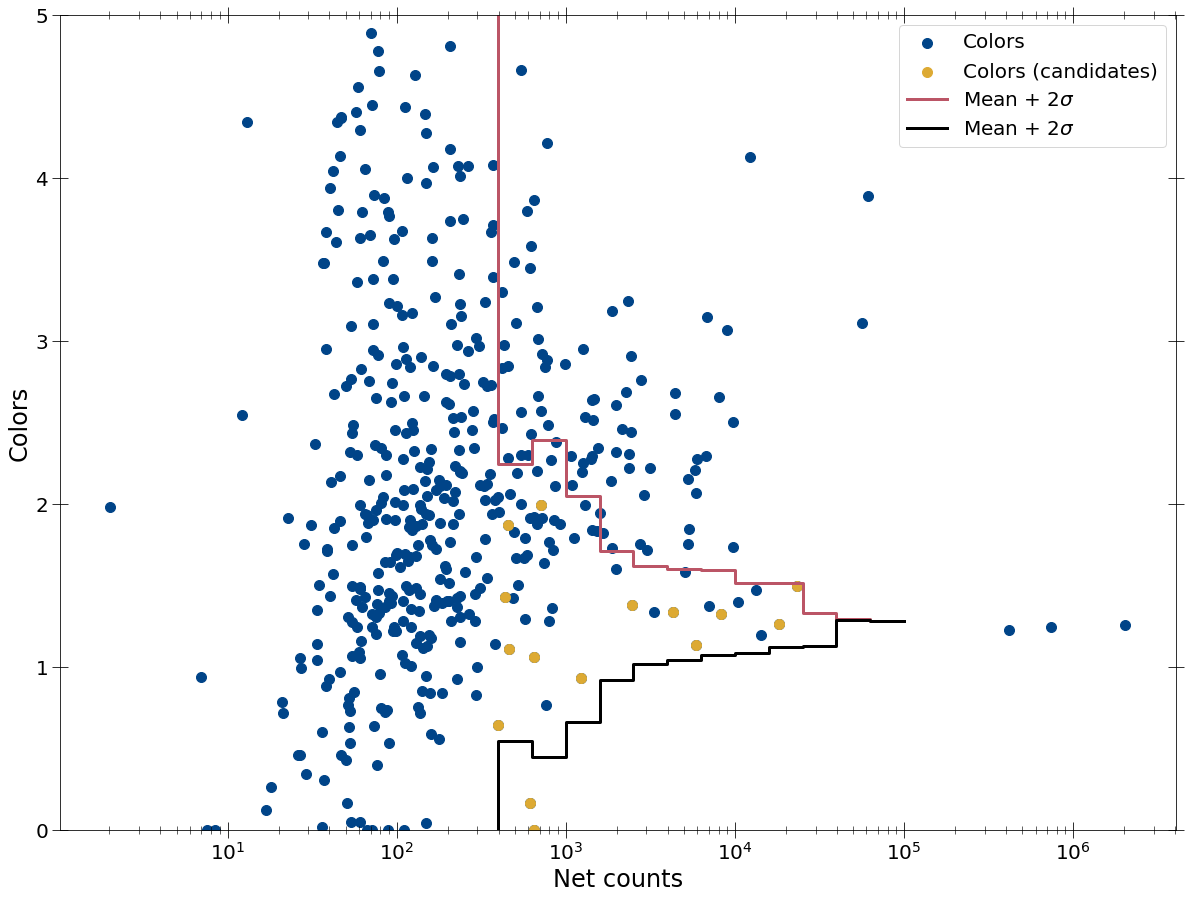

2:80: E501 line too long (83 > 79 characters)


In [56]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)

(array([ 26,  33,  66,  84, 103, 128, 137, 139, 157, 179, 183, 226]),)


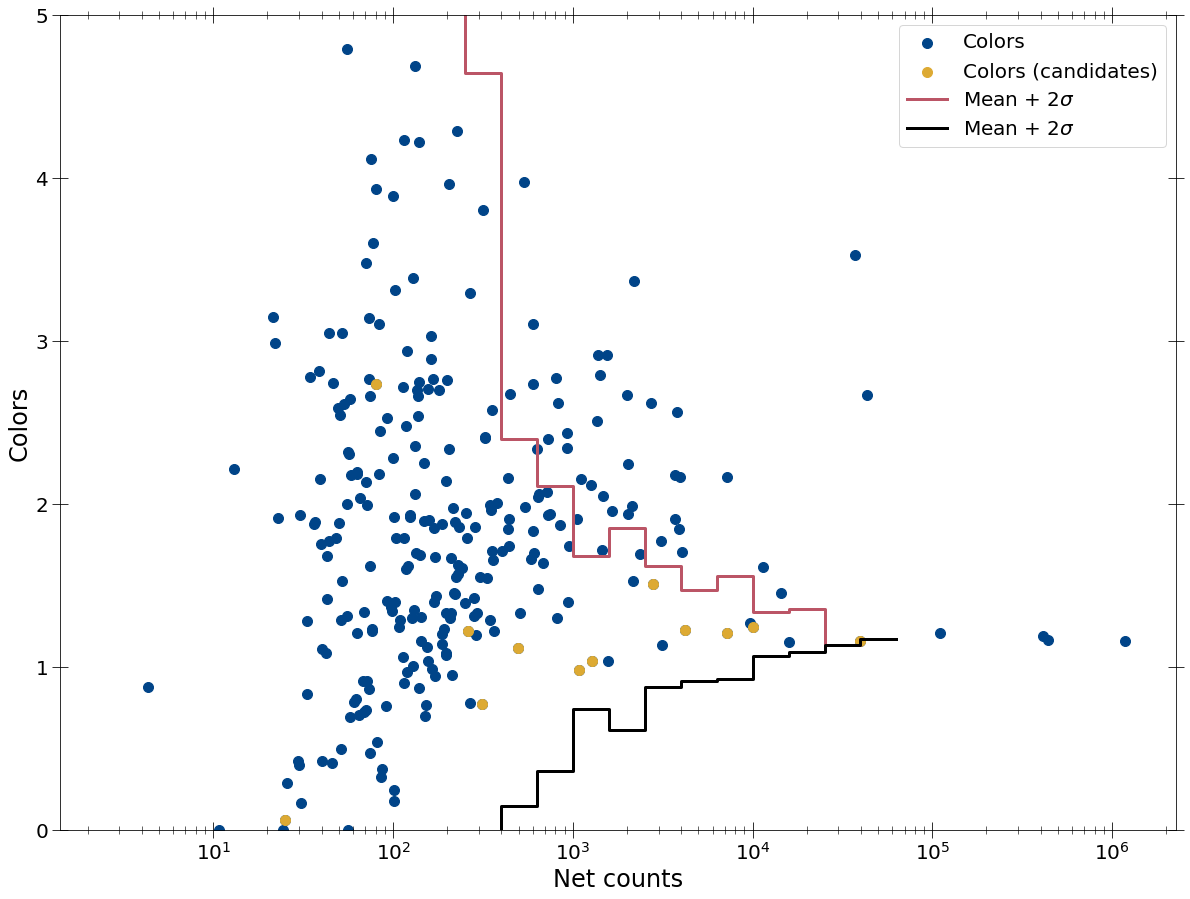

2:80: E501 line too long (83 > 79 characters)


In [47]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_, 0)

(array([   1,    2,   63,  137,  156,  162,  262,  350,  396,  453,  454,
        500,  607,  622,  623,  674,  679,  685,  831,  883,  900,  936,
        945,  949,  982,  997, 1006, 1037, 1146, 1254, 1260, 1265, 1295,
       1325, 1353, 1394, 1424, 1471, 1501, 1507, 1524, 1527, 1562, 1640,
       1647, 1650, 1686, 1734, 1767, 1863, 1885, 1901, 1980, 2041]),)


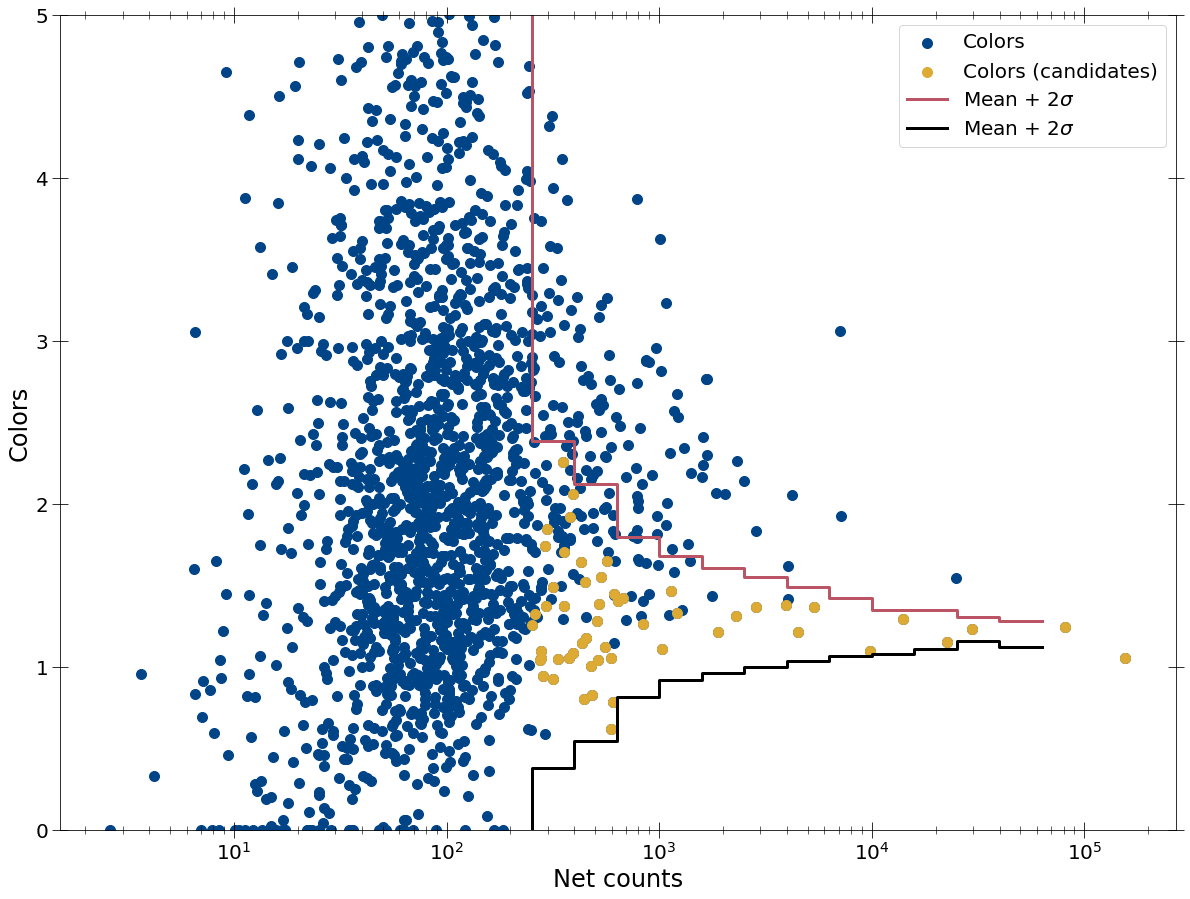

2:80: E501 line too long (83 > 79 characters)


In [65]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

(array([ 40,  50,  91, 111, 152, 198, 211, 213, 229, 231, 240, 304, 308,
       374, 467]),)
(array([ 33,  66,  84, 103, 128, 137, 139, 246, 280]),)
(array([   1,    2,   63,  137,  156,  162,  262,  350,  396,  453,  454,
        500,  607,  622,  623,  674,  679,  685,  831,  883,  900,  936,
        945,  949,  982,  997, 1006, 1037, 1146, 1254, 1260, 1265, 1295,
       1325, 1353, 1394, 1424, 1471, 1501, 1507, 1524, 1527, 1562, 1640,
       1647, 1650, 1686, 1734, 1767, 1863, 1885, 1901, 1980, 2041]),)


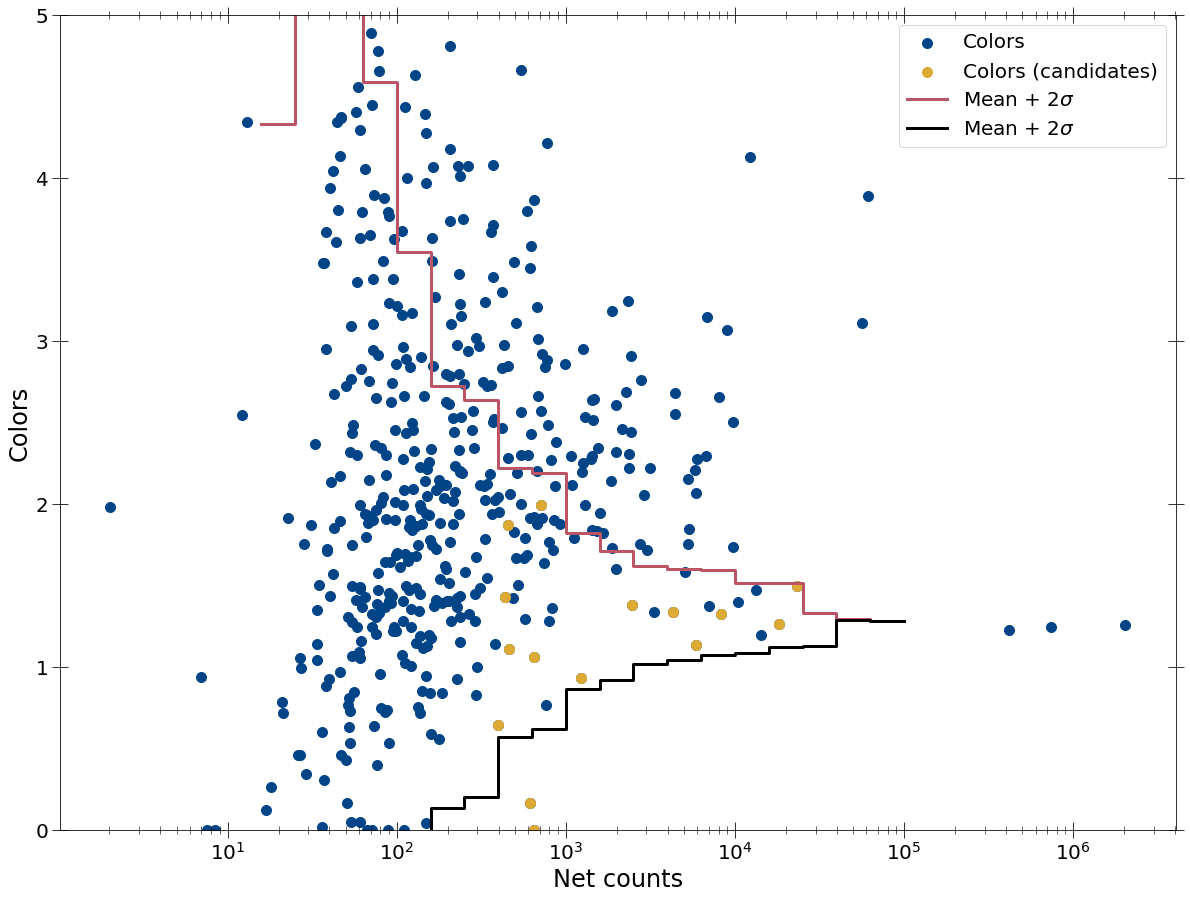

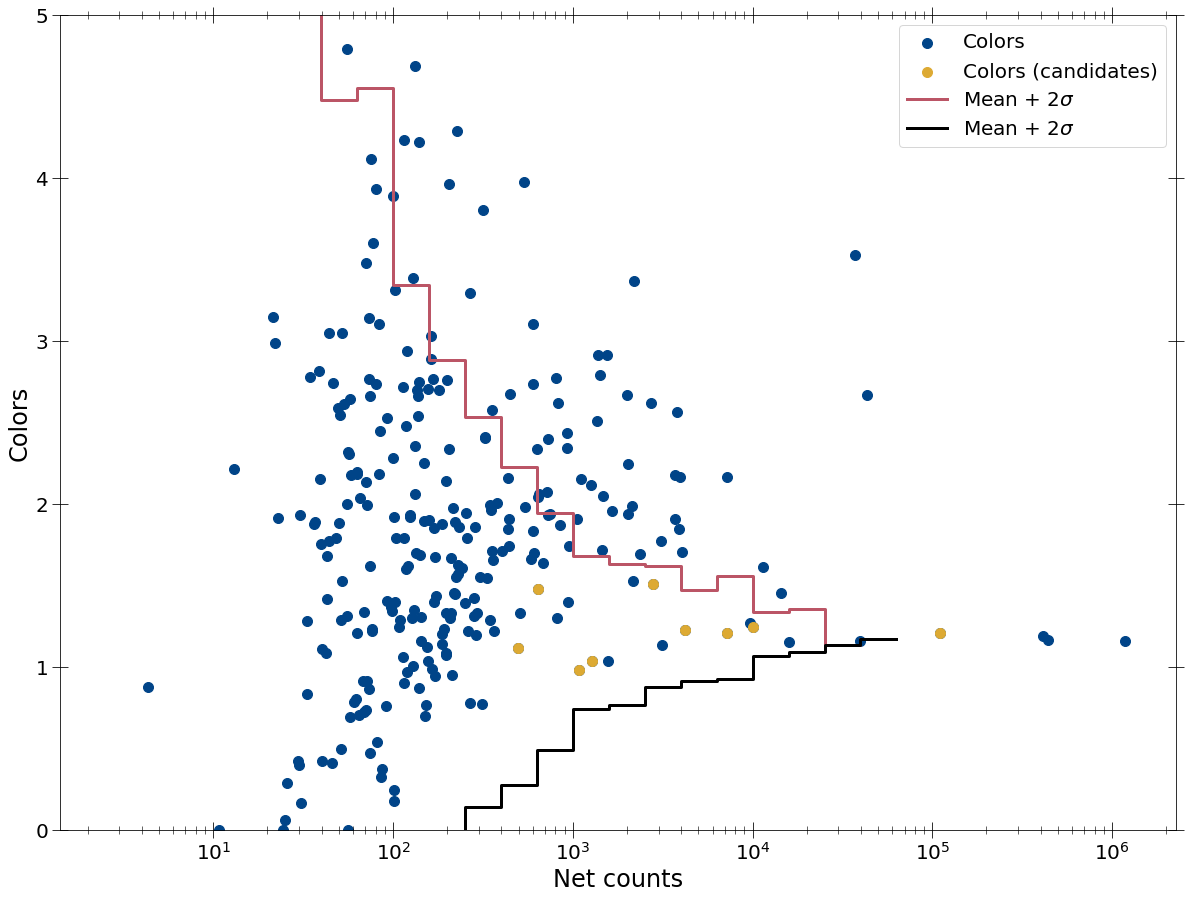

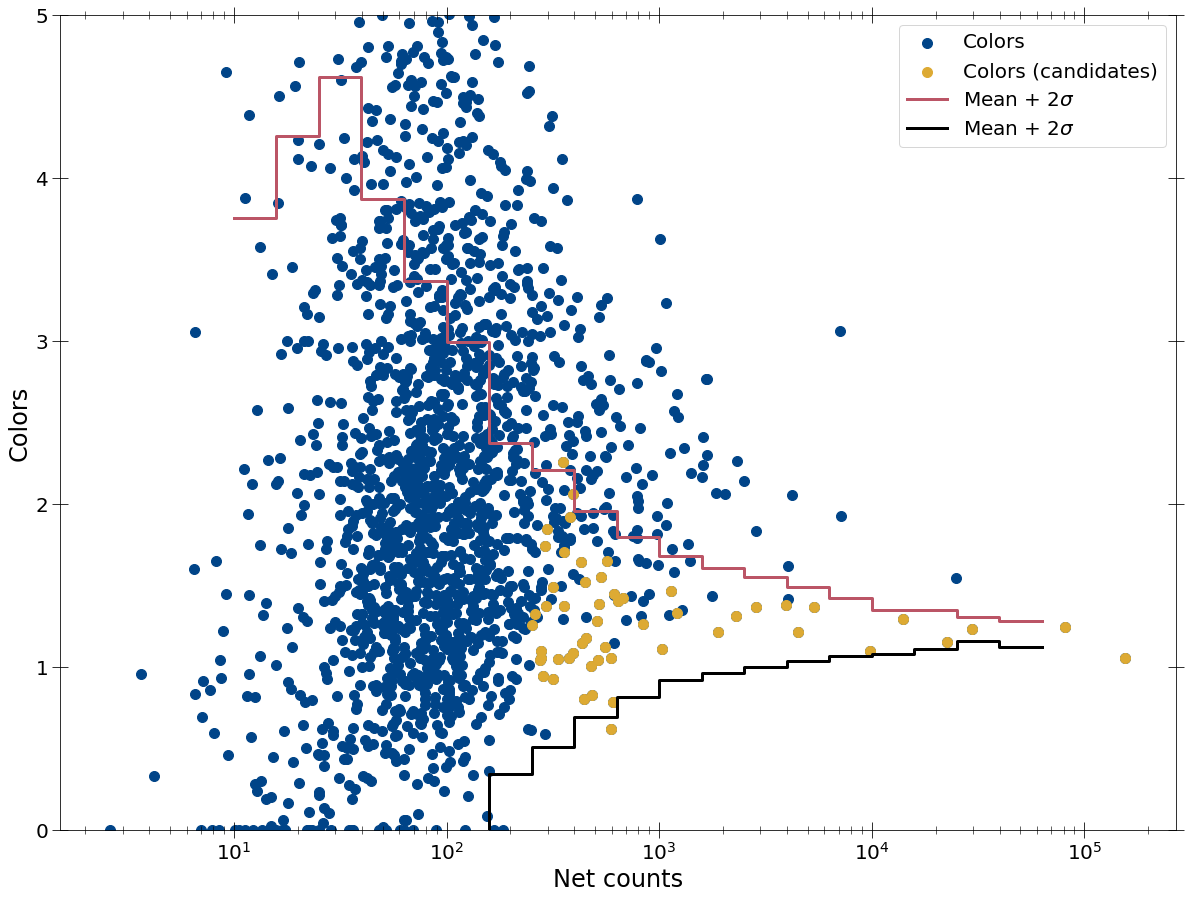

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)
4:80: E501 line too long (82 > 79 characters)
5:80: E501 line too long (83 > 79 characters)
7:80: E501 line too long (82 > 79 characters)
8:80: E501 line too long (83 > 79 characters)


In [67]:
mark_interested_srcs(sim_color_dict_arr_clipped[0], obs_color_dict_arr_clipped[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[1], obs_color_dict_arr_clipped[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

In [ ]:

    candidate_args = interested_args_alldet[0][np.where(aic_pl > aic_pl_gauss)]
    candidate_netcounts = spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][3]][candidate_args]
    interested_netcounts = spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][3]][interested_args_alldet[0]]

    candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[0]['prop_bins'][0])
    interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[0]['prop_bins'][0])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


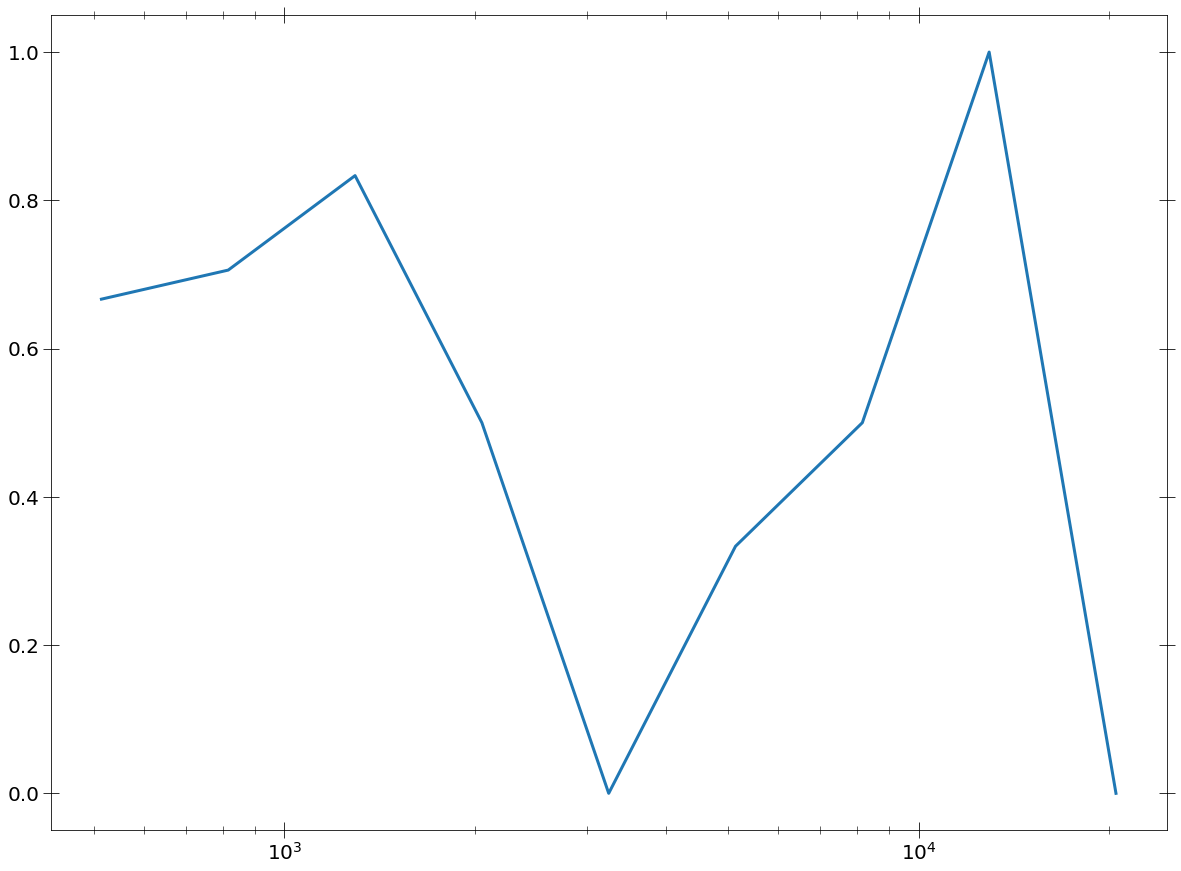

In [451]:
plt.plot(0.5*(bins[1:] + bins[:-1]), candidate_hist/interested_hist)
plt.xscale('log')

In [441]:
len(sim_color_dict_arr[0]['prop_bins'][0])

21

In [452]:
candidate_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  5,  1,  0,  1,  1,  3,  0,
        0,  0,  0])

In [453]:
interested_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 18, 17,  6,  2,  1,  3,  2,  3,  2,
        0,  0,  0])

In [449]:
bins

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05])

In [454]:
fit_stats_pl_arr = np.array(mos_fit_stats_table_pl)
fit_stats_pl_gauss_arr = np.array(mos_fit_stats_table_pl_g)

aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10

candidate_args = interested_args_alldet[1][np.where(aic_pl > aic_pl_gauss)]
candidate_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][candidate_args]
interested_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][interested_args_alldet[1]]

candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])
interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])

IndexError: index 38 is out of bounds for axis 0 with size 38

8:80: E501 line too long (103 > 79 characters)
9:80: E501 line too long (115 > 79 characters)
11:80: E501 line too long (100 > 79 characters)


In [455]:
len(fit_stats_pl_arr)

57

In [456]:
len(mos_fit_stats_table_pl)

57

In [459]:
np.sort(interested_srcs_alldet[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010154', '201113501010169', '201113503010004',
       '201129701010011', '201129701010015', '201129701010027',
       '201129701010041', '201129702010002', '201129704010011',
       '201129704010019', '201129704010027', '201129705010011',
       '201129705010015', '201129705010038', '201129705010067',
       '201129705010076', '201129705010079', '201129705015062',
       '201129706010014', '201129707010012', '201129707010063',
       '201129707010079', '201129709010024', '201129715010041',
       '201129719010010', '201129721010003', '201129721010009',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010035', '201129721010044', '201129721010057',
       '201129721010060', '201129721010063', '201129721010070',
       '201129721010078', '201129721010126', '201129721010133',
       '201129721015131', '202026705010034', '202026705010109',
       '202026708010021', '2030321020100

In [460]:
np.sort(interested_srcs_alldet[1])

array(['200305402010002', '201113501010010', '201113501010069',
       '201113501010114', '201113503010004', '201129701010035',
       '201129702010002', '201129704010048', '201129705010011',
       '201129705010014', '201129705010024', '201129705010067',
       '201129705010079', '201129705010095', '201129705015062',
       '201129706010014', '201129707010063', '201129708010036',
       '201129719010010', '201129721010003', '201129721010005',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010045', '201129721010053', '201129721010057',
       '201129721010060', '201129721010075', '201129721010138',
       '202026705010053', '204105804015018', '206556701010012',
       '206556701010019', '206946404010008', '207641904010001',
       '208016803010001', '208251401010006'], dtype=object)

In [69]:
def get_candidate_src_nums_det2(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    interested_args = []
    interested_srcs = []
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(obs_netcounts[int_args])
        interested_args.append(int_args)
        interested_srcs.append(obs_src_nums[obs_det_mask][int_args])
    return interested_args, interested_srcs


def get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


2:32: E128 continuation line under-indented for visual indent
23:21: E117 over-indented
27:1: W293 blank line contains whitespace
45:35: E128 continuation line under-indented for visual indent
54:80: E501 line too long (80 > 79 characters)
58:13: E122 continuation line missing indentation or outdented
59:13: E122 continuation line missing indentation or outdented


In [70]:
test_args, test_srcs = get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr, obs_color_dict_arr,
                                                      min_count_arr=[380, 380, 220])

[569.59489915 404.91355624 452.26180445 465.79990524 576.32276827
 493.39928098 487.52737681 463.48454887 513.71340716 539.95700063
 612.30372428 609.93432573 398.9688382  574.42562696 508.04667046
 592.28189506 435.03011623 522.26141993]
[652.69197128 823.33408827 792.69706455 674.18975953 876.79367389
 679.04689138 739.16724045 845.56868658 723.70611642 845.86782834
 764.06300906 648.50489117 711.53733848 864.90478044 817.363117
 923.15858478 648.64365916 797.95791783]
[1536.6024365  1114.66782348 1422.7130562  1291.96679205 1584.24987616
 1222.55308145]
[1989.78879578 2448.29069852]
[3333.91840967]
[5906.66947885 4300.15059039 5076.11064059]
[8272.89976422 7040.72877535]
[10372.3500844  14301.84303534 13285.45941   ]
[23304.51640767 18219.60240603]
[]
[]
[]
[ 736611.79761745  418037.54709113 2024254.48411136]
[608.05064636 440.51106749 493.03633815 438.03845112 598.07676261
 443.31577824 586.65762292 507.54544255 433.71040735 542.88105163
 402.12852783]
[743.55291637 648.44849731 71

1:80: E501 line too long (107 > 79 characters)


In [44]:
test_srcs

[[array(['201113501010066', '201113501010154', '201129701010015',
         '201129704010011', '201129704010019', '201129704010027',
         '201129707010012', '201129707010063', '201129709010024',
         '201129715010041', '201129721010070', '201129721010126',
         '204003401010007', '204105804010005', '206556701010012',
         '208016803010001', '208016813010003', '208251401010006'],
        dtype=object),
  array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  array(['201113501010035', '201129707010079', '201129721010063',
         '201129721010078', '201129721015131', '202026705010034'],
        dtype=object),
  ar

In [93]:
def combine_spec_analysis(int_srcs_list, source_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    spec_list = []
    for source_num in int_srcs_list:
        if telescope == 'XMM':
            spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                     str(source_num) + '_PN_combined_src_grp1*')
            spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                      str(source_num) + '_MOS_combined_src_grp1*')
            if len(spec_pnfile) > 0:
                spec_pn = xspec.Spectrum(spec_pnfile[0])
                spec_pn.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_pn)
                print(spec_pn.rate[0]*spec_pn.exposure)
            if len(spec_mosfile) > 0:
                spec_mos = xspec.Spectrum(spec_mosfile[0])
                spec_mos.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_mos)
                print(spec_mos.rate[0]*spec_mos.exposure)
        elif telescope == 'Chandra':
            os.chdir(src_folder + '/' + source_num)
            spec_file = str(source_num) + '_combined_src_grp1.pi'
            spec = xspec.Spectrum(spec_file)
            spec.ignore('0.0-2.0, 10.0-**')
            spec.notice('2.0-10.0')
            os.chdir(curr_dir)
        else:
            print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    
    xspec.Plot.device = '/xw'
    xspec.Plot.xAxis = 'keV'
    xspec.Plot.yLog = True
    xspec.Plot.setRebin(2, 1000, -1)
    xspec.Plot()
    print('Model params: '
          'NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats : ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([int_srcs_list, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [int_srcs_list, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

10:80: E501 line too long (80 > 79 characters)
12:80: E501 line too long (82 > 79 characters)
34:1: W293 blank line contains whitespace
44:5: E265 block comment should start with '# '
46:1: W293 blank line contains whitespace
61:80: E501 line too long (83 > 79 characters)


In [95]:
combine_spec_analysis(test_srcs[0][1])

654.4603630490105
824.1378576545412
716.8100536050601
795.4471140394922
220.3010253394772
673.1919534877306
806.0406733582817
877.330611434544
949.5044931691929
681.247948793877
162.2880763393362
736.751589007554
349.2025802477865
841.2293566233209
680.7494567901176
725.3070590144457
844.6655306385417
845.6103149179244
2153.566380181197
764.2810261818187
642.8417595934877
1078.7955794357108
711.3929357221539
864.5409737688612
113.31528293446061
815.8800274223036
923.4042521844088
74.37753238277094
649.1042695369483
797.4801613279265
586.9997543090454
Model params: NH =  13.231711938962313  Gamma:  0.9200176939172249  norm:  0.1632279364041732
Fit stats :  32184.51283053665 -6.530554835870103 50.0 29932




([array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  32184.51283053665,
  -6.530554835870103,
  50.0,
  29932],
 [array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  13.231711938962313,
  0.9200176939172249,
  0.1632279364041732])

In [88]:
spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([569.59489915, 404.91355624, 452.26180445, 465.79990524,
       576.32276827, 493.39928098, 487.52737681, 463.48454887,
       513.71340716, 539.95700063, 612.30372428, 609.93432573,
       398.9688382 , 574.42562696, 508.04667046, 592.28189506,
       435.03011623, 522.26141993])

In [80]:
spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([  77.06422098,  169.29402981,   80.75597502,  287.22584027,
        117.51882974,  131.66078883,   62.82256871,  493.03633815,
        226.05028649,  204.3105431 ,  115.47278273, -167.7485317 ,
        311.87986676, 1110.11849309,  443.31577824,  507.54544255,
        262.10215037,  433.71040735])

In [99]:
len(interested_srcs_alldet[2])

140

In [73]:
def fit_src_pl_gauss2(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss+gauss+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.4 0'
    model.gaussian.Sigma.values = '0.0 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_4.LineE.values = '6.7 0'
    model.gaussian_4.Sigma.values = '0.0 0'
    model.gaussian_4.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_5.LineE.values = '7.0 0'
    model.gaussian_5.Sigma.values = '0.0 0'
    model.gaussian_5.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('1.0 8')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 11')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 14')
    # xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_norm1_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm1_high = xspec.AllModels(1).gaussian.norm.error[1]
    line_norm2_low = xspec.AllModels(1).gaussian_4.norm.error[0]
    line_norm2_high = xspec.AllModels(1).gaussian_4.norm.error[1]
    line_norm3_low = xspec.AllModels(1).gaussian_5.norm.error[0]
    line_norm3_high = xspec.AllModels(1).gaussian_5.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_norms:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm1_low, line_norm1_high,
          xspec.AllModels(1).gaussian_4.norm.values[0], line_norm2_low,
          line_norm2_high, xspec.AllModels(1).gaussian_5.norm.values[0],
          line_norm3_low, line_norm3_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.norm.values[0],
             xspec.AllModels(1).gaussian_4.norm.values[0],
             xspec.AllModels(1).gaussian_5.norm.values[0], line_norm1_low,
             line_norm1_high, line_norm2_low, line_norm2_high, line_norm3_low,
             line_norm3_high])


25:1: W293 blank line contains whitespace
40:1: W293 blank line contains whitespace
52:5: E265 block comment should start with '# '
73:80: E501 line too long (80 > 79 characters)


In [74]:
fit_src_pl_gauss2(interested_srcs_alldet[1][11])

Exception: Error executing command: fit

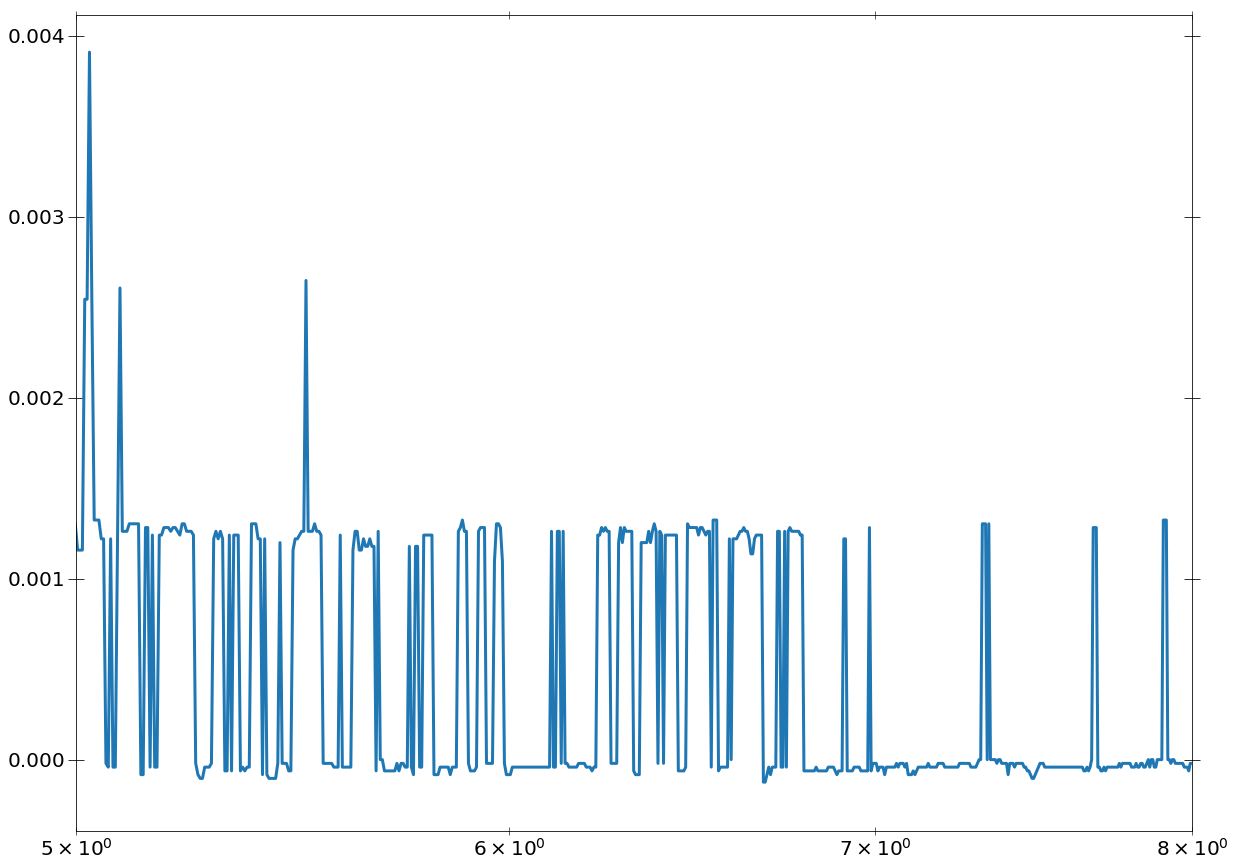

2:80: E501 line too long (130 > 79 characters)


In [62]:
plt.plot(spec_summary['ebins'][1][1][400:2000],
         median_filter(spec_summary['norm_specs'][1][1][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]], size=5))
plt.xlim(5.0, 8.0)
plt.xscale('log')

In [67]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]]

'200305402010002'

In [82]:
from astropy.table import Table
from astropy.table.pprint import conf
conf.max_lines = -1
conf.max_width = -1

In [83]:
Table(np.column_stack([np.array(pn_fit_stats_table_pl)[:, 0],
                       np.array(pn_fit_stats_table_pl_g2)[:, 4],
                       np.array(pn_fit_stats_table_pl)[:, 1],
                       np.array(pn_fit_stats_table_pl_g)[:, 1],
                       np.array(pn_fit_stats_table_pl_g2)[:, 1],
                       np.array(pn_model_params_table_pl_g)[:, 4],
                       np.array(pn_model_params_table_pl_g)[:, 7],
                       np.array(pn_model_params_table_pl_g2)[:, 4],
                       np.array(pn_model_params_table_pl_g2)[:, 5],
                       np.array(pn_model_params_table_pl_g2)[:, 6]]))

<Table length=58>
      col0       col1        col2               col3               col4               col5                 col6                   col7                   col8                   col9         
     str32      str32       str32              str32              str32              str32                str32                  str32                  str32                  str32         
--------------- ----- ------------------ ------------------ ------------------ ------------------ ---------------------- ---------------------- ---------------------- ----------------------
201113501010066  1097  888.3133866673959  881.7070650294453  881.1913228858143  6.495842098254313  5.728099295853509e-07  4.331544399555877e-07 1.9773822826801004e-07 1.5584199303060894e-07
201113501010154  1149  903.3608054015875  898.9897342154572  894.8121029186211  6.416690600469637  3.657184129034429e-07 3.5010040157522126e-07  4.580896096106657e-20 3.0838833914018393e-07
201129701010015   880  729.9447013450703  726.1680242153152   728.208293235638  6.878504435779244 2.8030459351071563e-07  6.557294646155204e-09  3.952180009005394e-08   1.84901608991034e-07
201129704010011  1194 1012.6079029890961 1002.1164436811466 1000.9736609156014  6.376259261068899  1.038662399360663e-06  7.930982457150612e-07  1.384644000570789e-07  4.940973238026691e-07
201129704010019  1215 1029.8154873905944 1025.8642811120633 1025.0969960585987  6.445404018100875  4.927351161304949e-07 3.2552759609400053e-07 1.0890863712728476e-07 3.7679459927014663e-07
201129704010027  1010  785.9195607248512  779.6130717470733  772.8673731092612  6.914603394912961  9.147377125465467e-07  7.142996249303996e-07 2.7521655807736366e-07  8.885324041183697e-07
201129707010012   682   567.787069467711  553.9318661357931  560.4612703153173  6.280521164961761  1.108564397466515e-06  6.793189563458339e-07 2.4888436958518062e-11  7.328702613575944e-08
201129707010063  2029  1603.580620175288 1603.4019947460515 1603.5633270184708  6.818844746386391 1.7222155963966992e-07 1.3274084432954834e-13 4.1359511318018613e-08 2.1443448180484209e-13
201129709010024   900  811.3262222227015  794.8089768017549  781.4206009405018 6.5481877496665355  9.642184610454263e-07  6.496074113129098e-07   6.07007290264001e-07 4.4822010250036727e-07
201129715010041  1034  874.5940461384438  863.4061820593956  856.2815123478654  6.789130174138019  5.935354490473833e-07  4.044163041726859e-07 3.4045138379642045e-07  2.829822266799647e-07
201129721010070  1536 1368.7909668927011 1363.6786628556076 1359.2717472122838  6.698765985480515  3.636688327975731e-07  2.536432877641739e-07 2.7199356036791055e-07  6.380835318524561e-08
201129721010126  2247 2056.1101220958135  2053.200585681294  2056.155328694617  6.100000000039239 1.9827337971923438e-07  1.123985724773552e-19 2.2605979657196566e-08 1.0167671193164822e-21
204003401010007  1384 1141.6552412391381 1141.5054008909347 1141.6854008904472  7.299999998226762  7.519391980881133e-08 6.2415342406533365e-15 2.1783277157329295e-15 2.4556035404823284e-16
204105804010005  1831  1497.955651820031 1491.1449179670433 1494.0475189246063  6.335984950645728  9.956675298151302e-07  5.889168575620609e-07  4.101678286897325e-14  1.508131704458345e-07
206556701010012  1498 1186.5589869334085 1158.4382948149878   1156.93355462016  6.664569714183259  9.879737143004975e-07  1.258050961555429e-07  8.132278353689629e-07  3.694738627039989e-12
208016803010001  1130   991.648224955775  986.3285668155654  986.6302556755354   6.47529835813703  1.348419485181247e-06 1.0077564820562453e-06 3.5762682889789996e-07  6.663621104605321e-15
208016813010003   760  609.6442782716246   607.318719084682  608.3194279092002  6.922400232207302  3.887961194557842e-07  3.958987589518239e-08  5.459081399403479e-22 3.2083101899889503e-07
208251401010006  1153  885.2047801624528  868.0245187034831  865.2031044494875  6.796034861844605 1.0310878445694557e-06 2.0726588575814643e-07  6.388394028854008e-07   6.25504734638

In [75]:
np.array(pn_fit_stats_table_pl)

array([['201113501010066', '888.3133866673959', '-8.204968056946765',
        '50.0', '1100'],
       ['201113501010154', '903.3608054015875', '-7.9889327474572935',
        '50.0', '1152'],
       ['201129701010015', '729.9447013450703', '-6.853237332107479',
        '50.0', '883'],
       ['201129704010011', '1012.6079029890961', '-4.516491937423837',
        '50.0', '1197'],
       ['201129704010019', '1029.8154873905944', '-8.696263026204749',
        '50.0', '1218'],
       ['201129704010027', '785.9195607248512', '-7.299622810407817',
        '50.0', '1013'],
       ['201129707010012', '567.787069467711', '-7.714088239148532',
        '50.0', '685'],
       ['201129707010063', '1603.580620175288', '-5.885724150152902',
        '50.0', '2032'],
       ['201129709010024', '811.3262222227015', '-6.198280503456527',
        '50.0', '903'],
       ['201129715010041', '874.5940461384438', '-8.348768445708139',
        '50.0', '1037'],
       ['201129721010070', '1368.7909668927011', '-